In [11]:
%matplotlib inline
# %matplotlib qt

In [409]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import *
import arc
import random
import networkx as nx
import time
from mpl_toolkits.mplot3d import Axes3D
import pylab
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import optimize



In [555]:
##
#Functions for generating, interpreting, and plotting nodes
##
class Node:
    
    def __init__(self,ind,coord,pairs):
        self.id = ind
        self.coord = coord
        self.pairs = pairs
        self.x,self.y = transform(coord)
        self.dist = np.sqrt(self.x**2+self.y**2)
        self.disorder = np.random.normal(0,err)
        print(self.x,self.y)

theta = np.pi/6


def transform(coord):
    x=round(coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta)),3)
    y=round(coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta)),3)
    return y,x

def plotNodes(ax,nodes):
    coords = []
    values = []
    for ID,node in nodes.items():
        for pair in node.pairs:
            x1,y1 = transform(pair[0])
            x2,y2 = transform(pair[1])
            if type(pair[2]) is int:
                c = "black"
                ax.plot([x1,x2],[y1,y2],color="black",linewidth=9,label=str(node.id),alpha=.5,zorder=1)
            else:
                if np.imag(pair[2])>0:
                    c = "r--"
                    ax.arrow(x1,y1,x2-x1,y2-y1,length_includes_head=True,color="red",linewidth=6,head_width=.02,alpha=.5,zorder=1)
                else:
                    ax.arrow(x2,y2,x1-x2,y1-y2,length_includes_head=True,color="red",linewidth=6,head_width=.02,alpha=.5,zorder=1)

#     plt.show()

In [22]:
##
#Functions for generating adjacency matrices from sets of nodes
##

#Generates an adjacency matrix from a list of pairs 
def genAdjMatrix(dim,nodes):
    matrix = np.array([np.zeros(dim,dtype=np.cdouble) for i in range(dim)])
    
    for ind, node in nodes.items():
        if node.pairs:
            n1 = node.id
            for pair in node.pairs:
                if str(pair[1]) in nodes:
                    n2 = nodes[str(pair[1])].id
                    
                    if matrix[n1,n2] == 0.+0.j:
                        w = pair[2]
                        matrix[n1,n2] = w
                        matrix[n2,n1] = np.conj(w)

    return matrix, nodes


def symmTess(x,y,wx,wy,wz,a):
    if a:
        return [[[x,y,0],[x-1,y,1],wx],[[x,y,0],[x,y-1,1],wy],[[x,y,0],[x,y,1],wz],\
            [[x,y,0],[x+1,y,0],+P],[[x,y,0],[x,y+1,0],0-P],[[x,y,0],[x-1,y+1,0],+P]]
    else:
        return [[[x,y,1],[x+1,y,1],0-P],[[x,y,1],[x,y+1,1],0+P],[[x,y,1],[x-1,y+1,1],0-P]]    

def asymmTess(x,y,wx,wy,wz,a):
    if a:
        return [[[x,y,1],[x+1,y,0],wx],[[x,y,1],[x,y+1,0],wy],[[x,y,1],[x,y,0],wz],\
            [[x,y,1],[x+1,y,1],-P],[[x,y,1],[x,y+1,1],0+P],[[x,y,1],[x-1,y+1,1],-P]]
    else:
        return [[[x,y,0],[x+1,y,0],0+P],[[x,y,0],[x,y+1,0],0-P],[[x,y,0],[x-1,y+1,0],0+P]]

def asymmAdj(dim,wx,wy,wz):
    nodes = {str([0,0,1]):Node(1,[0,0,1],asymmTess(0,0,wx,wy,wz,True))}
    for y in range(dim):
        for x in range(dim):
            if not (x==y and y==0):
                if not (x==dim-1 and y==dim-1):
                    nodes[str([x,y,1])] = Node((y*dim+x)*2,[x,y,1],asymmTess(x,y,wx,wy,wz,True))
                nodes[str([x,y,0])] = Node((y*dim+x)*2+1,[x,y,0],asymmTess(x,y,wx,wy,wz,False))
    nodes[str([dim-1,dim-1,0])].id-=1
    
    return nodes


def symmAdj(dim,wx,wy,wz):
    nodes = {}
    rng = np.delete(np.array([[i,-i] for i in range(dim)]).flatten(),0)

    for i in range(len(rng)):
        y=rng[i]
        for j in range(len(rng)):
            x=rng[j]
            if np.absolute(x+y)<dim:
                if not (dim%2==1 and (np.absolute(x+y)+np.absolute(x)+np.absolute(y)==dim+1)):
                    nodes[str([x,y,0])] = Node((i*(dim+1)+j)*2,[x,y,0],symmTess(x,y,wx,wy,wz,True))
                if not y==dim-1 and not x==dim-1 and not x+y+1==dim:
                    nodes[str([x,y,1])] = Node((i*(dim+1)+j)*2+1,[x,y,1],symmTess(x,y,wx,wy,wz,False))
    return nodes
    
    
#Alternating "on" and "off" starting from edge
def genAdj(symm,dim,wx,wy,wz):
    nodes = {}
    if symm:
        nodes = symmAdj(dim,wx,wy,wz)
    else:
        nodes = asymmAdj(dim,wx,wy,wz)
    i=0
    for node,i in zip(nodes.values(),range(lattice_num(symm,dim))):
        
        if node.pairs:
            remove = []
            for pair in node.pairs:
                if not str(pair[1]) in nodes:
                    remove.append(pair)
            for baddies in remove:
                node.pairs.remove(baddies)
        node.id=i
    return nodes
        

In [23]:
##
#Functions for creating and reducing quantum objects. Also defines Hamiltonian parameters
##
np.set_printoptions(linewidth=160)

op2state = [qeye(2),create(2),destroy(2)]
opOnSite = [qeye(2),sigmaz()]


def getBasisFast(index,n):
    num = 0
    for i in range(2,n+2):
        
        if index%2 == 1:
            num += 1
            index -= 1
        index/=2
        
    return num

def choose(n,k):
    c = 1
    for i in range(k+1,n+1):
        c *= i
    for i in range(2,n-k+1):
        c/=i
    return int(c)

def extractBlock(H,n,val,s=None):
    size = choose(n,val)
    indices = []
    tot = 0
    for i in range(2**n):
        if getBasisFast(i,n) == val:
            indices.append(i)
            tot += 1
        if tot == size:
            break
    arr = []
    if s:
        arr = np.take(s,indices)
        q = Qobj(arr,dims=[[2 for i in range(val)],[1 for i in range(val)]], shape=(n,1))
    else:
        for i in indices:
            arr.append(np.take(H[i][0],indices))
        q = Qobj(arr,dims = [[2 for i in range(val)] for i in range(2)], shape = (n, n))
    return q


def genLadderPair(c,d,size):
    arr = [op2state[int(i==c)+int(i==d)*2] for i in range(size)]
    op = tensor(arr)
    return op

def genOnSite(i,size):
    op = (1/(2**(size)))*tensor([opOnSite[0]+(1-2*int(i==j))*opOnSite[1] for j in range(size)])
    return op

#Generates a single excitation in a an ensemble of coupled 2 level states
def gen2lvlState(n,states):
    Qobj()
    state = basis(2,states[0])
    for i in range(1,n):
        state =tensor(state,basis(2,states[i]))
    return state

#Generates an observation basis of state number n, with number of exciatations num_states
def genBasisArbitrary(n):
    
    obs_list = [qeye(2),.5*(qeye(2)-sigmaz())]
    observables = {}
    for i in range(n):
        key = "".join(np.array([int(i==j) for j in range(n)]).astype("str"))
        observables[key] = (tensor([obs_list[int(i==j)] for j in range(n)]))
    return observables
     
def lattice_num(symm,n):
    if symm:            
        return 3*np.sum([i for i in range(n+1)])+1
    else:
        return 2*n**2-2
#Generates a Hamiltonian from an adjacency matrix
def genHamiltonianFromAdjMatrix(adj_matrix):
    x = len(adj_matrix)
    dims = [2 for i in range(x)]
    H = 0
    for i in range(x):
        for j in range(x):
            if adj_matrix[i][j] != 0:
                H+=adj_matrix[i][j]*genLadderPair(i,j,x)
            if i == j:
                if i%2==0:
                    H+=M*genOnSite(i,x)
                else:
                    H-=M*genOnSite(i,x)
    return H

In [564]:
##
#Functions for plotting Hamiltonian information/results
##

ep=.0001

def calcResponseFunc(H,omegas,eVals,eVecs,s_i,s_j,s1,s2):

    totals = []
    for w in omegas:
        summ = 0
        for eVal,eVec in zip(eVals,eVecs):
            psi_i=s_i.dag().overlap(eVec)
            psi_j=s_j.dag().overlap(eVec)
            summ+=np.absolute(psi_i*psi_j/(w-eVal+1j*ep))
        totals.append(summ)
        
    plt.plot(omegas,totals)
    plt.title("Response function for site "+str(s1)+" and "+str(s2))
    plt.show()
    return totals
   
def getxy(nodes):
    x = []
    y = []
    for key,value in nodes.items():
        x.append(value.x)
        y.append(value.y)

    return x,y
    
def prepPlot(tlist,nodes,result):
    results_by_position = result.expect
    probs = [[] for i in range(len(tlist)-1)]
    for i in range(len(tlist)-1):
        probs[i] = np.array([value[i] for key, value in results_by_position.items()])
    x,y = getxy(nodes)
    

    fig_anim, ax_anim = plt.subplots(ncols=1, sharey=False, figsize=(24,30))


    fig_anim.subplots_adjust(hspace=0.25, left=0.07, right=0.93)
    
    return x,y,fig_anim,ax_anim,probs
#     return probs

def ranNum(val):
    return np.random.rand(val)[0]

def plotPath(result,tlist,nodes):
    
    x,y,fig_anim,ax_anim,probs = prepPlot(tlist,nodes,result)
#     probs = prepPlot(tlist,nodes,result)
    
    def updateHaldane(i):
        fig_anim.clf()
        ax_anim = fig_anim.add_subplot(111)
        plotNodes(ax_anim,nodes)


        prob = probs[i]
        plt.axis('off')
        xmin = np.min(x)-1
        xmax = np.max(x)+1
        ymin = np.min(y)-1
        ymax = np.max(y)+1
        hb = ax_anim.scatter(x, y,c=prob, cmap='inferno',s=25000,vmin=0,vmax=.20,zorder=100)
        ax_anim.axis([xmin, xmax, ymin, ymax])
#         cb = fig_anim.colorbar(hb, ax=ax_anim)
        
        return ax_anim 

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=60, metadata=dict(artist='Me'), bitrate=1800)
    animation.FuncAnimation(fig_anim, updateHaldane,frames=len(tlist)-1, interval=1).save('bigg_m_05_i_n05pi.mp4', writer=writer)
    
#     fig, ax = plt.subplots(ncols=1, sharey=False, figsize=(15,10))
    n = len(probs)
    probs = np.transpose(probs)
#     t = len(probs)
    x = [i for i in range(n)]
#     for i in range(t):
#         ax.scatter(x,probs[i],color=(ranNum(1),ranNum(1),ranNum(1)),label="Site "+str(i))
#     ax.legend()

#     fig.show()
    
    return computeTunnelingRate(x,probs[4]),computeTunnelingRate(x,probs[9])
  
    
def plotTimeIntegral(result,tlist,nodes):
    global fig
    x,y,fig,ax,probs = prepPlot(tlist,nodes,result)

    probs = np.zeros(len(result.expect))
    for i in range(len(tlist)-1):
        probs += np.array([value[i] for key,value in result.expect.items()])
    hb = ax.hexbin(x, y, C=probs, gridsize=3, cmap='inferno',vmax=.5,vmin=0)
    cb = fig.colorbar(hb, ax=ax)
    plt.show()
    
def plotEigenVector(ket_array,o_basis,nodes):
    x,y = getxy(nodes) 

    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(12,10))
    plotNodes(ax,nodes)
    
    xmin = np.min(x)-1
    xmax = np.max(x)+1
    ymin = np.min(y)-1
    ymax = np.max(y)+1
    hb = ax.scatter(x, y,c=ket_array, cmap='inferno',s=4000,vmin=0,vmax=.3,zorder=100)
    ax.axis([xmin, xmax, ymin, ymax])
    cb = fig.colorbar(hb, ax=ax)
    plt.show()

    
def plotResponseFunction(eVals,eVecs,lat_sites,obs_basis):
    steps = 2500
    omegas = np.linspace(-1+eVals[0],1+eVals[-1],steps)
    totals = np.zeros(steps)
    for k in range(lat_sites):
        s1 = extractBlock(H,lat_sites,obs_basis,\
                                 gen2lvlState(lat_sites,[int(i==k) for i in range(lat_sites)]))
        for j in range(lat_sites):
            s2 = extractBlock(H,lat_sites,obs_basis,\
                                 gen2lvlState(lat_sites,[int(i==j) for i in range(lat_sites)]))
            totals+=calcResponseFunc(H,omegas,eVals,eVecs,s1,s2,j,k)
    plt.plot(omegas,totals)
    plt.scatter(eVals,np.zeros(len(eVals)))
    plt.title("Conductivity")
    plt.show()
    
def computeEdgeness(values,nodes):
    edgeness = 0
    for value,node in zip(values,nodes.values()):
        edgeness += value*node.dist
    return edgeness


def periodicFit(x, a, b):
    return a * np.sin(b * x)


def computeTunnelingRate(x,y):
    params, params_covariance = optimize.curve_fit(periodicFit, x, y,
                                               p0=[2, 2])
    return params
        

In [402]:
##
#Main/running and manipulating Hamiltonians  
##

def prepHamiltonian(symm,atom_order,obs_basis,w1,w2,w3):
    lat_sites = lattice_num(symm,atom_order)
    adj_matrix,nodes = genAdjMatrix(lat_sites,genAdj(symm,atom_order,w1,w2,w3)) 
    H = genHamiltonianFromAdjMatrix(adj_matrix)
   
    H_red = extractBlock(H,lat_sites,obs_basis)
    proj = genBasisArbitrary(lat_sites)
    proj_red = proj.copy()
    for key,value in proj_red.items():
        proj_red[key] = extractBlock(value,lat_sites,obs_basis)
    eVecs = H_red.eigenstates()
    return nodes,lat_sites,H_red,proj_red,eVecs[0],eVecs[1]
    
    
def runHamiltonian(lat_sites,state_ind,H,proj,obs_basis,state=None,time=0,step=0,):
    
    tlist = np.linspace(0,time,step)
    
    if not state:
        if obs_basis ==1:
            state = gen2lvlState(lat_sites,[int(i==state_ind) for i in range(lat_sites)])
        else:
            arr = [int(i<obs_basis) for i in range(lat_sites)]
            np.random.shuffle(arr)
            state = gen2lvlState(lat_sites,arr)
    
        state = extractBlock(H,lat_sites,obs_basis,state)

    result = sesolve(H,state,tlist,proj)
    high_freq_params,low_freq_params = plotPath(result,tlist,nodes)
    return high_freq_params,low_freq_params
#     plotTimeIntegral(result,tlist,nodes)
#     plotResponseFunction(eVals,eVecs,lat_sites,obs_basis)
    print("Calcing response function")
    
    return 

def findEigenVectors(eVecs,eVals,o_basis,nodes,plot):
    evalsList = []
    eVecsList = []
    edgeness = []
    for i in range(eVecs[1].shape[0]):
        orth = True
        ket_array = []

        for key,value in o_basis.items():
            ket_array.append(np.real((value*eVecs[i]).norm())**2)
        if np.sum(ket_array)>0.01:
            evalsList.append(eVals[i])
            edgeness.append(computeEdgeness(ket_array,nodes))
            if plot:
                print(eVals[i])
                plotEigenVector(ket_array,o_basis,nodes)
                plt.show()
        eVecsList.append(ket_array)

    return evalsList,eVecs,edgeness/np.sum([np.sum(edge_list) for edge_list in edgeness])


In [557]:
def printEigenspectrum(M,P,w1,w2,w3,symm,atom_sets):
    eVals=[]
    eVecs=[]
    x = []
    edge_vals = []
    site_num = None
    node_distances = None
    site_num = lattice_num(symm,atom_sets)
    for obs_basis in range(1,site_num):
        print(str(obs_basis)+" particle basis")
        nodes,site_num,H,proj,eVals_temp,eVecs_temp=prepHamiltonian(symm,atom_sets,obs_basis,w1,w2,w3)
        eVal,eVec,edgeness = findEigenVectors(eVecs_temp,eVals_temp,proj,nodes,False)
        eVals.append(eVal)
        edge_vals.append(edgeness)
        x.append([obs_basis for j in range(len(eVal))])
    plt.figure(figsize=(15,20))   
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
        ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
    plt.figure(figsize=(15,20))   
    fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(10,10))
    plt.ylim(top=.5,bottom=-.5)
    for x_i,eVal,edge_val in zip(x,eVals,edge_vals):
        ax.scatter(x_i,eVal,c=edge_val,cmap="plasma")
    plt.show()

In [ ]:
symm = True
atom_sets = 2     #How many coupling pairs
state_ind = 2
obs_basis = 1         #Number of excited states in observation basis
w1 = 1                #The first weight
w2 = 1               #The second weight
w3 = 1
periods =2.5            #How many time periods
step = 500          #How many time steps

nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,atom_sets,state_ind,obs_basis,w1,w2,w3,periods,step)


In [236]:
M=2
P=np.pi*1j

symm = True
atom_sets = 2     #How many coupling pairs

nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,atom_sets,obs_basis,w1,w2,w3)

Solving


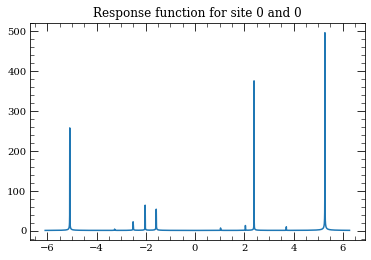

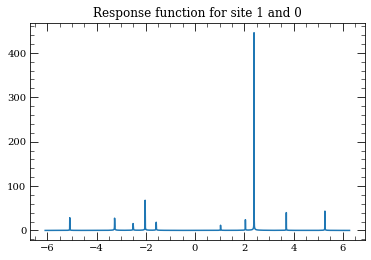

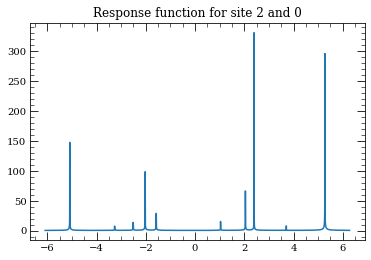

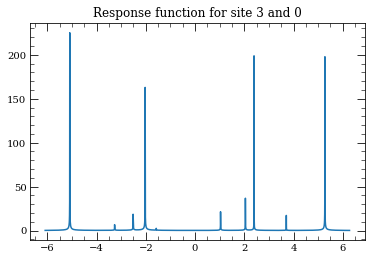

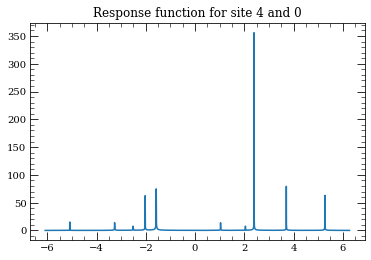

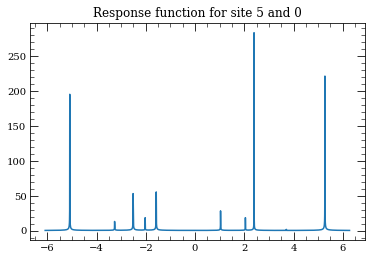

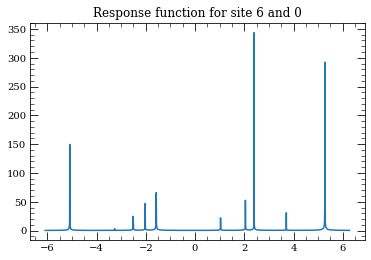

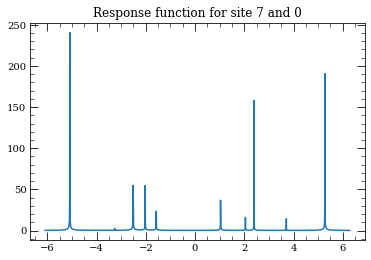

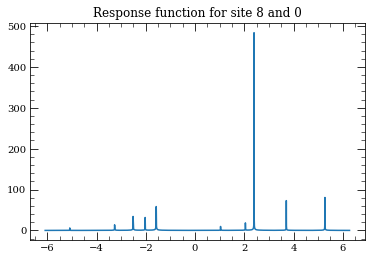

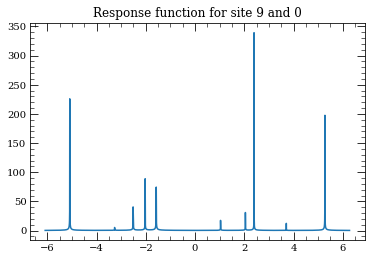

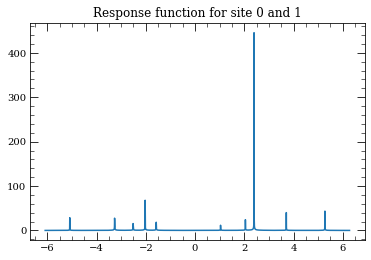

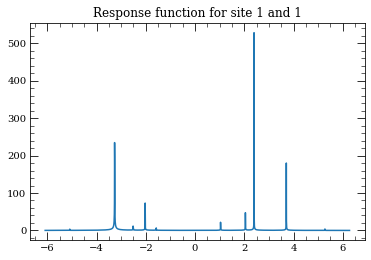

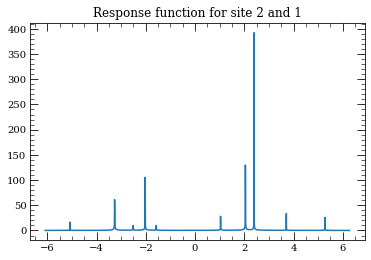

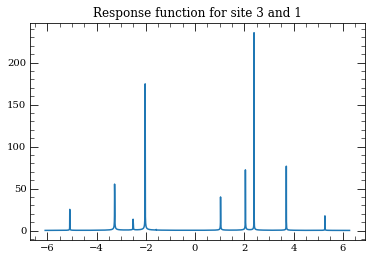

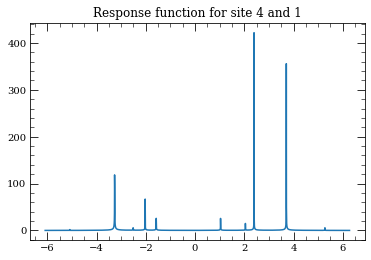

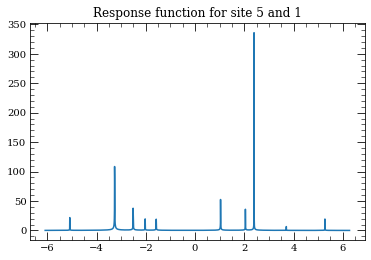

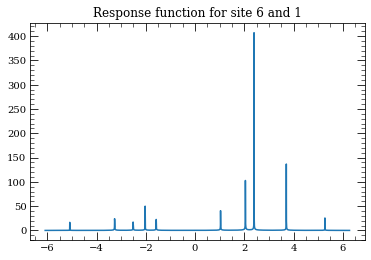

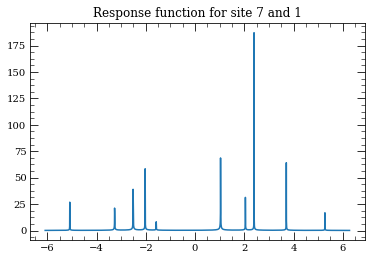

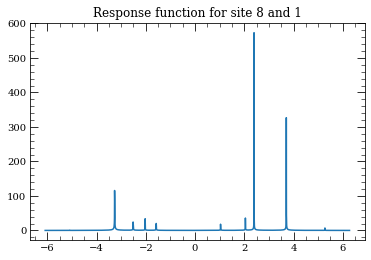

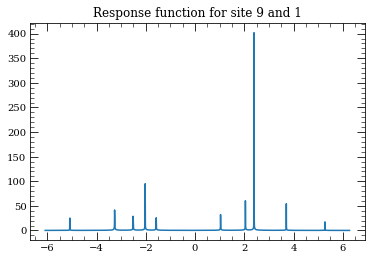

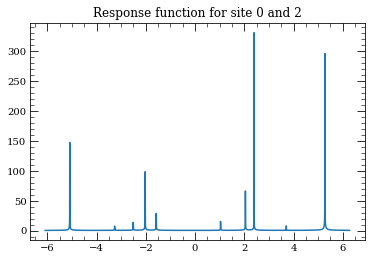

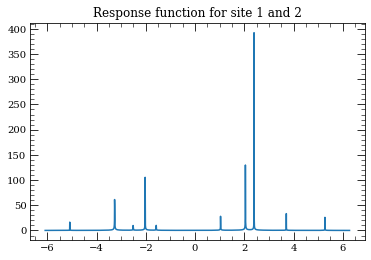

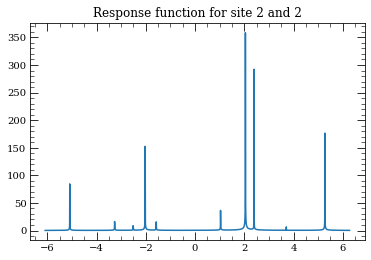

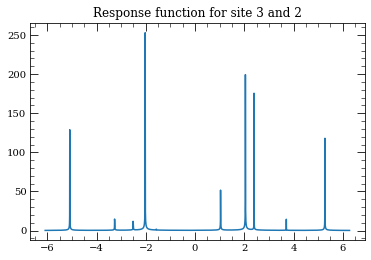

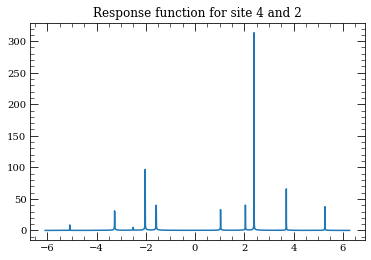

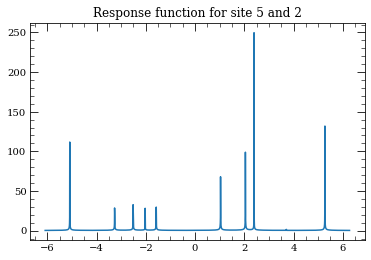

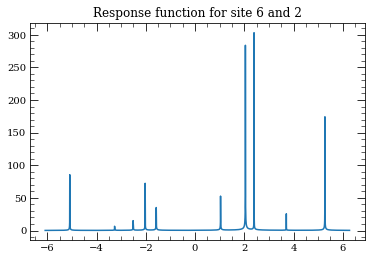

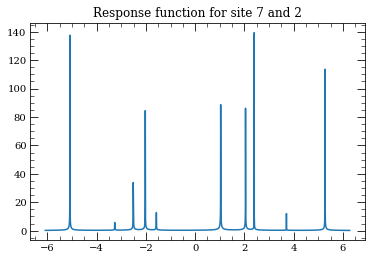

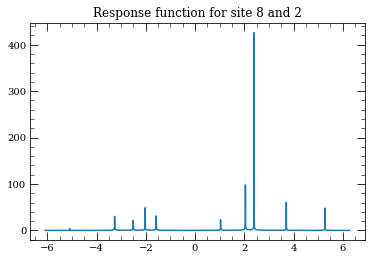

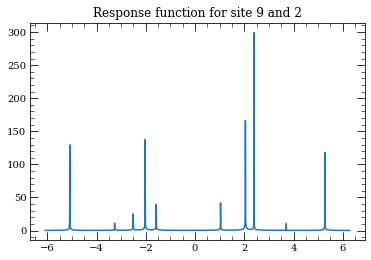

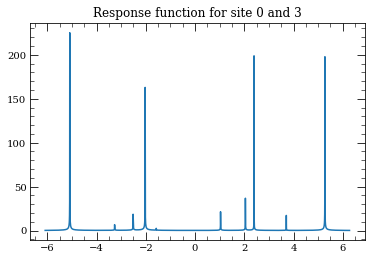

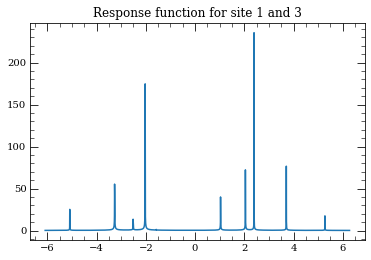

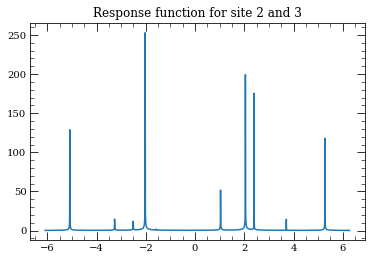

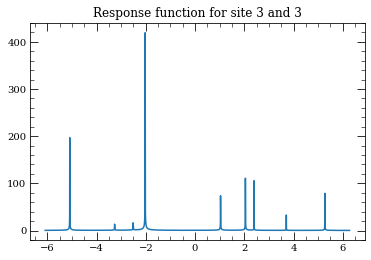

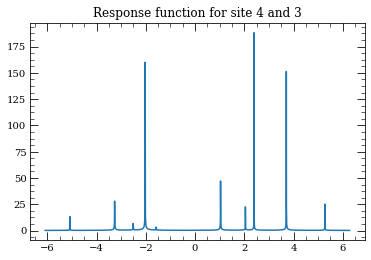

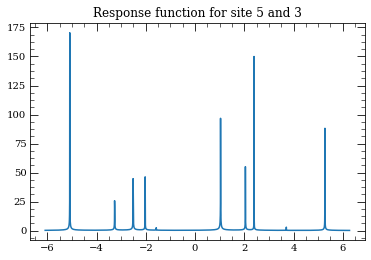

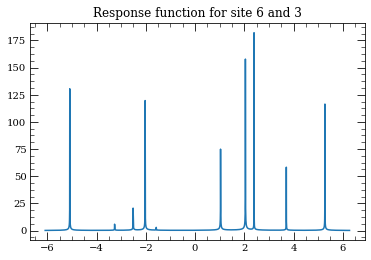

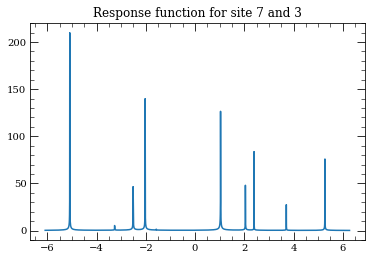

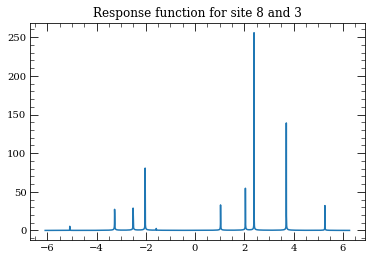

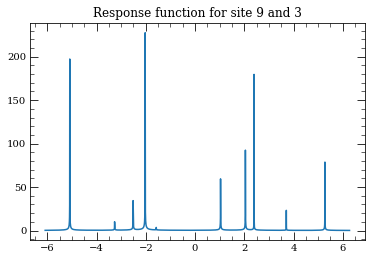

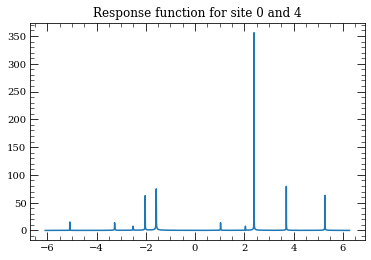

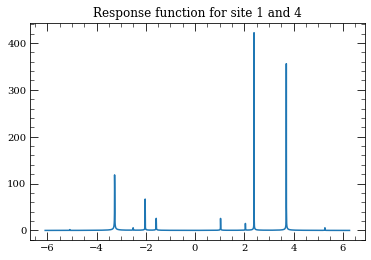

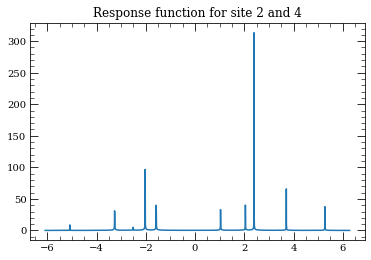

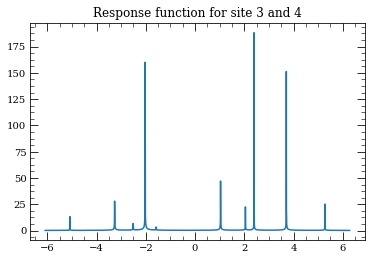

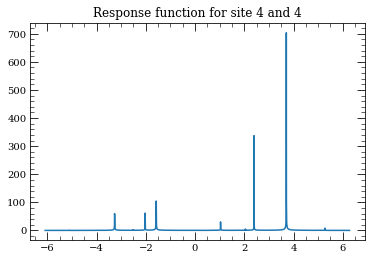

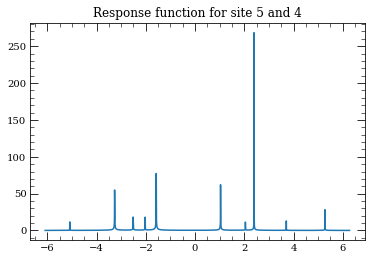

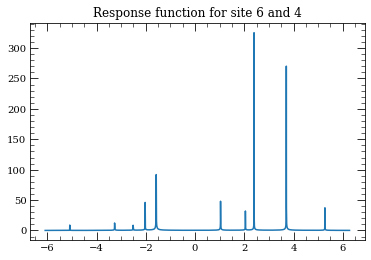

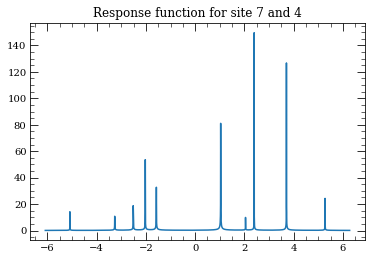

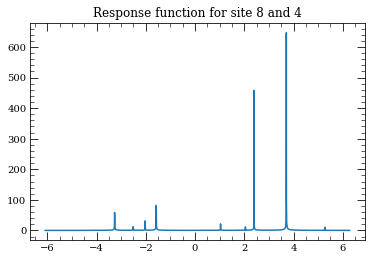

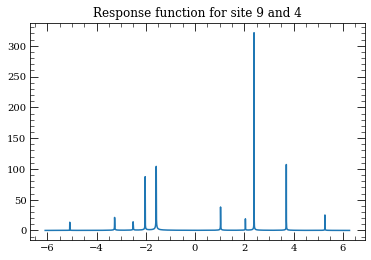

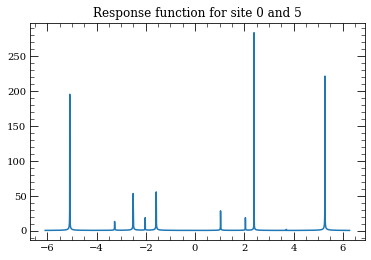

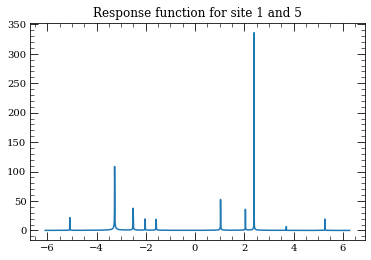

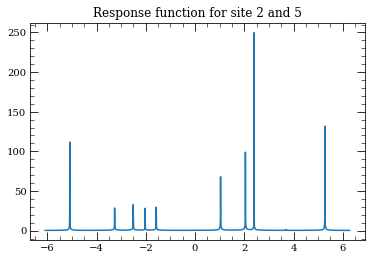

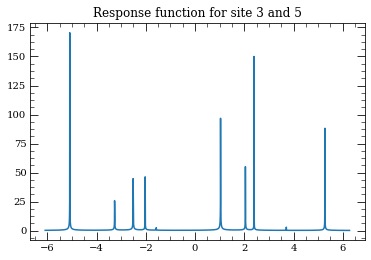

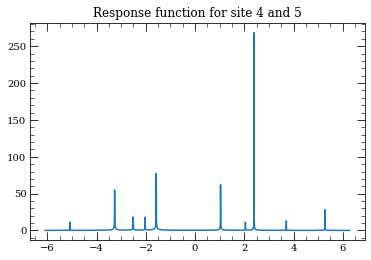

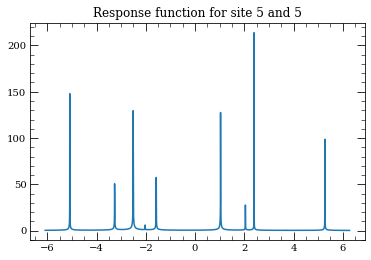

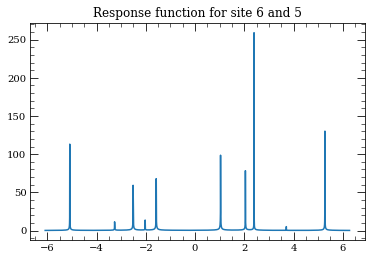

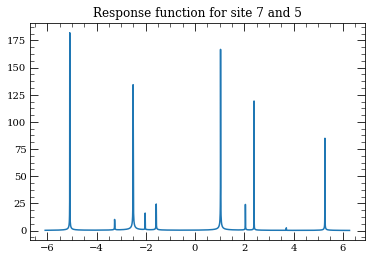

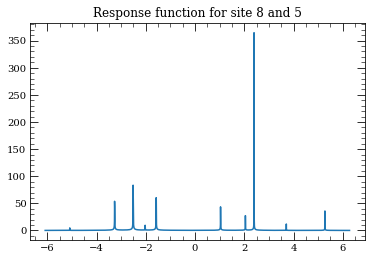

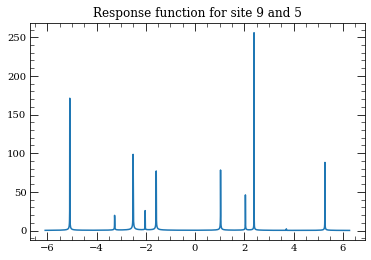

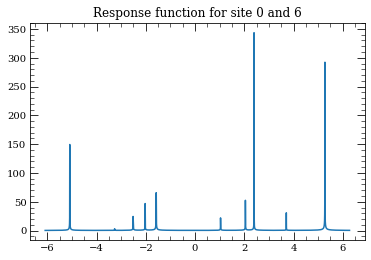

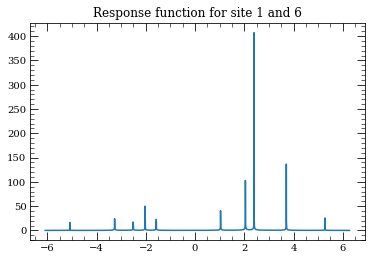

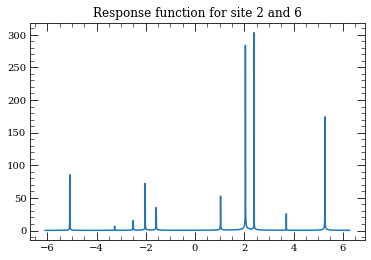

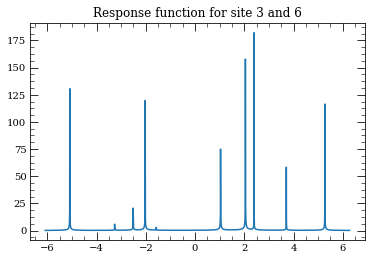

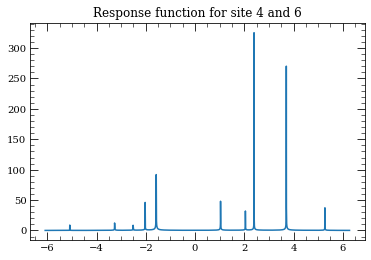

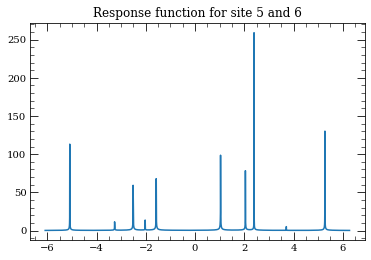

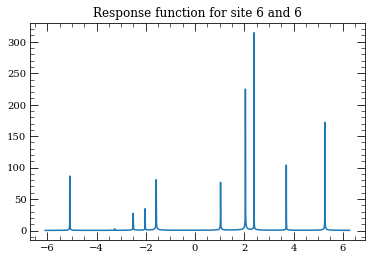

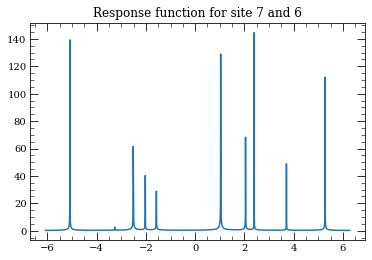

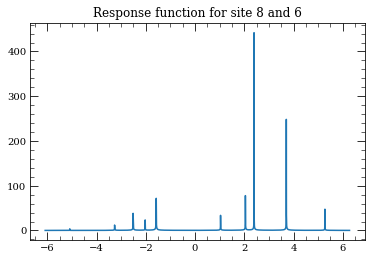

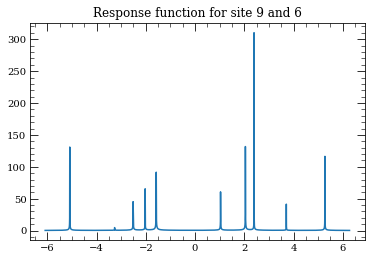

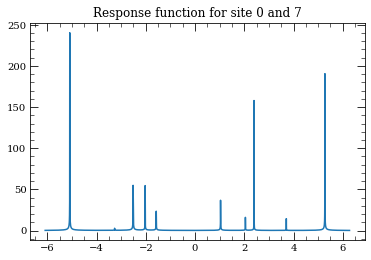

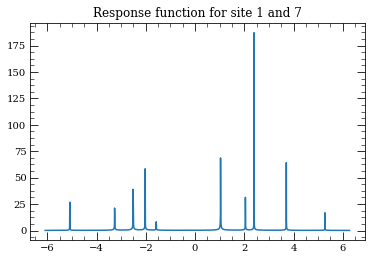

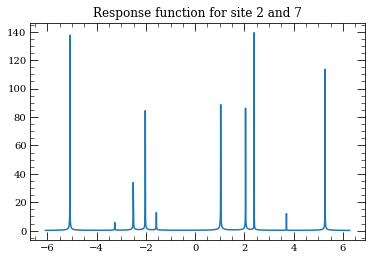

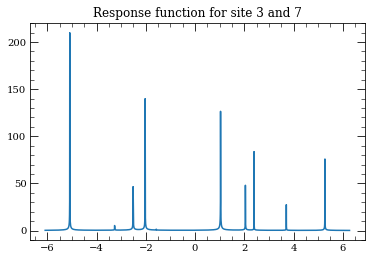

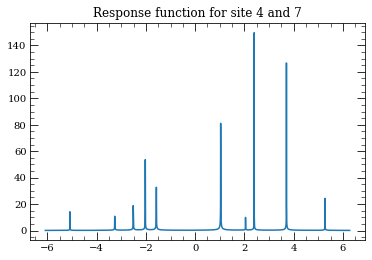

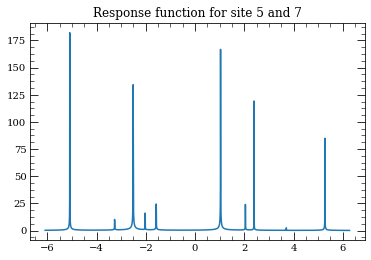

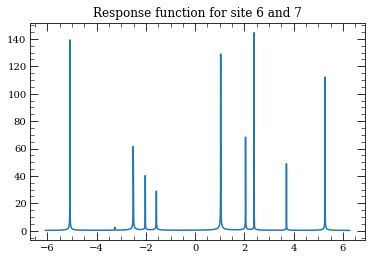

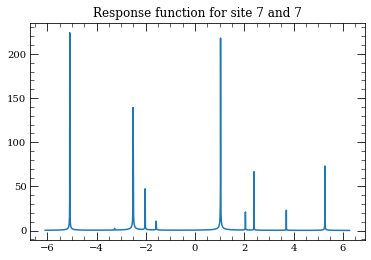

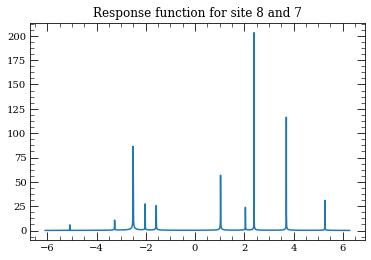

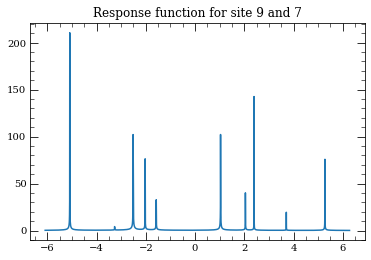

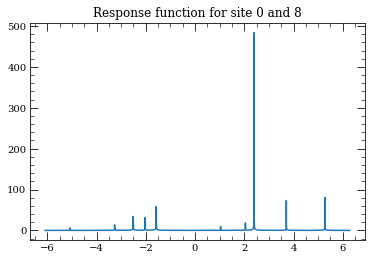

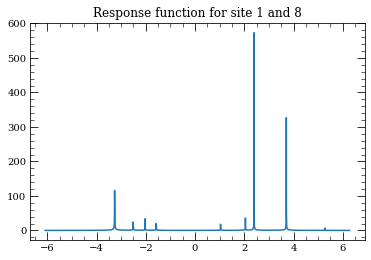

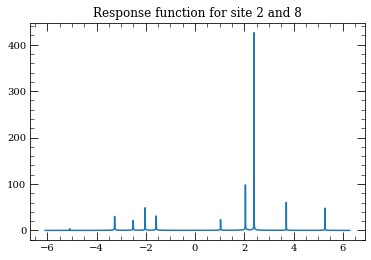

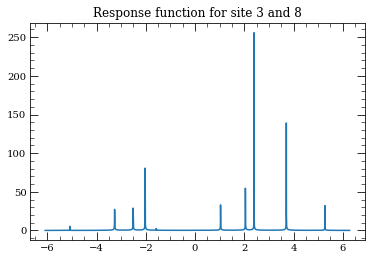

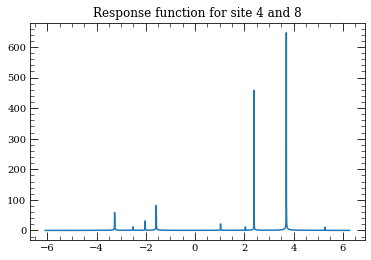

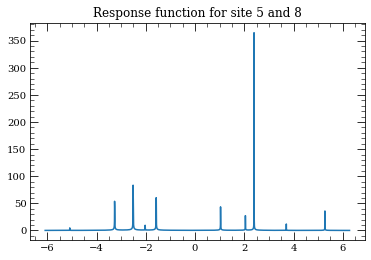

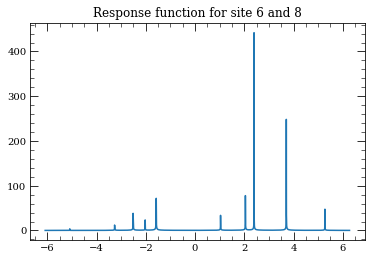

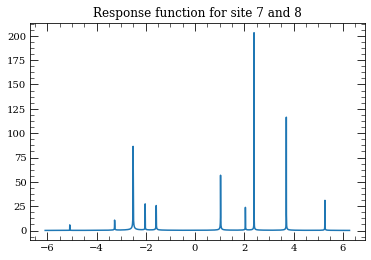

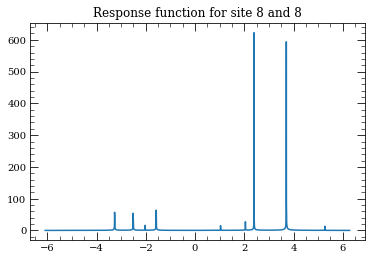

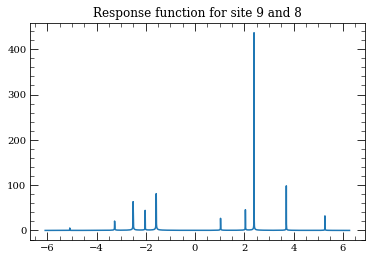

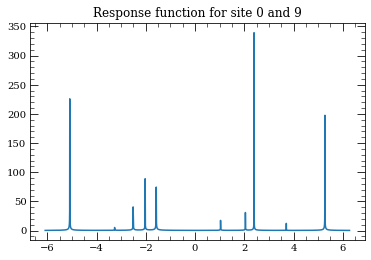

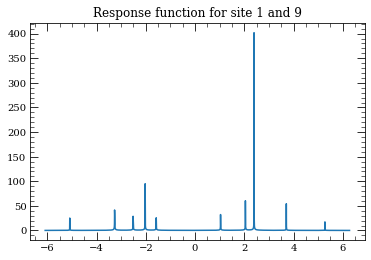

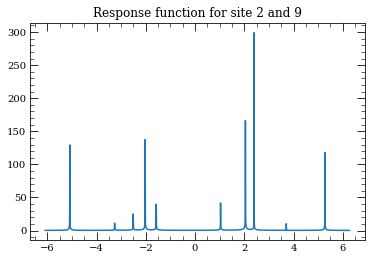

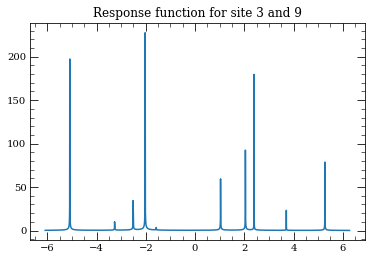

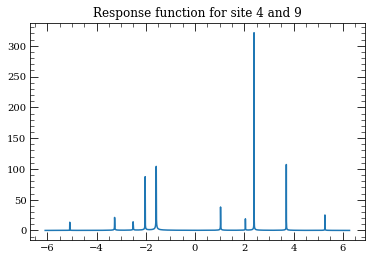

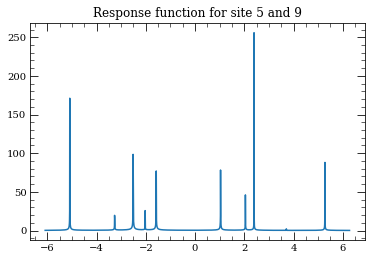

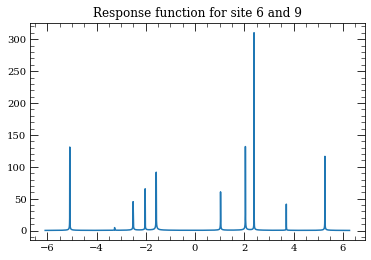

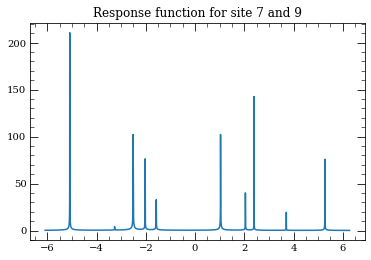

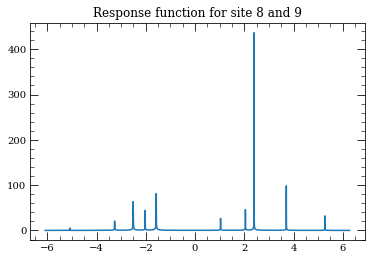

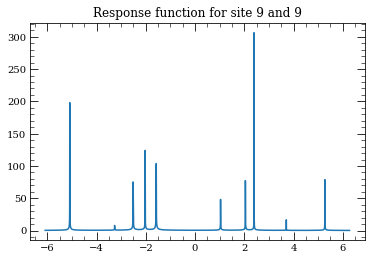

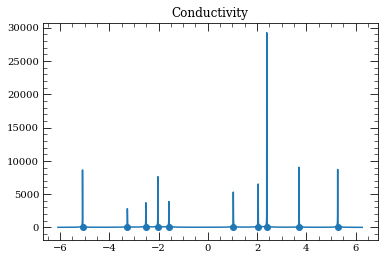

Calcing response function


In [31]:
M=1
P=-np.pi/2*1j
symm=True
sets=2
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
runHamiltonian(site_num,1,H,proj,obs_basis)

In [196]:
symm = True
atom_sets = 2     #How many coupling pairs
w1 = 1                #The first weight
w2 = 1               #The second weight
w3 = 1

1 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
2 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
3 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
4 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
5 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
6 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
7 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
8 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
9 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.28

<Figure size 1080x1440 with 0 Axes>

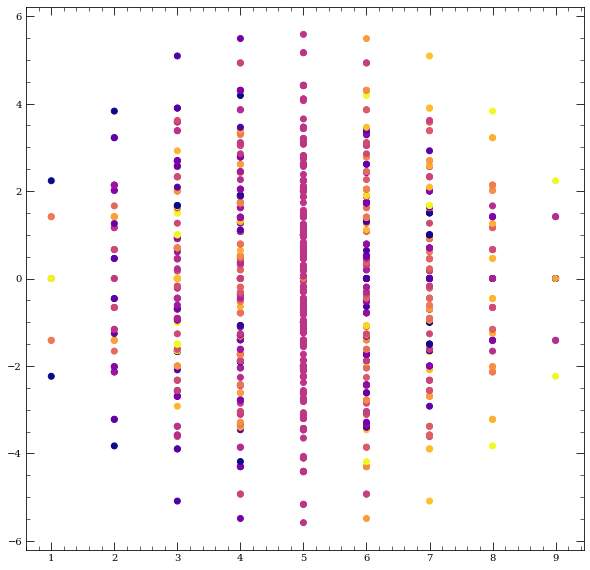

<Figure size 1080x1440 with 0 Axes>

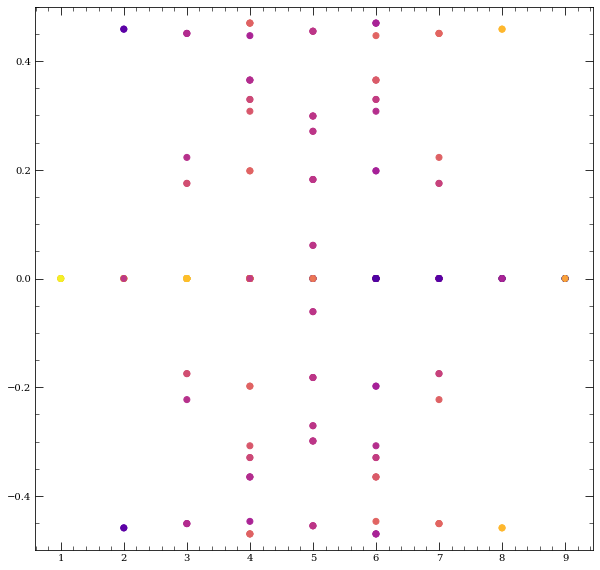

In [425]:
M=0
P=0
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
-4.992165926763765


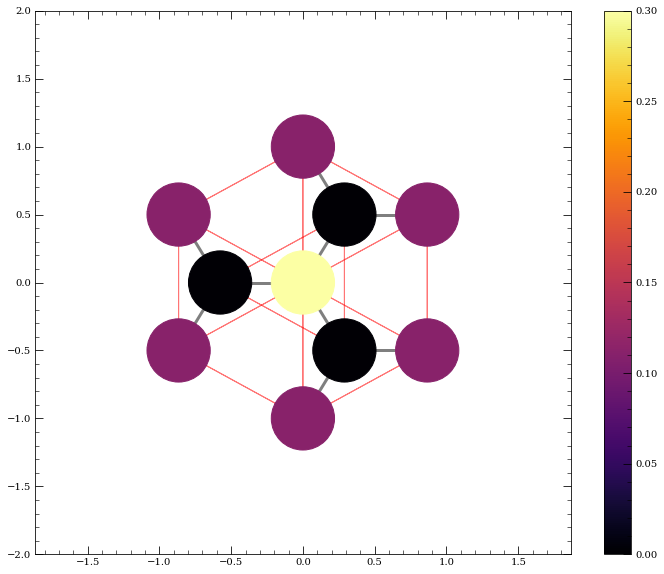

-3.1947623264350247


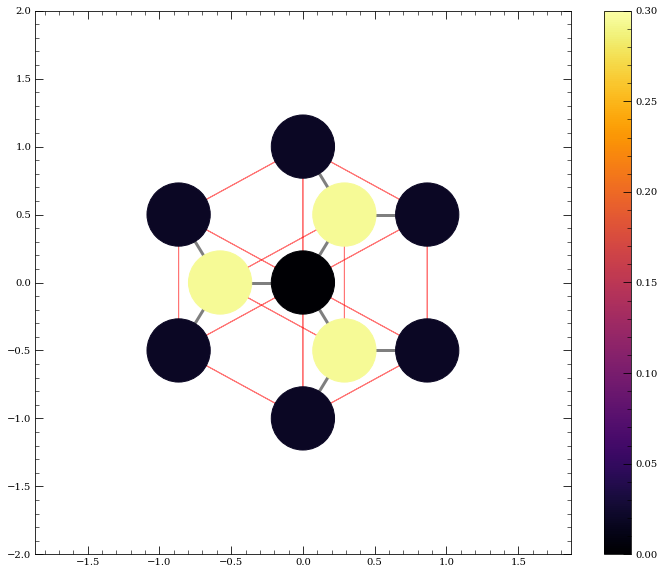

-2.179974853612322


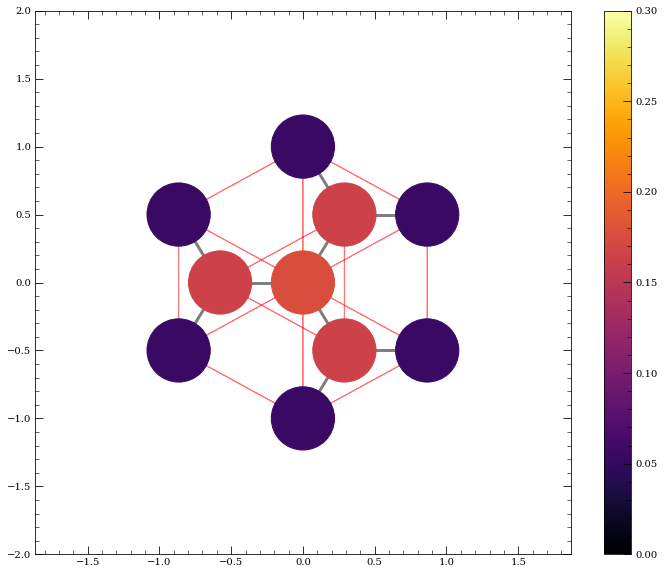

-1.9716974842595905


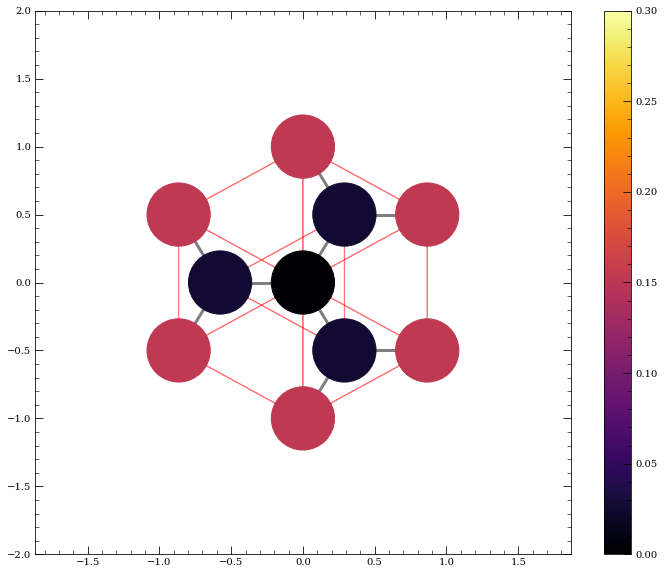

-1.4976342041759025


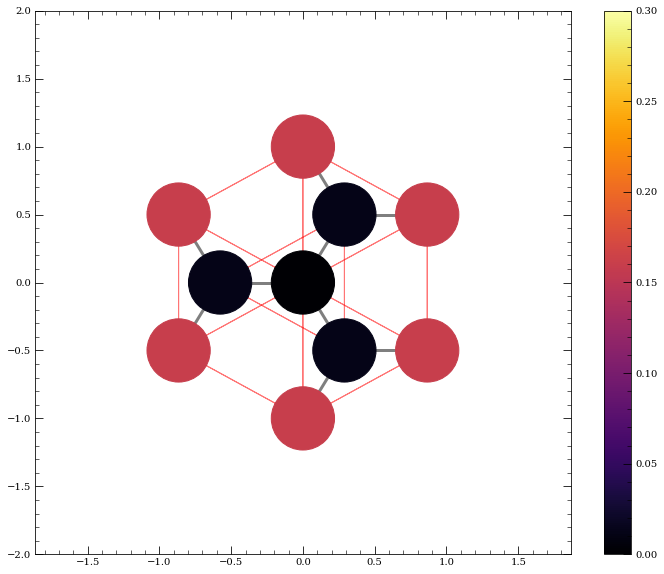

1.4976342041759048


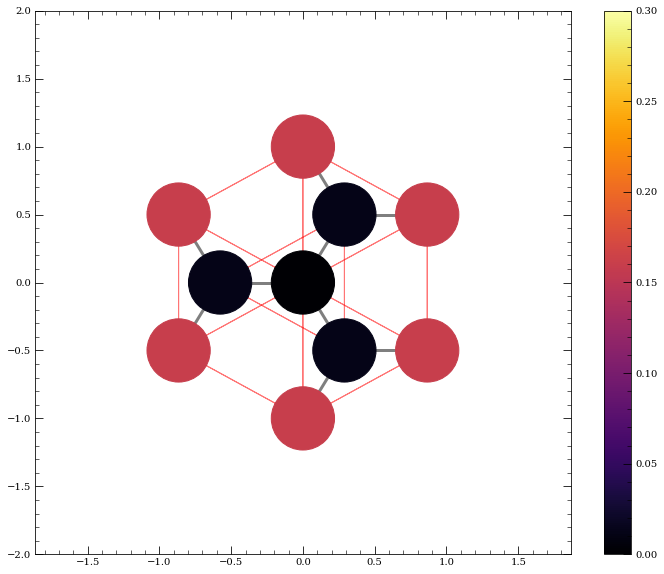

1.971697484259599


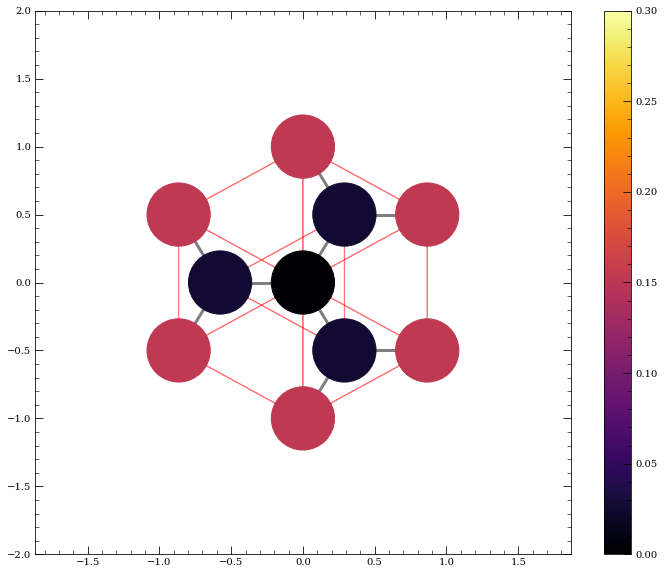

2.179974853612324


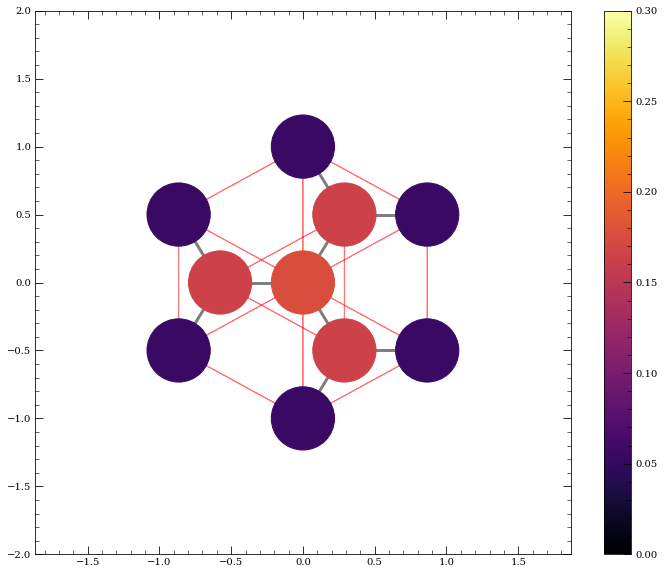

3.1947623264350224


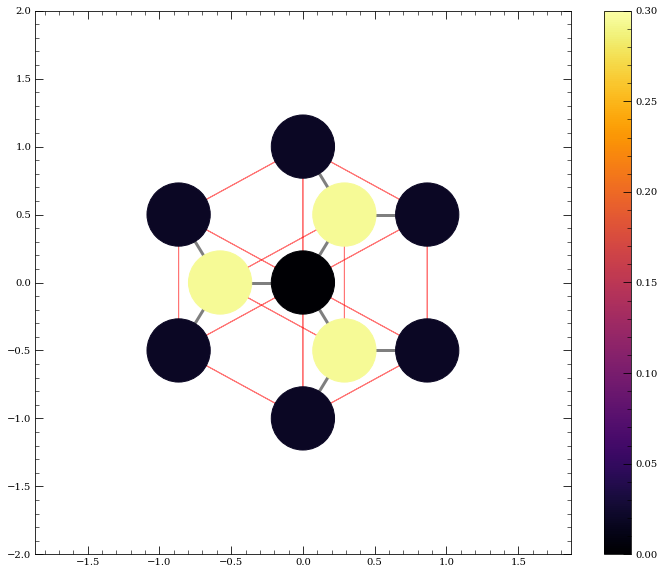

4.992165926763787


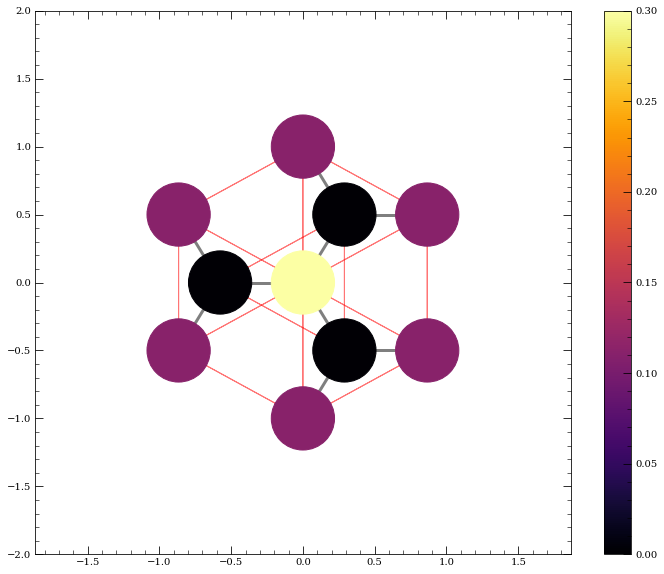

In [513]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
2 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
3 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
4 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
5 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
6 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
7 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
8 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
9 particle basis
0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.28

<Figure size 1080x1440 with 0 Axes>

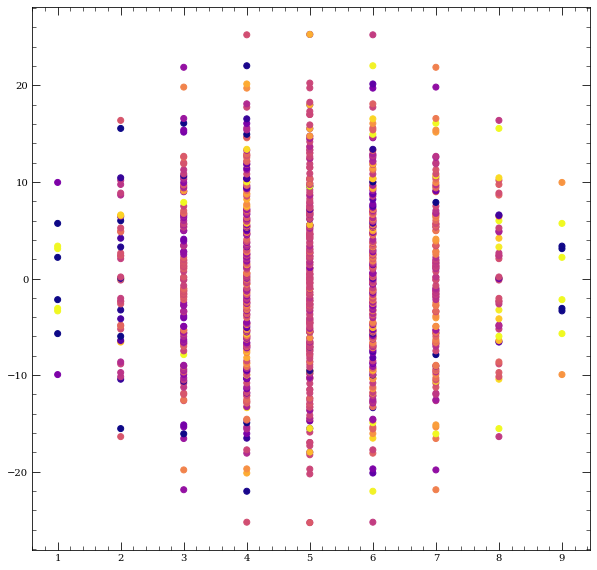

<Figure size 1080x1440 with 0 Axes>

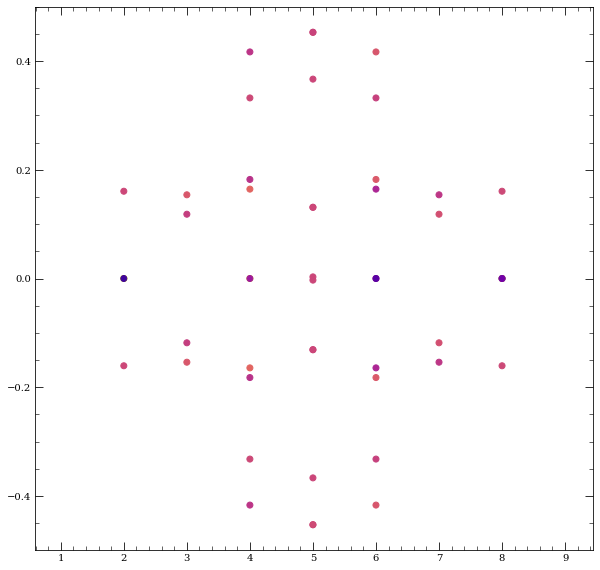

In [427]:
M=0
P=np.pi*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

(array([0.00768883, 2.00804905]), array([0.00313008, 2.00795411]))

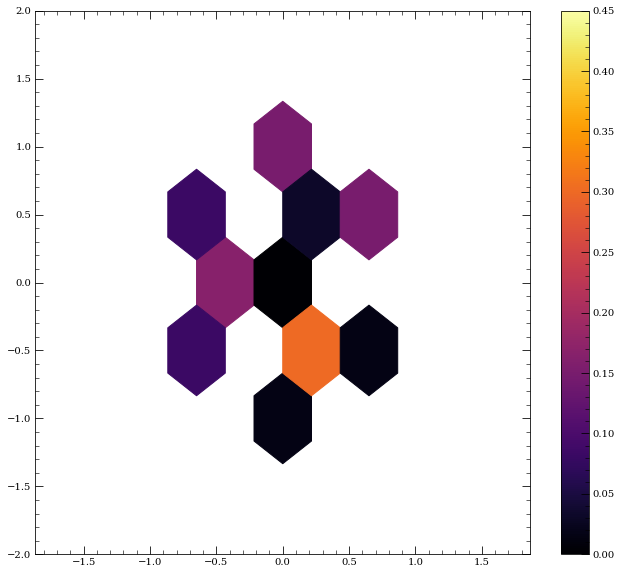

In [431]:
state = eVecs[1]+eVecs[8]
periods =1           #How many time periods
step = 50
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)

-5.086029713428715


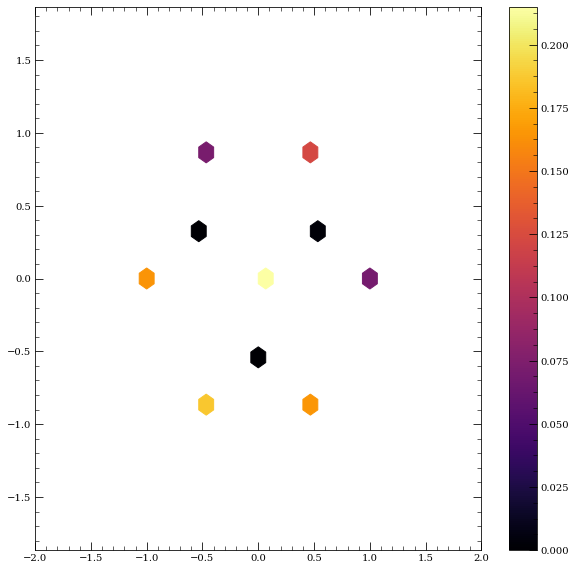

-3.264340807967643


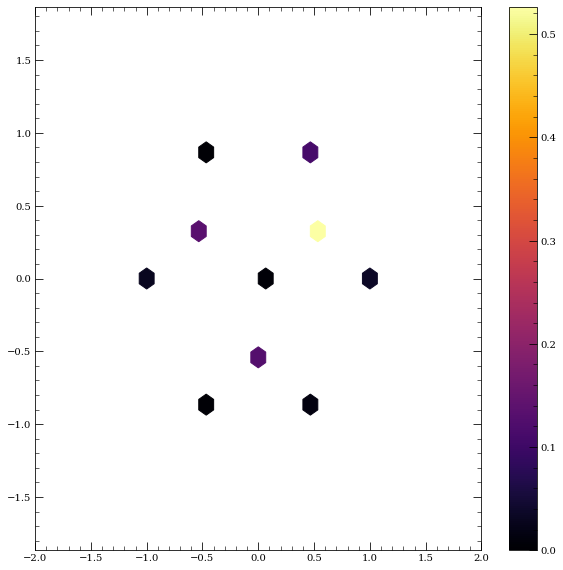

-2.5126579632016575


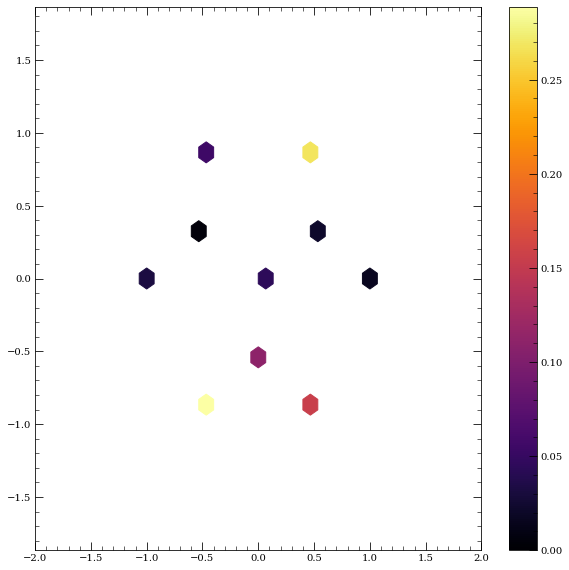

-2.026043545111885


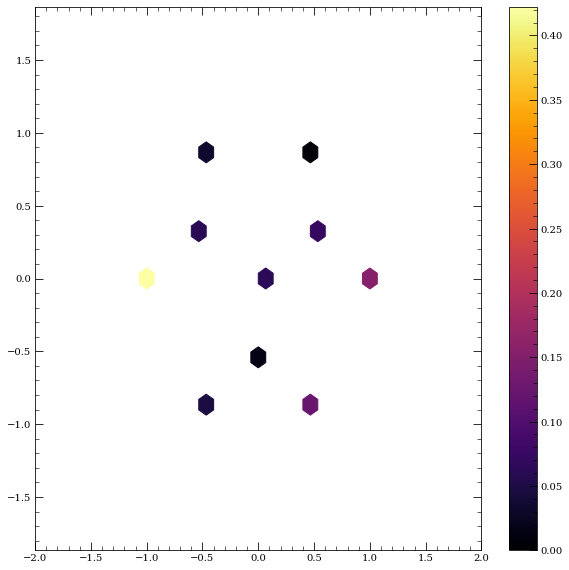

-1.5769429192258144


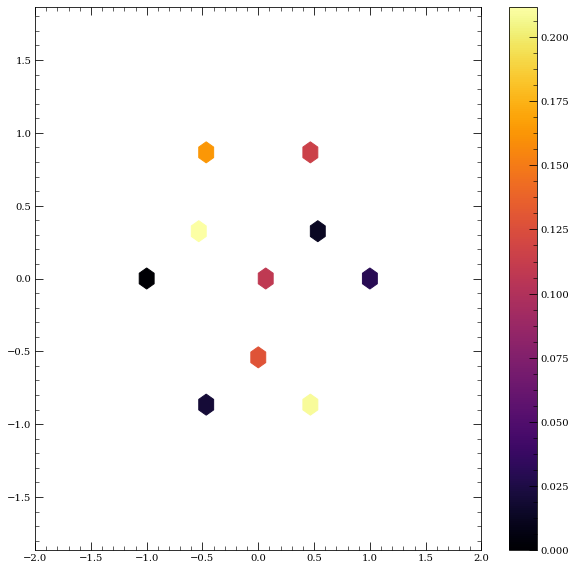

1.0383110686010886


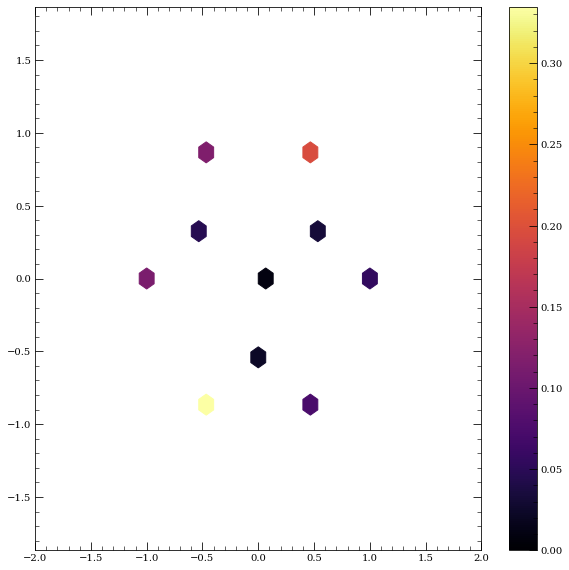

2.046939309624225


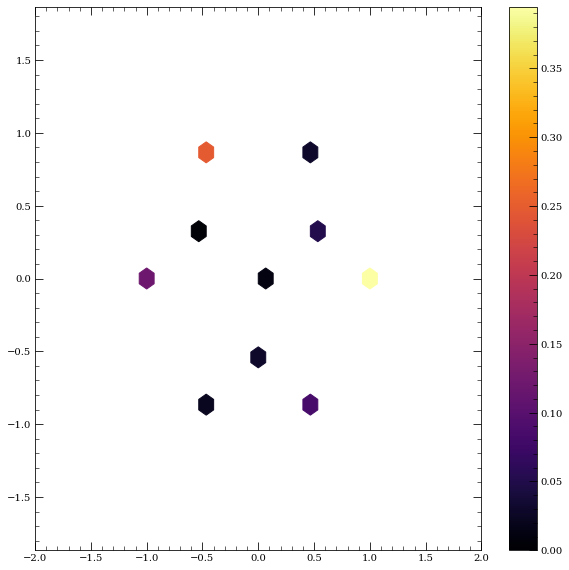

2.397335870884821


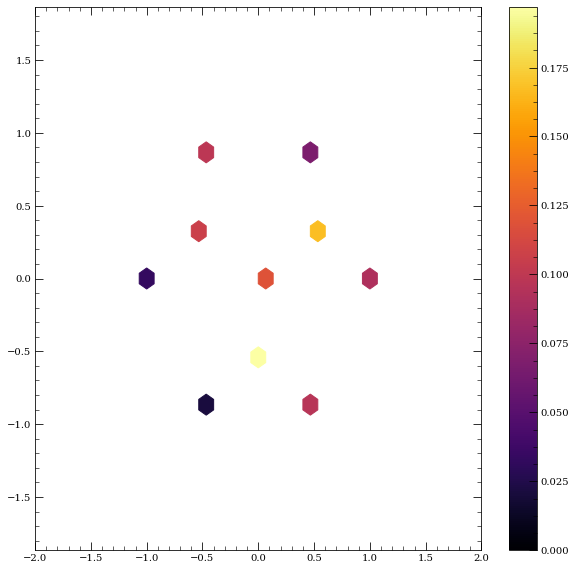

3.7084209496531697


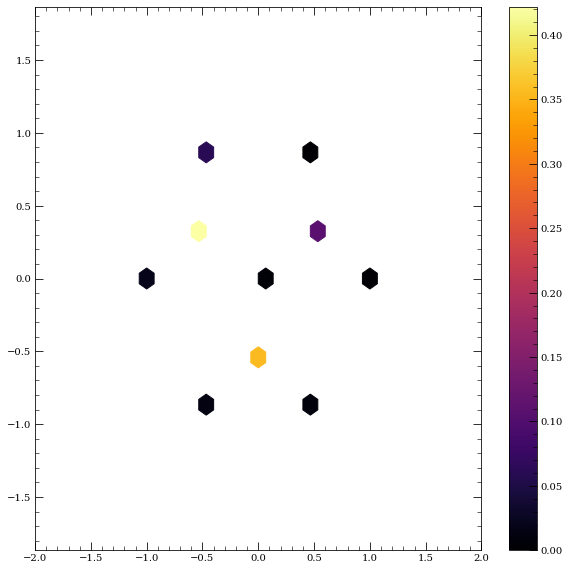

5.2750077501723736


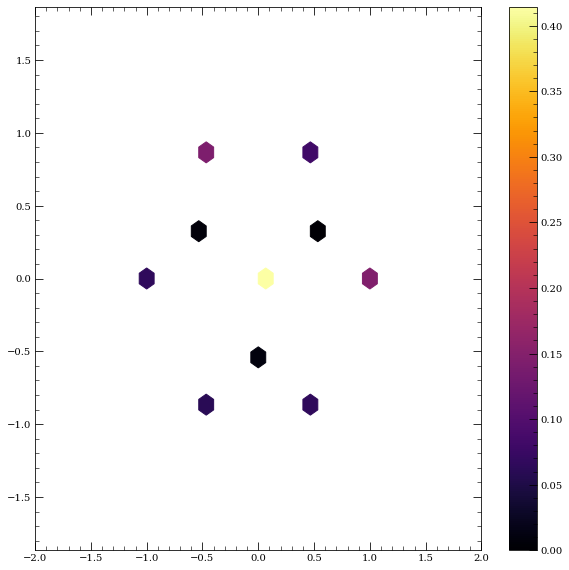

In [353]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

Solving


/Users/jordankemp/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Calcing response function


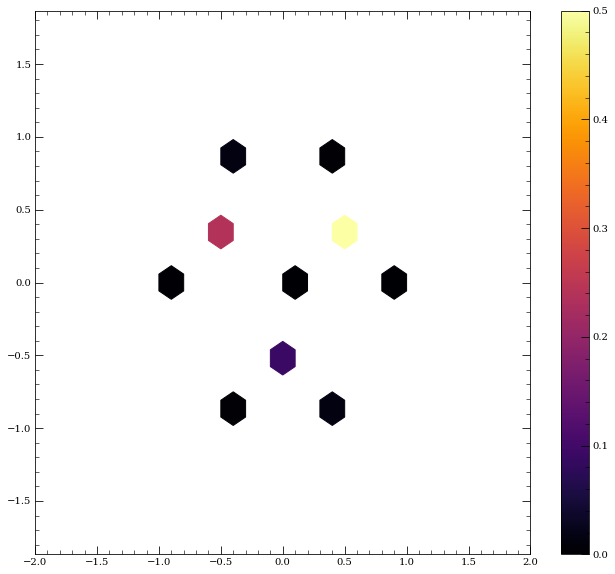

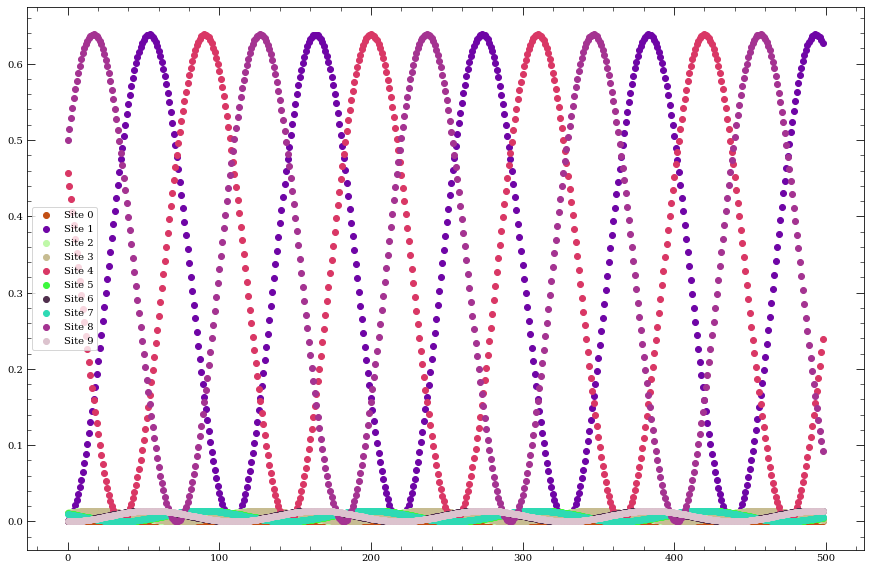

In [98]:
state = eVecs[1]+eVecs[8]
periods =1           #How many time periods
step = 50
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)

Solving


/Users/jordankemp/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Calcing response function


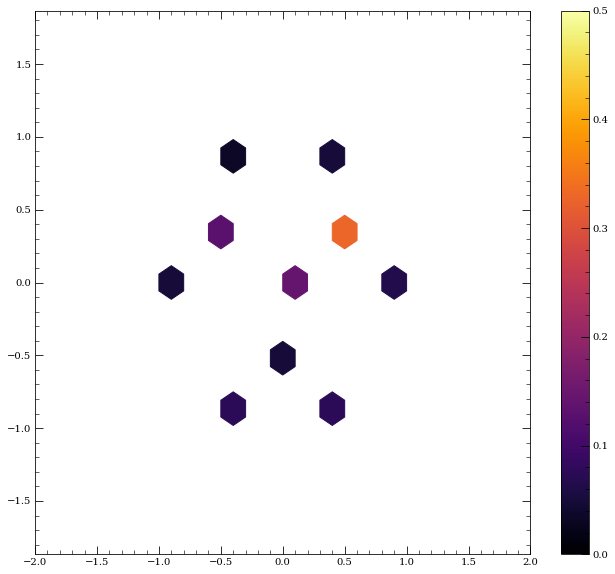

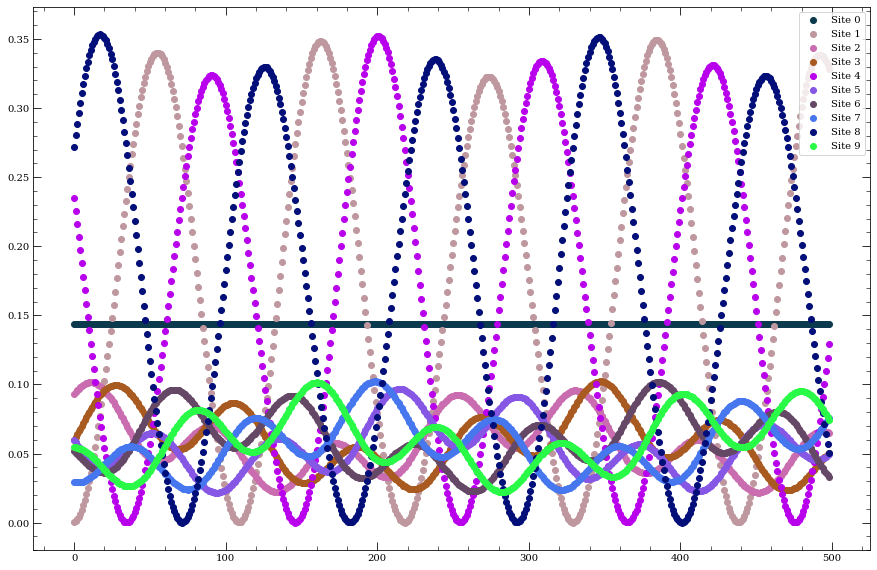

In [99]:
state = eVecs[1]+eVecs[8]+4/3*eVecs[0]
periods =2.5           #How many time periods
step = 500
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

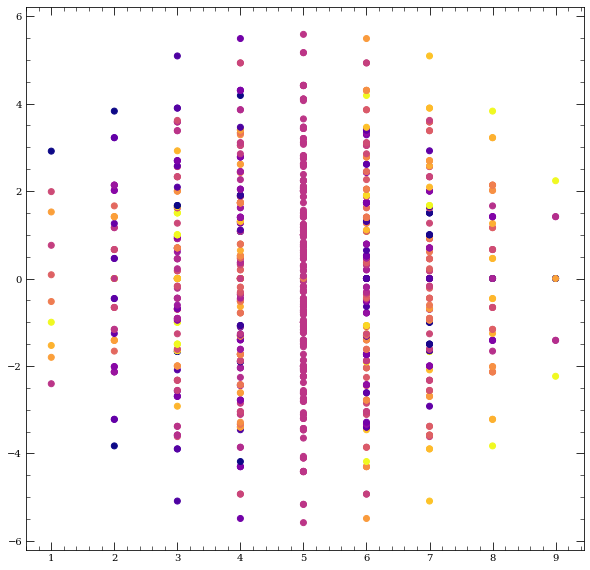

<Figure size 1080x1440 with 0 Axes>

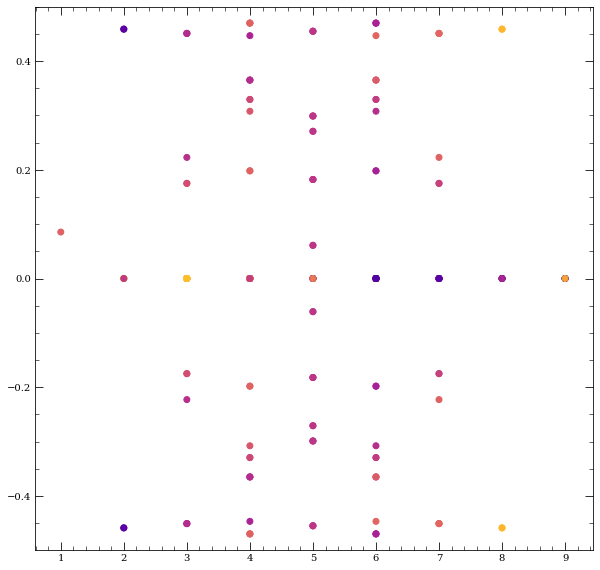

In [111]:
M=1
P=0
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-2.4066324966335775


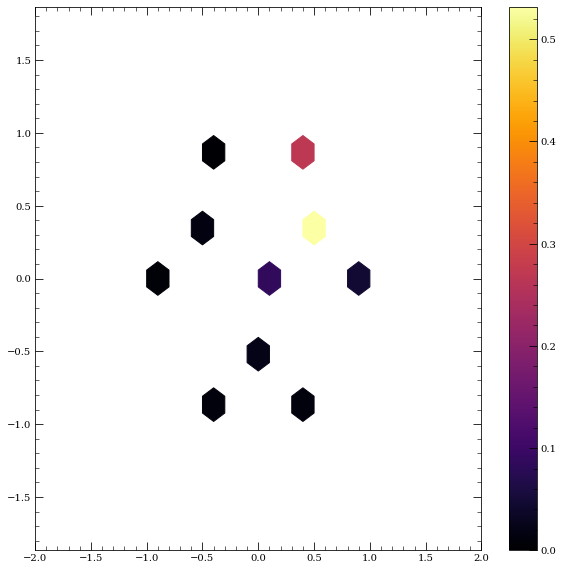

-1.8025929764101494


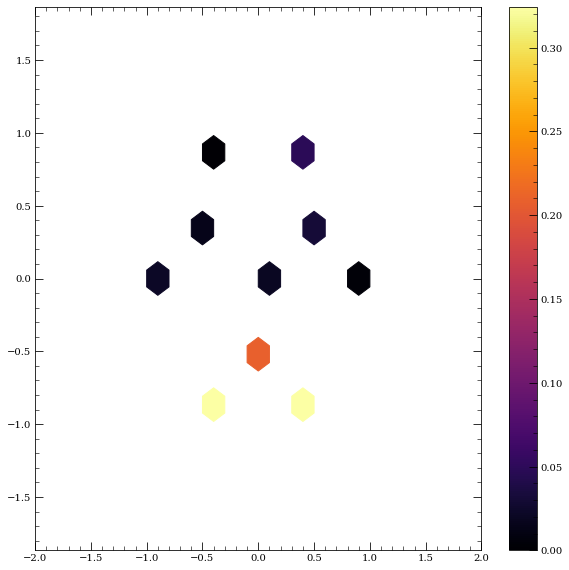

-1.531559864156302


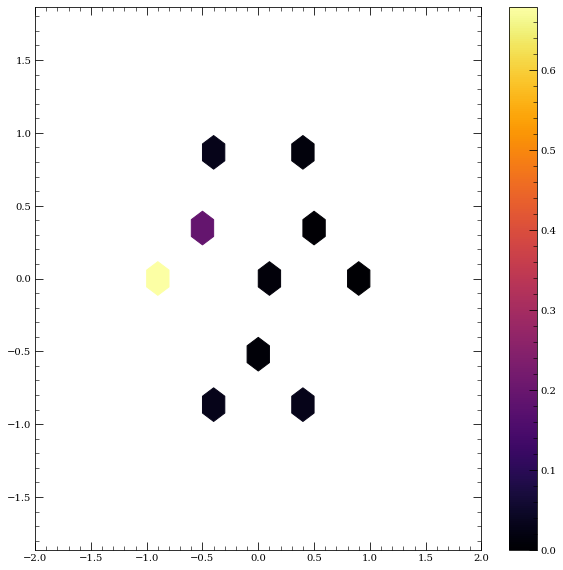

-1.0000000000000004


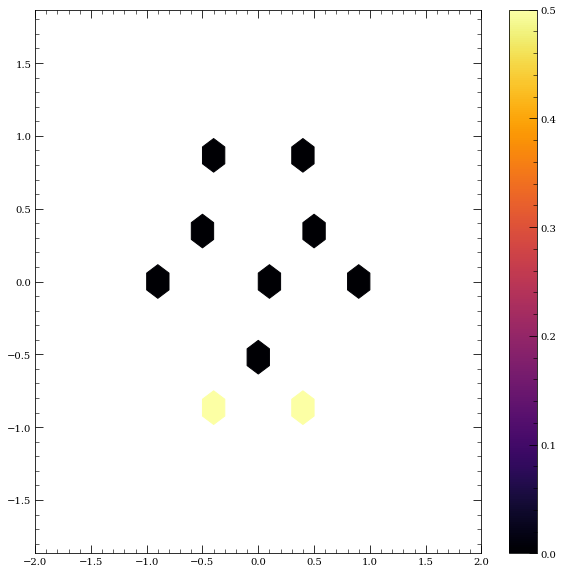

-0.5264428998548081


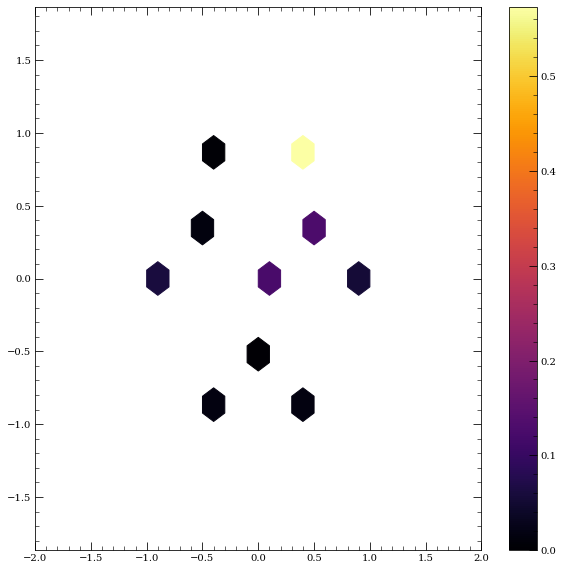

0.0854518142219387


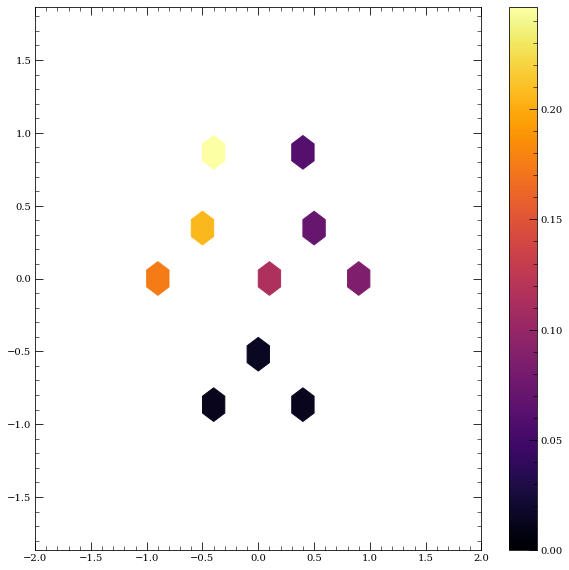

0.759478319263589


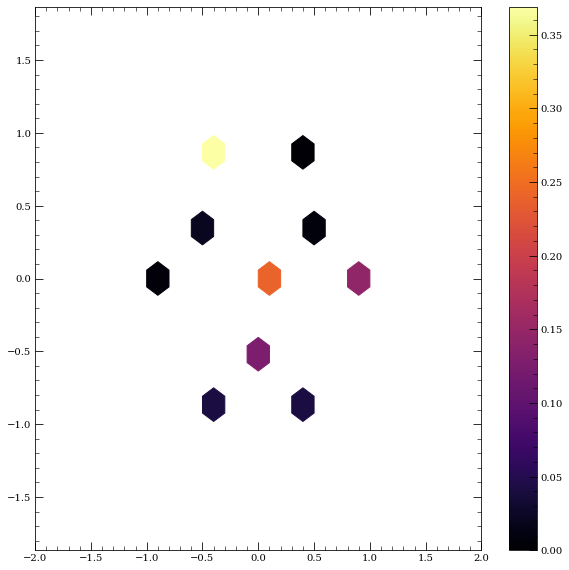

1.5219735063186564


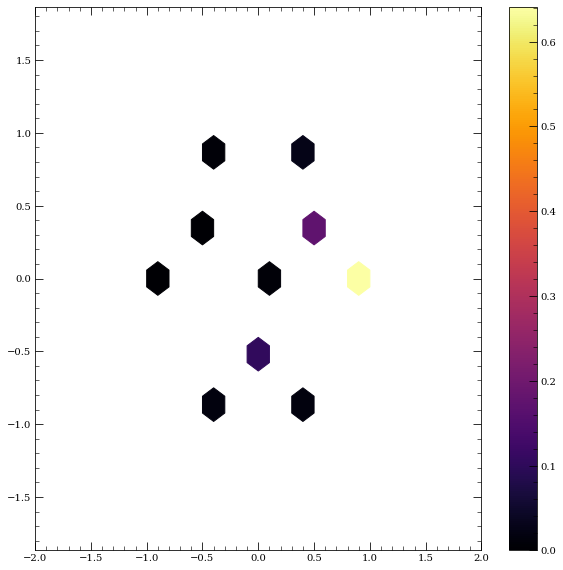

1.9870977350324193


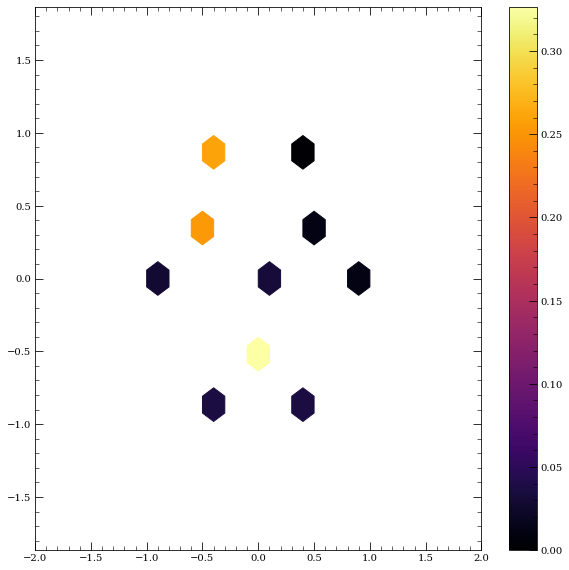

2.9132268622182247


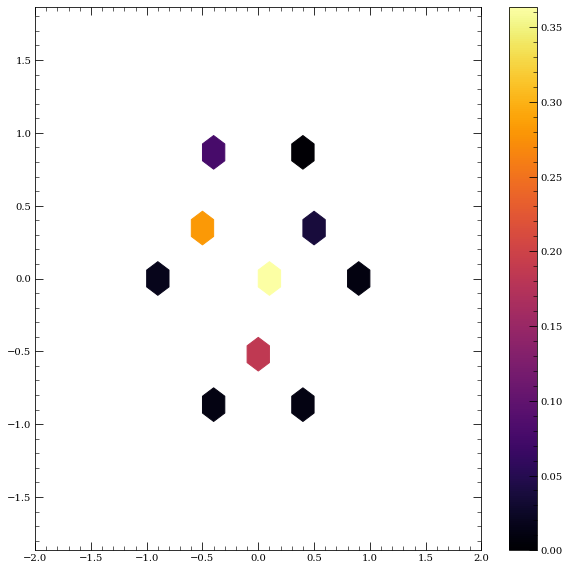

In [113]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

Solving


/Users/jordankemp/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Calcing response function


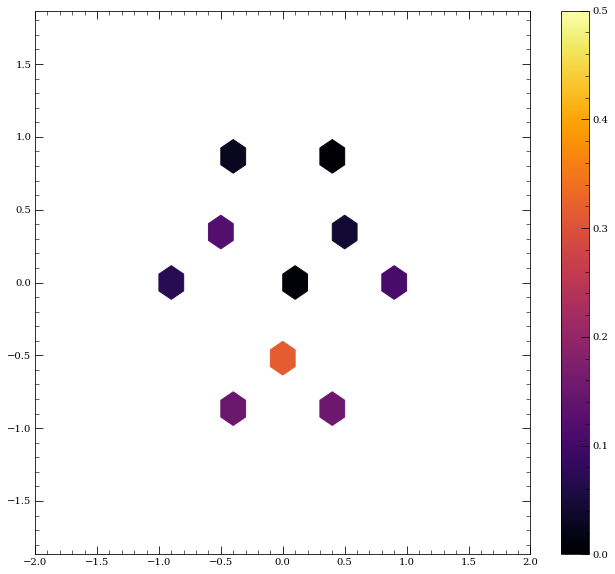

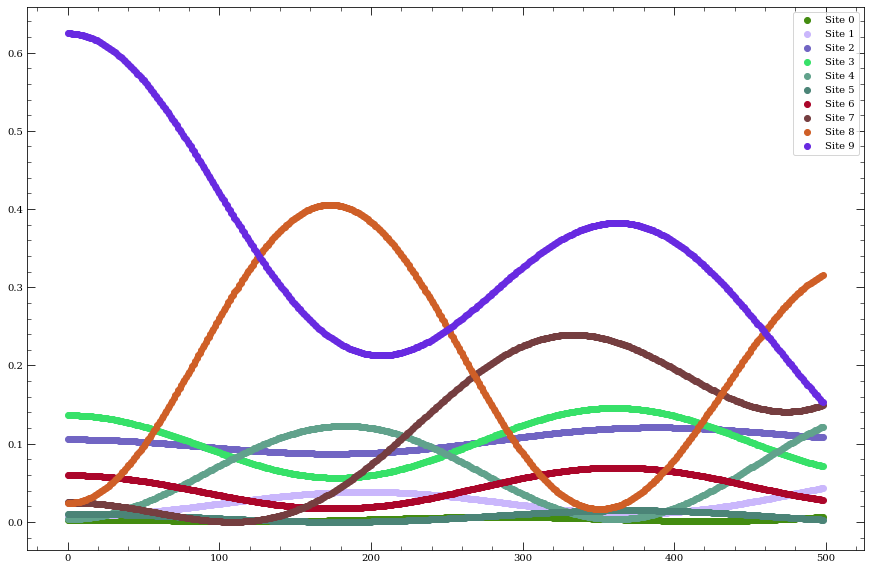

In [107]:
state = eVecs[1]+eVecs[2]+eVecs[3]+eVecs[7]+eVecs[8]
periods =10           #How many time periods
step = 500
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)

In [103]:
eVecs[1]

Quantum object: dims = [[2], [1]], shape = (10, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.35355339]
 [ 0.35355339]
 [ 0.5       ]
 [-0.35355339]
 [ 0.35355339]
 [-0.5       ]
 [ 0.        ]]

-3.8287151965166077


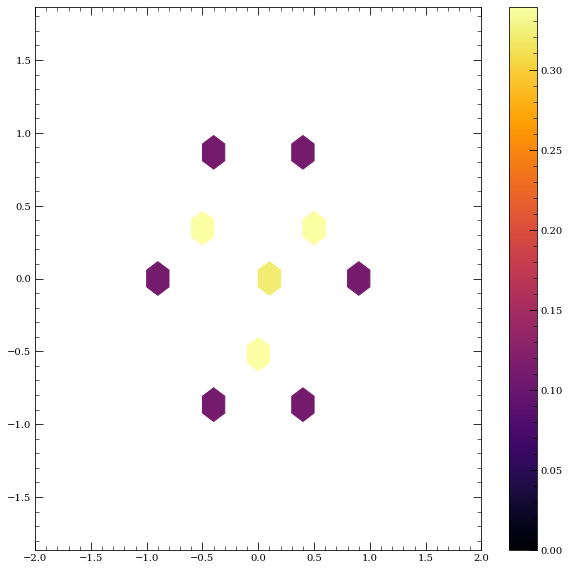

-3.220876918423111


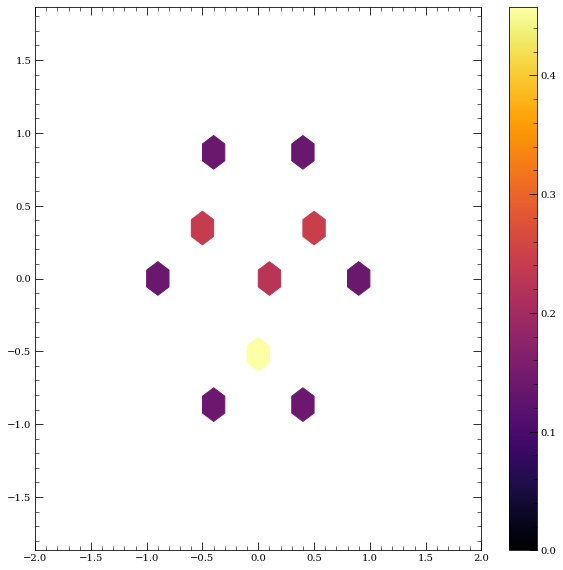

-3.2208769184231025


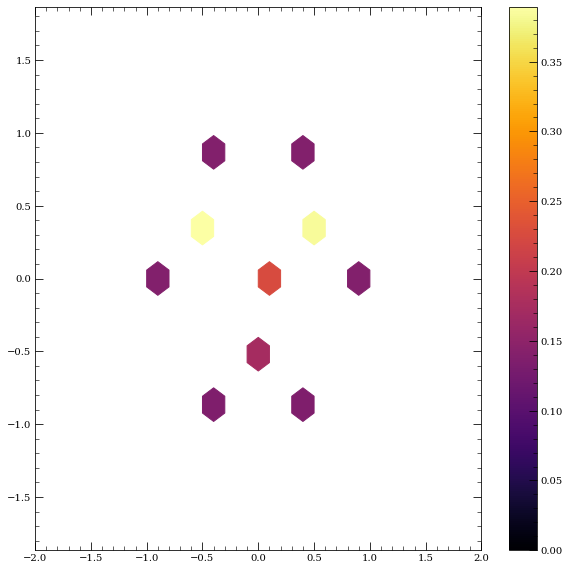

-2.135779205069858


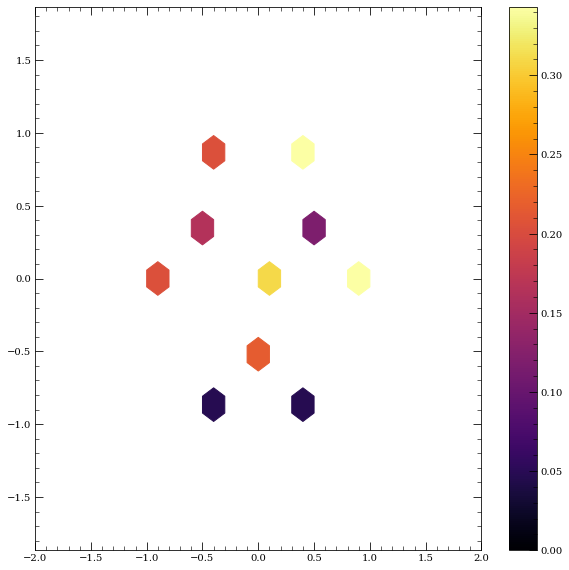

-2.1357792050698534


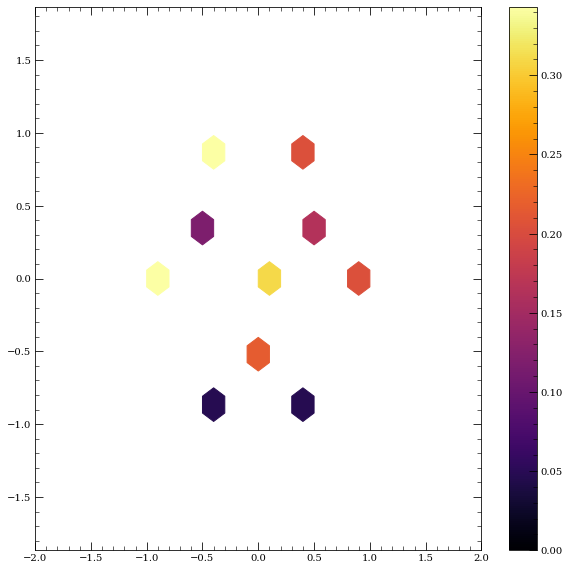

-2.1357792050698485


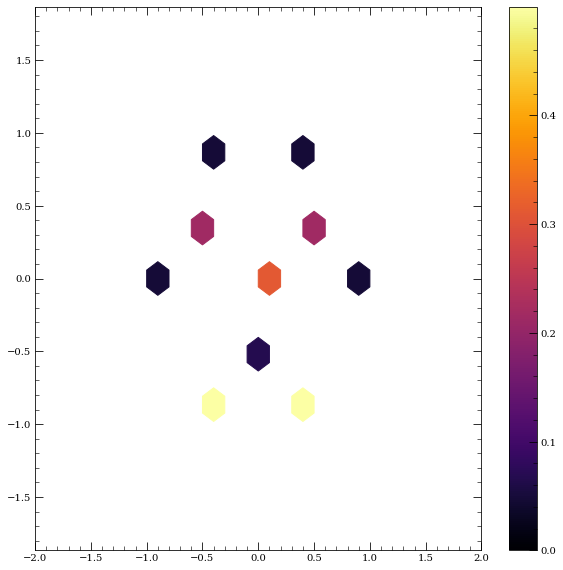

-2.01557920428876


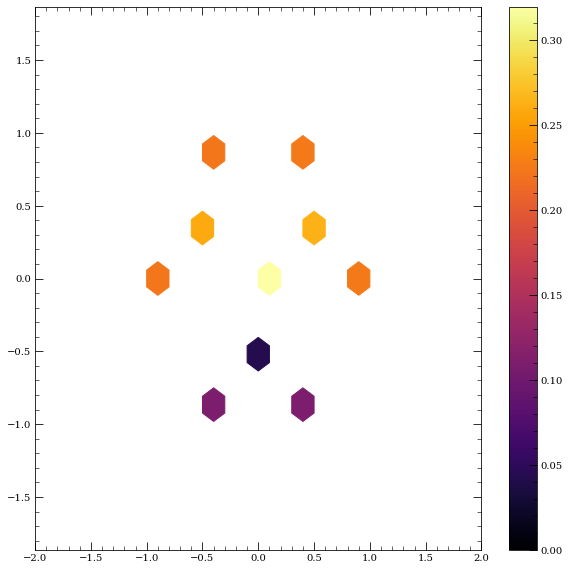

-2.0155792042887537


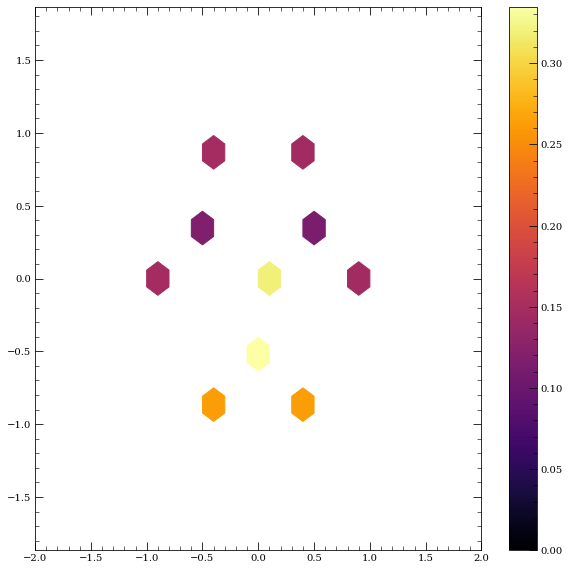

-1.6606837081188632


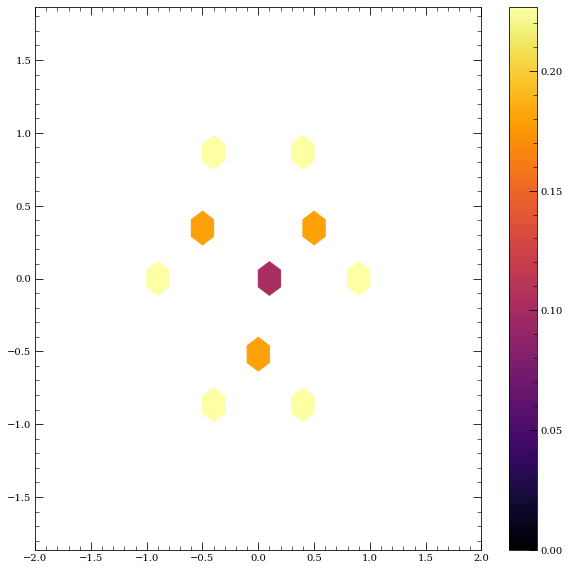

-1.4142135623730965


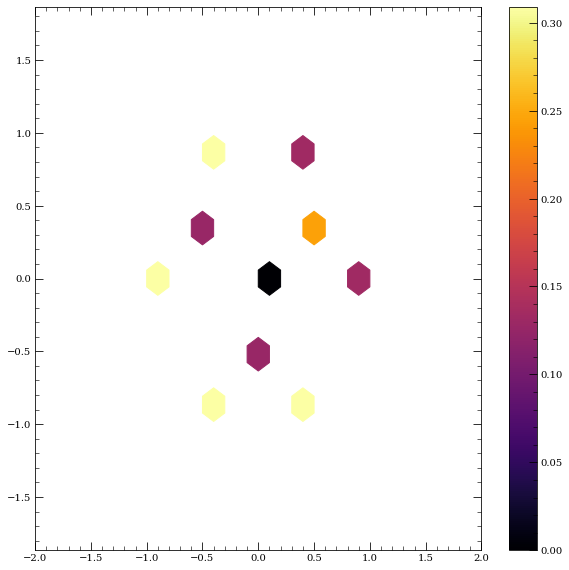

-1.4142135623730951


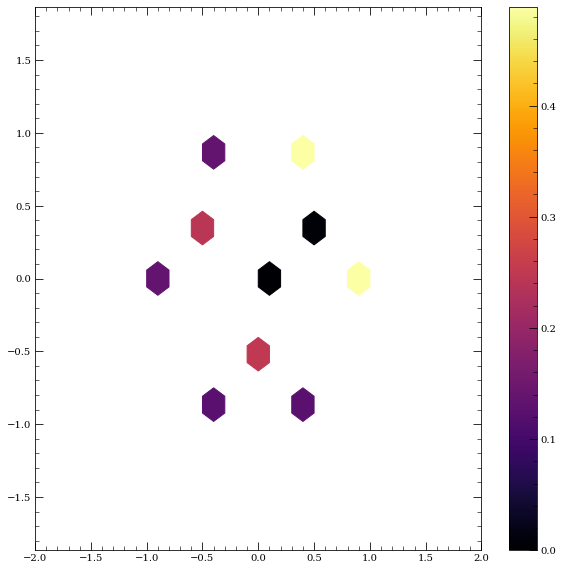

-1.4142135623730887


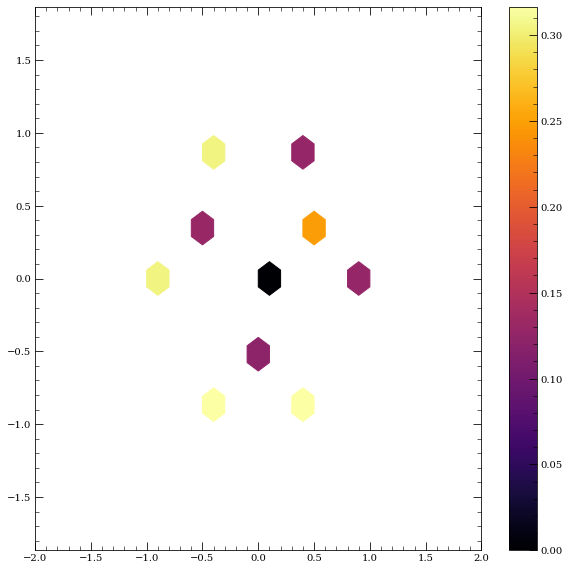

-1.2582009241577228


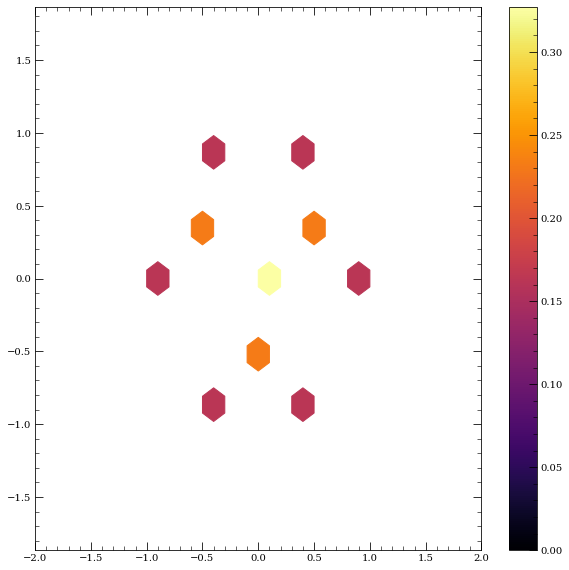

-1.163159258892663


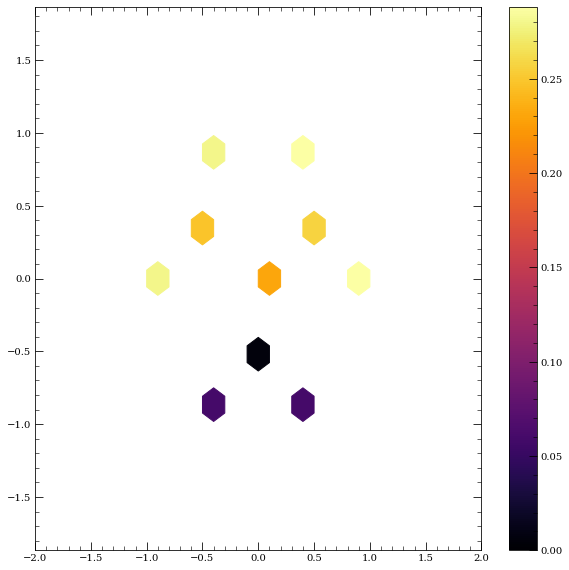

-1.1631592588926563


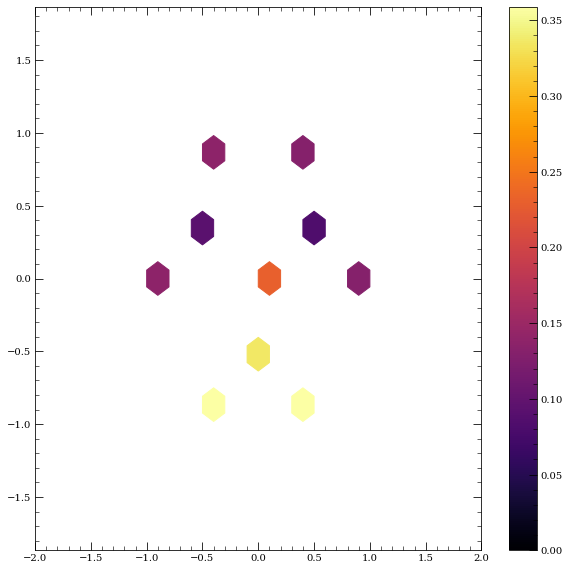

-0.6621534468619567


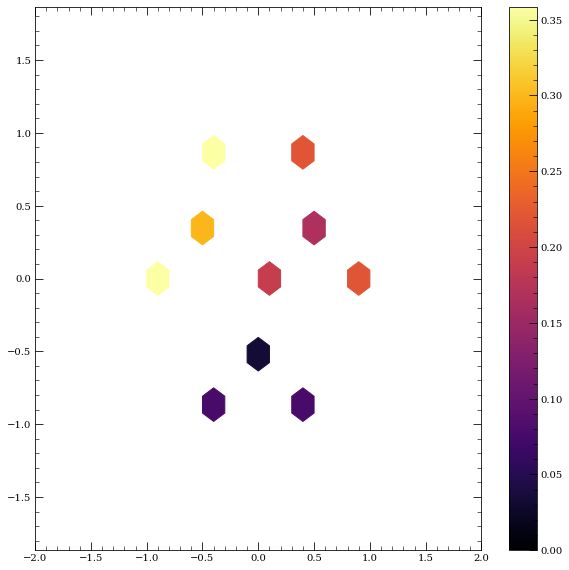

-0.6621534468619534


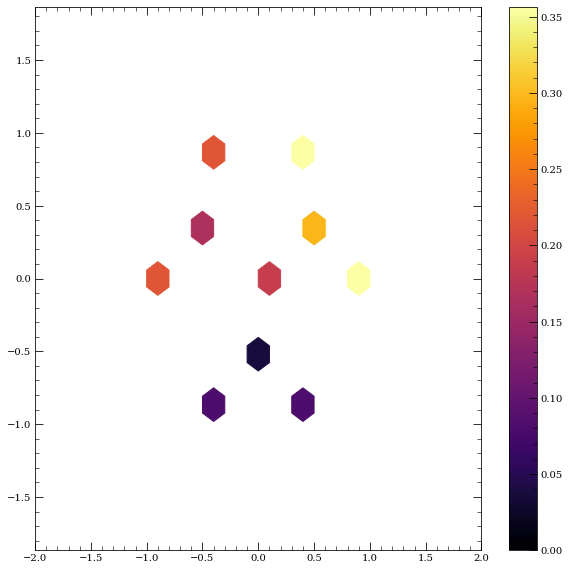

-0.6621534468619525


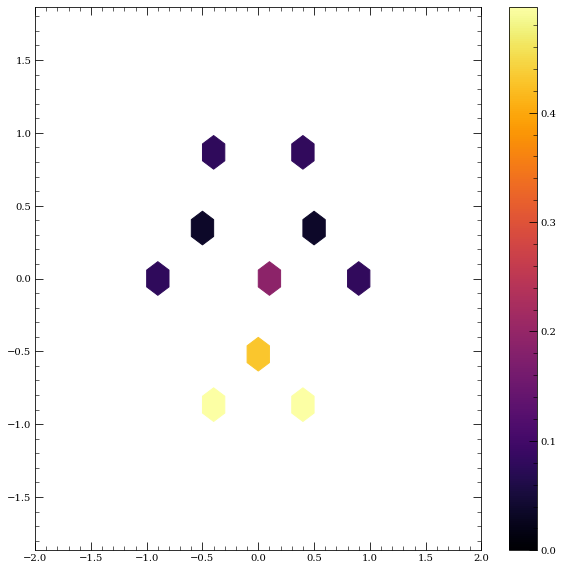

-0.4587514425701806


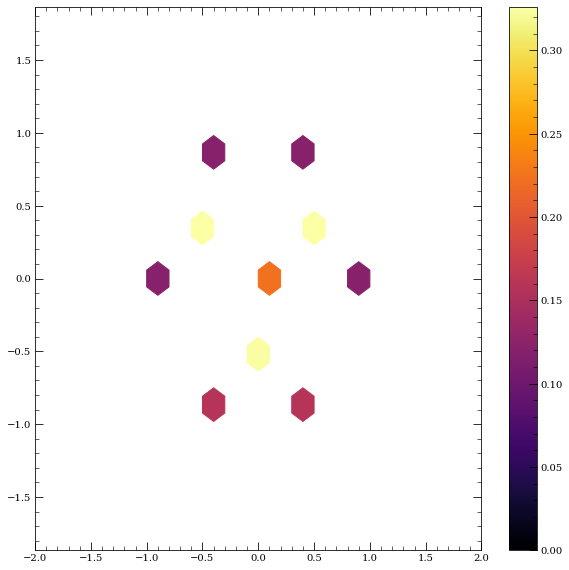

-0.45875144257017725


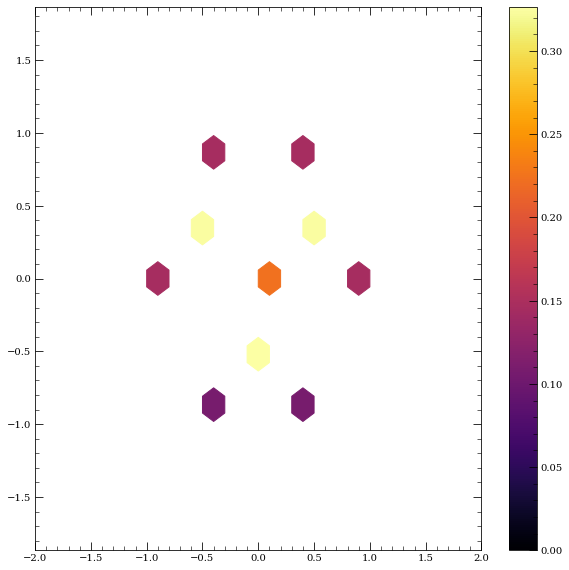

-1.7553332585808065e-16


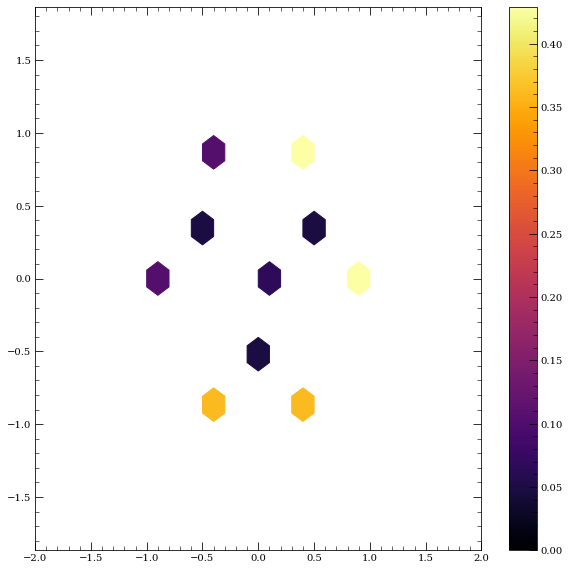

-7.103118882406812e-17


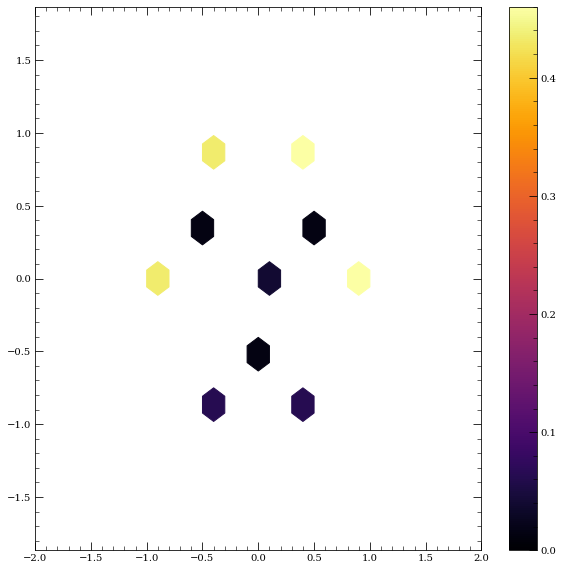

-1.0453036459140484e-17


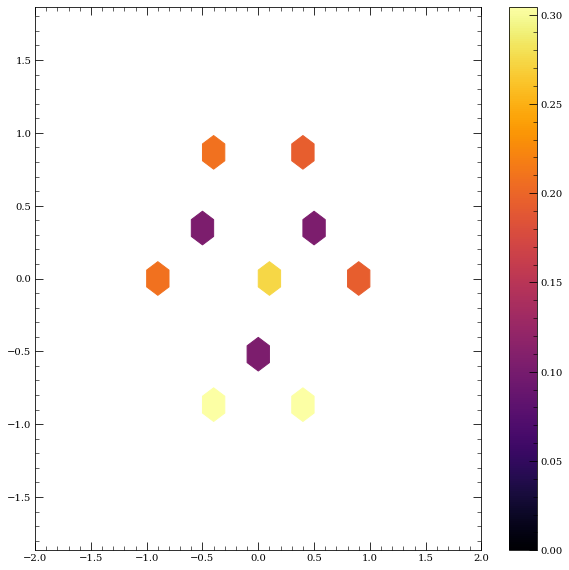

4.0810005826651253e-16


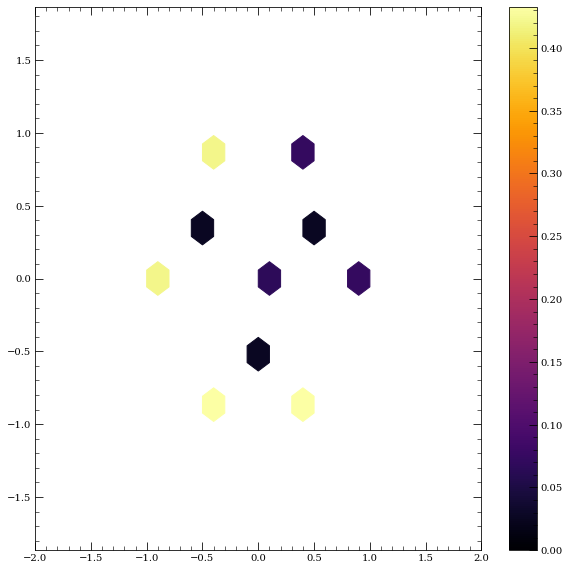

3.516326536847299e-15


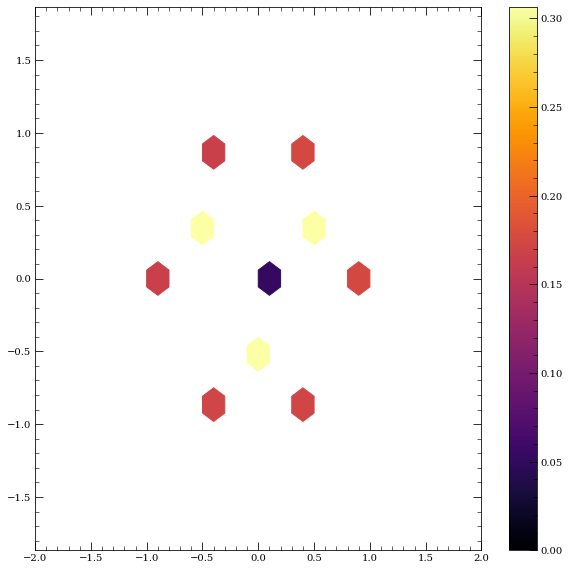

0.4587514425701753


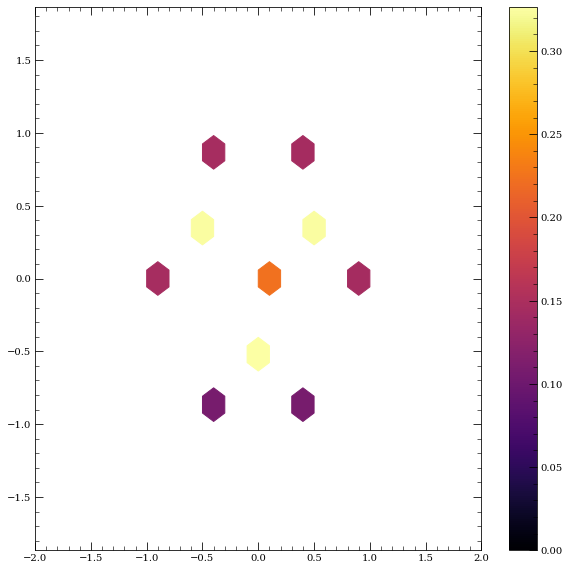

0.4587514425701812


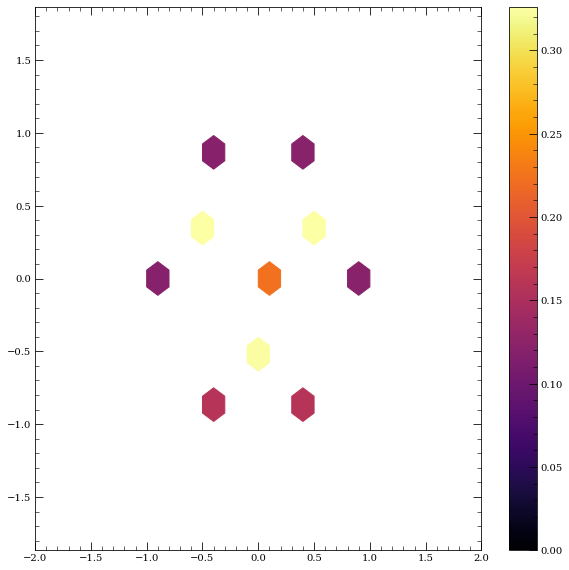

0.6621534468619578


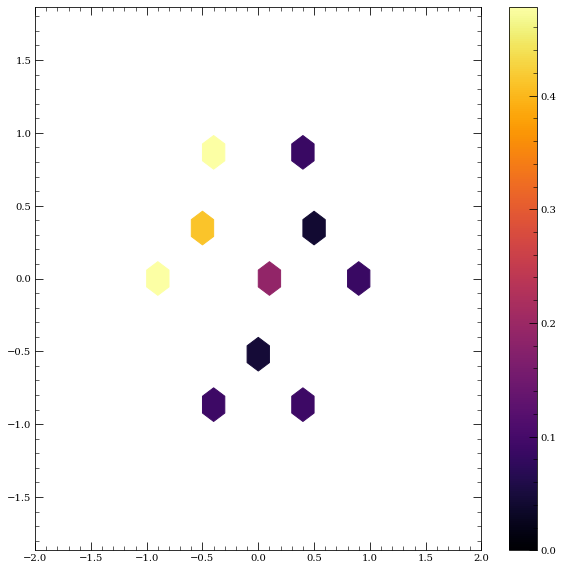

0.6621534468619579


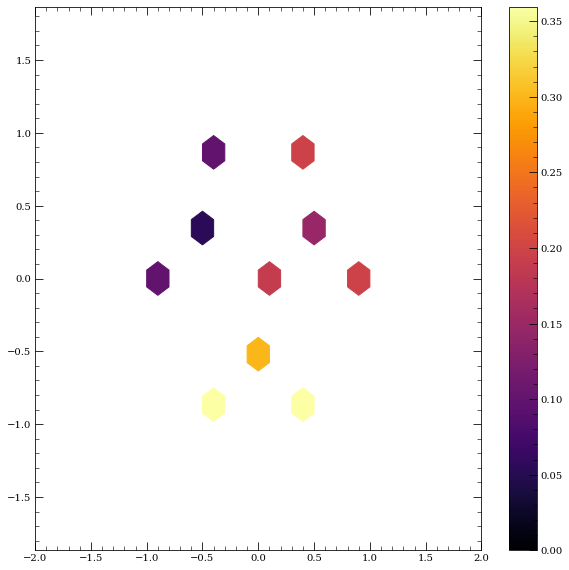

0.662153446861958


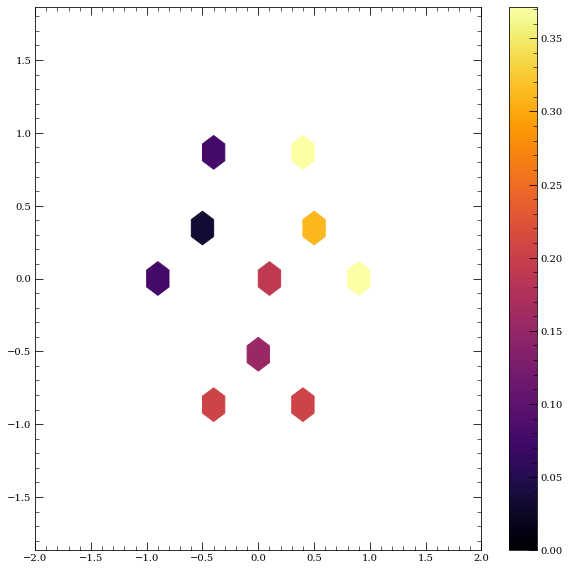

1.163159258892658


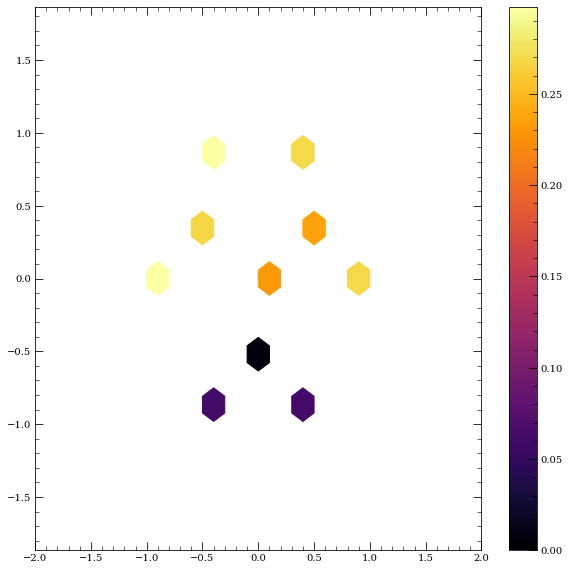

1.1631592588926616


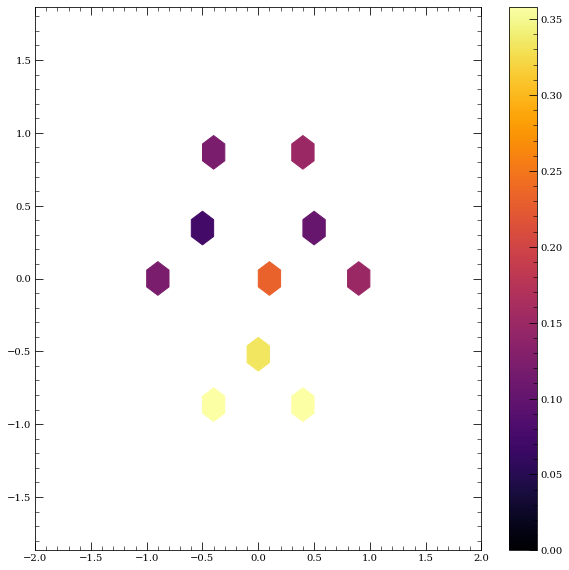

1.2582009241577192


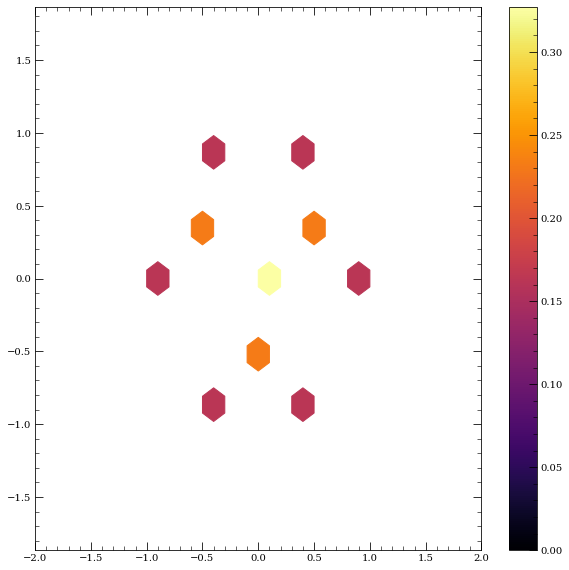

1.414213562373095


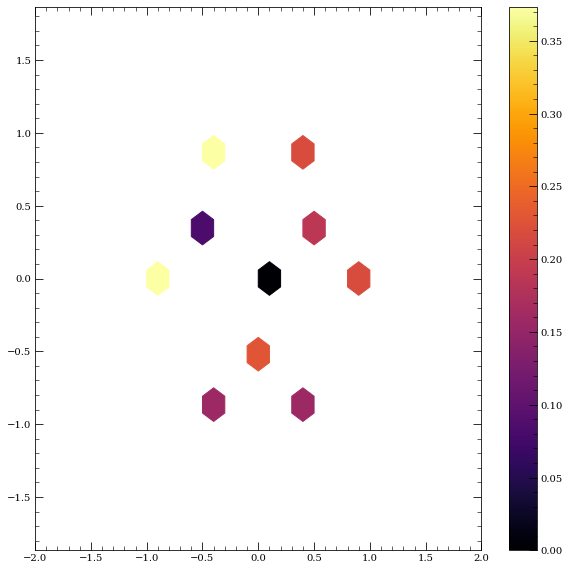

1.4142135623730951


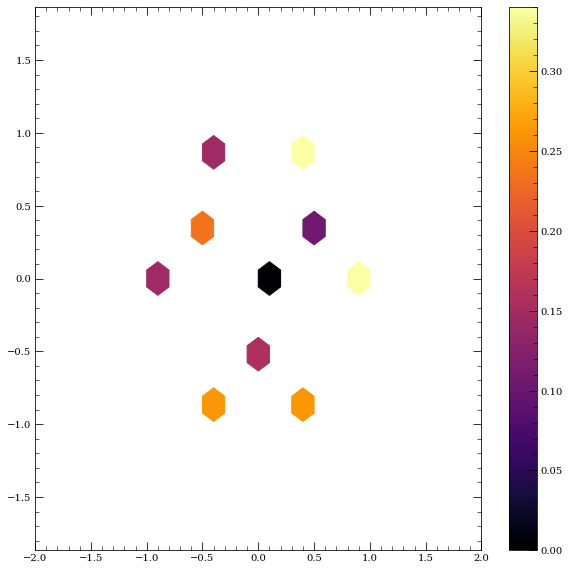

1.414213562373098


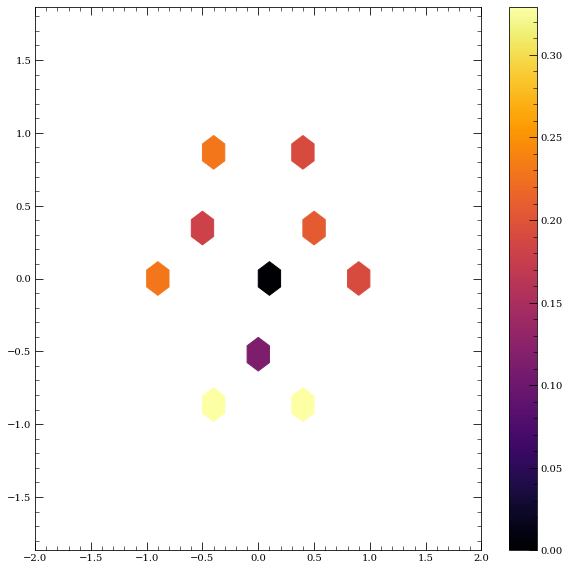

1.6606837081188752


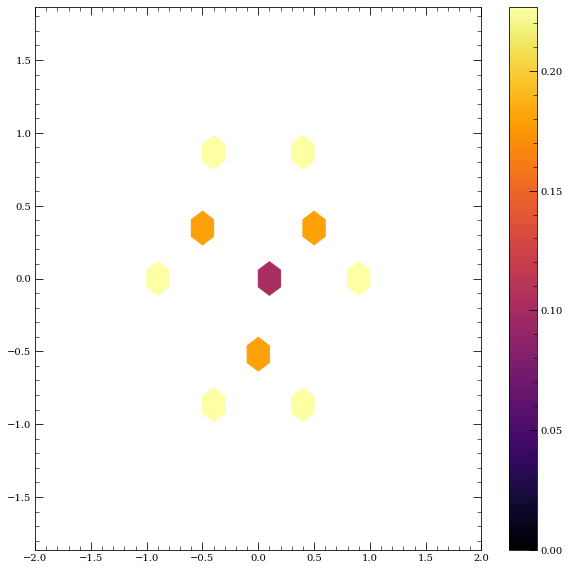

2.01557920428876


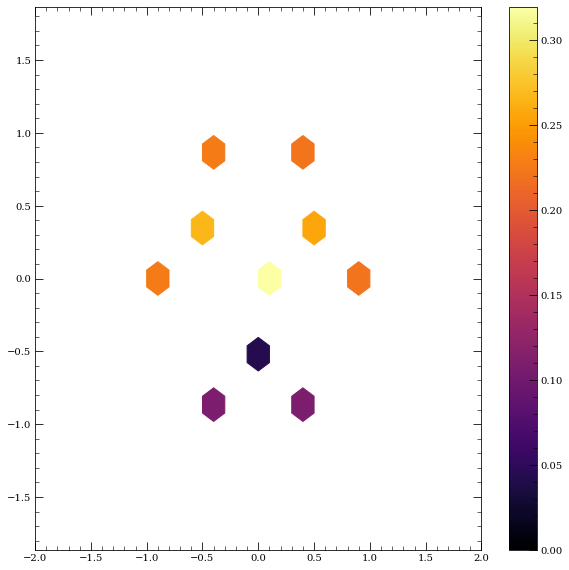

2.0155792042887652


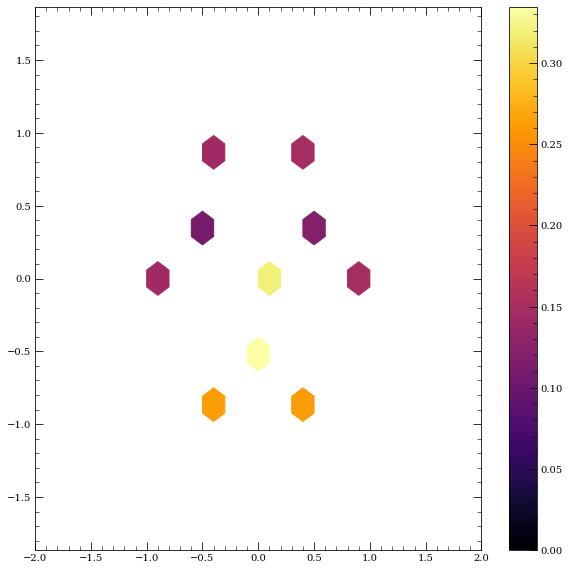

2.135779205069855


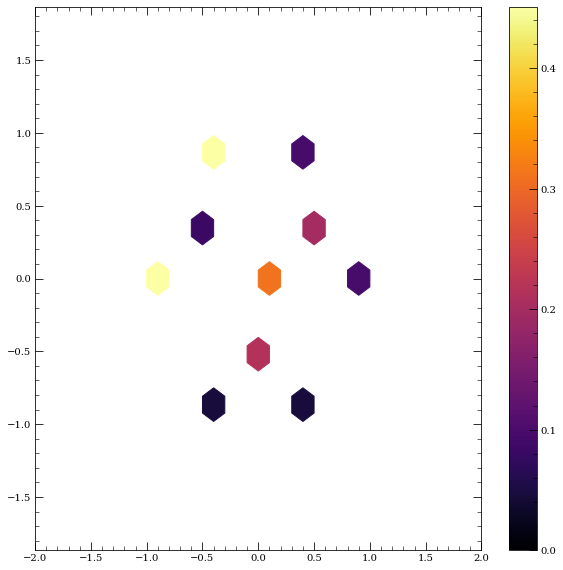

2.1357792050698556


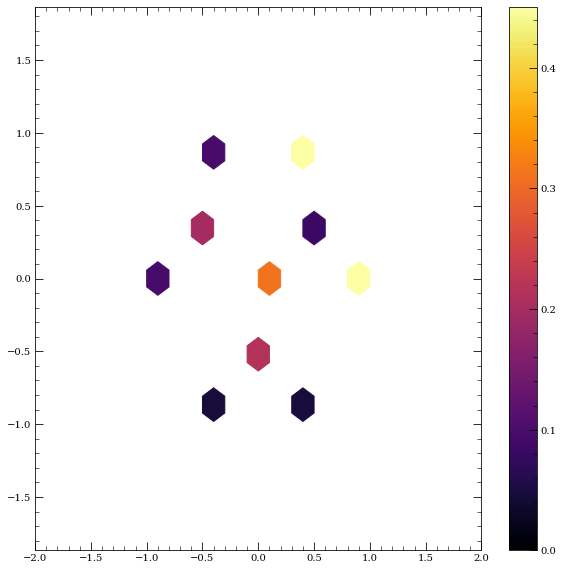

2.1357792050698605


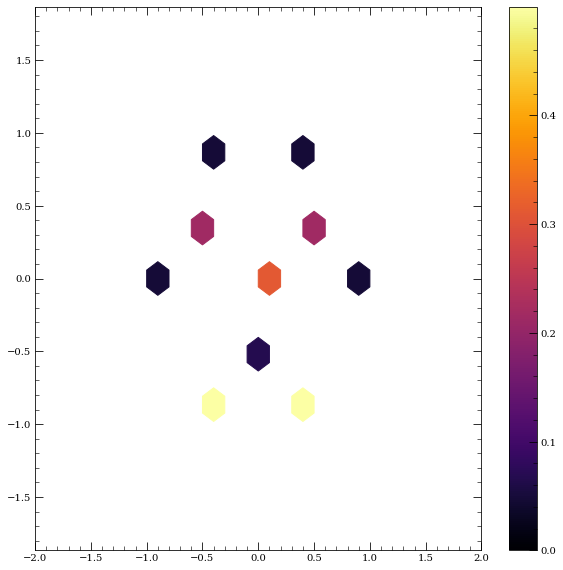

3.2208769184231083


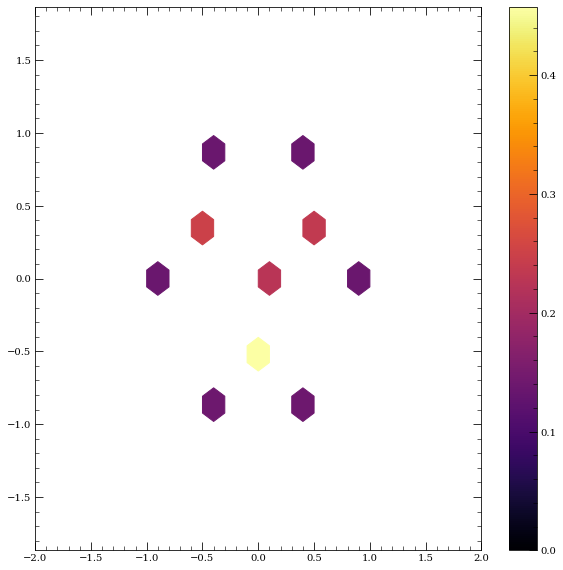

3.22087691842311


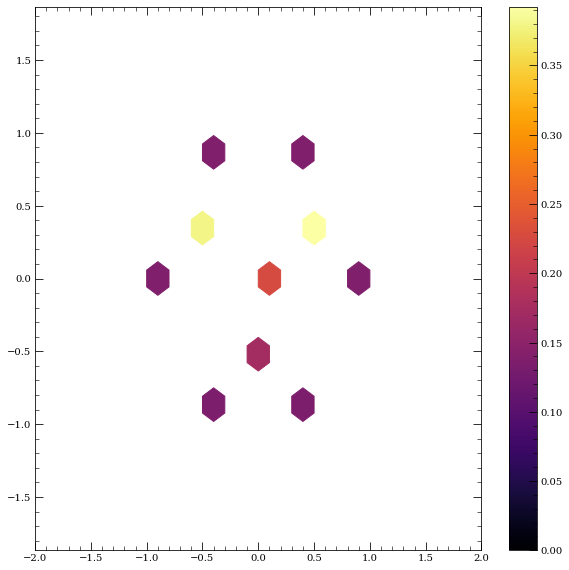

3.8287151965166086


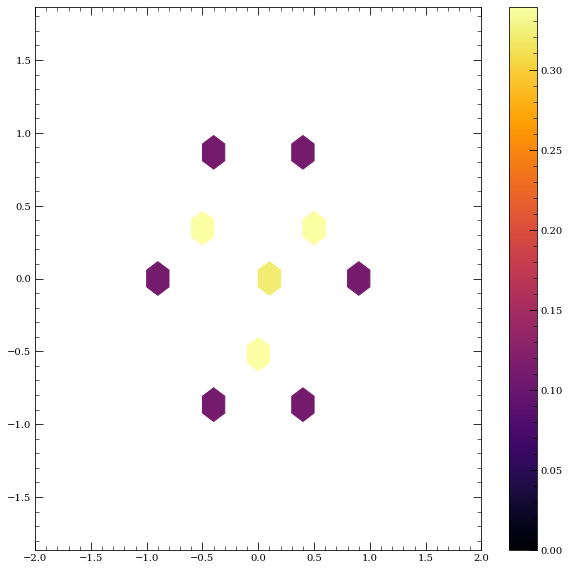

In [13]:
obs_basis=2
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

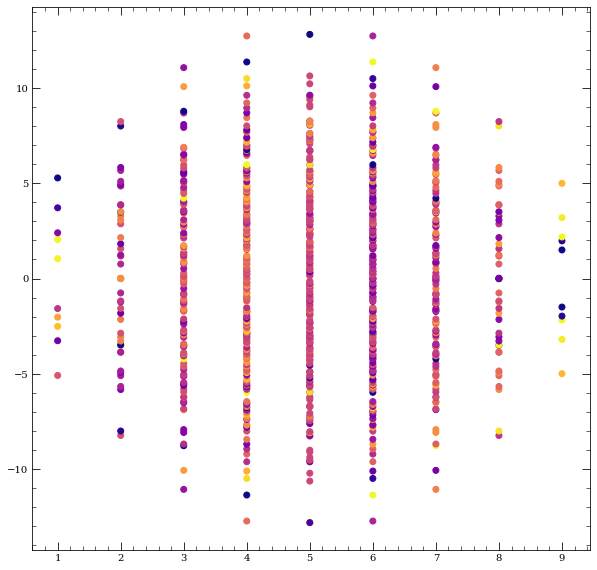

<Figure size 1080x1440 with 0 Axes>

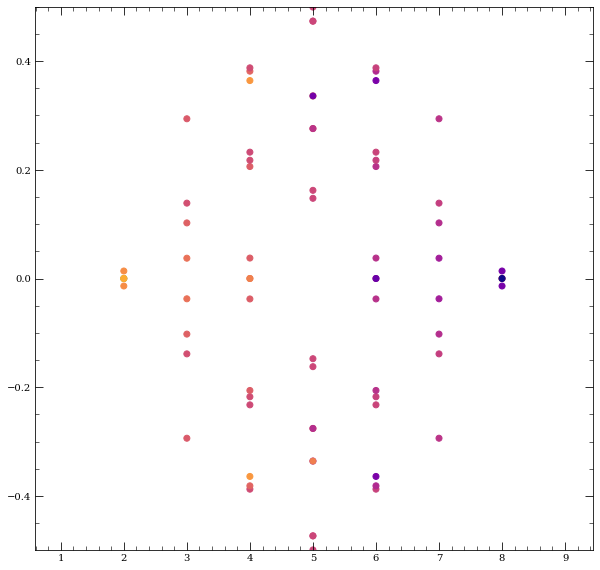

In [349]:
M=1
P=np.pi/2*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-3.8287151965166077


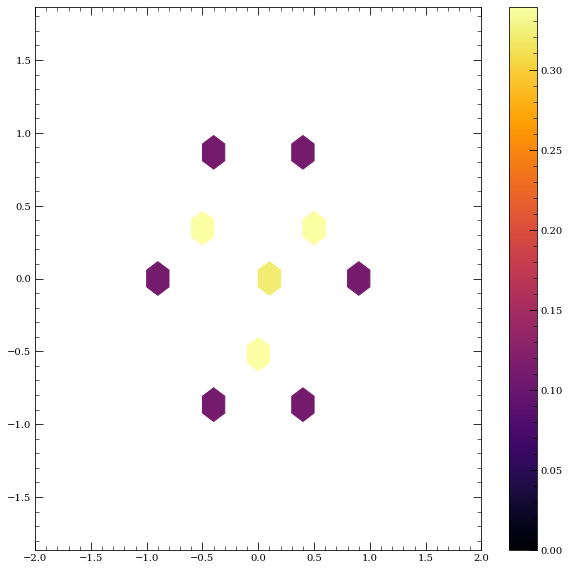

-3.220876918423111


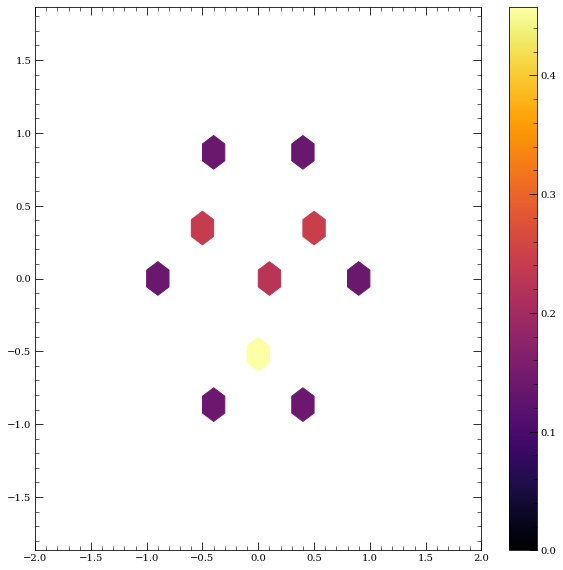

-3.2208769184231025


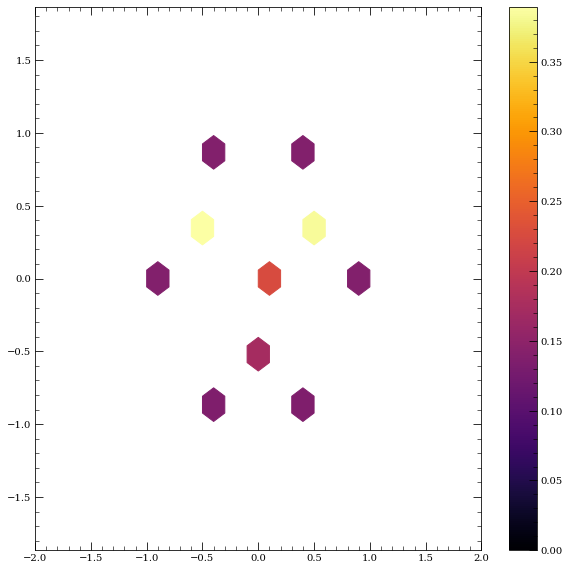

-2.135779205069858


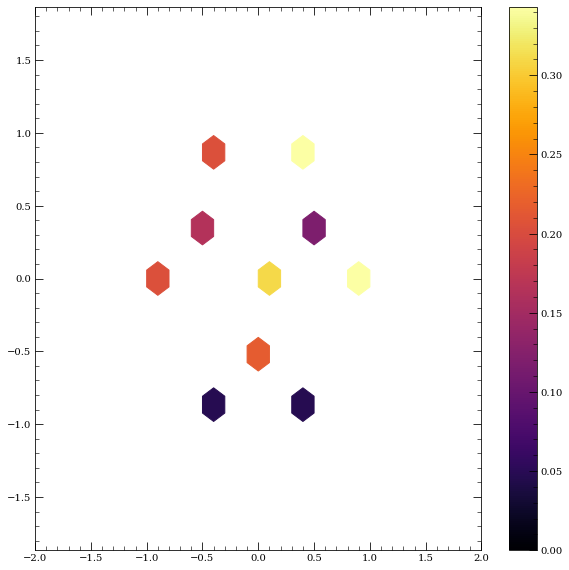

-2.1357792050698534


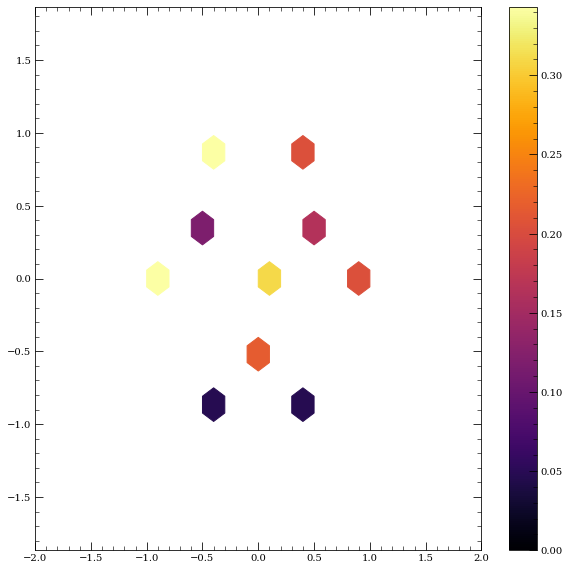

-2.1357792050698485


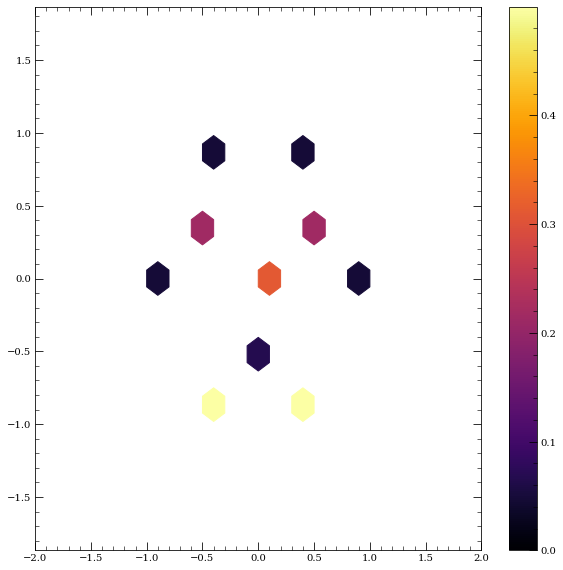

-2.01557920428876


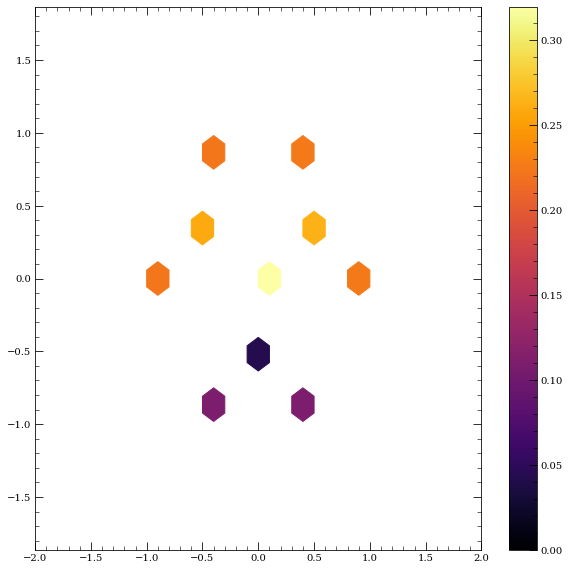

-2.0155792042887537


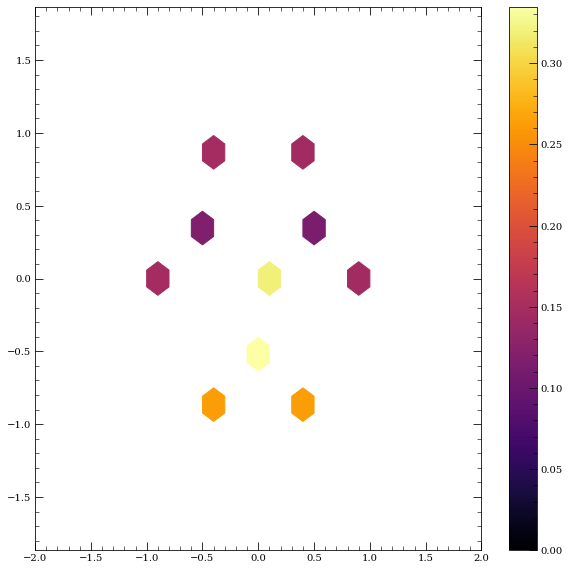

-1.6606837081188632


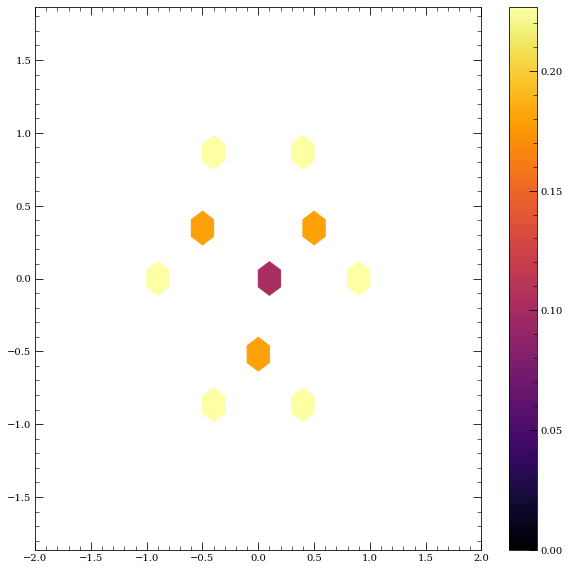

-1.4142135623730965


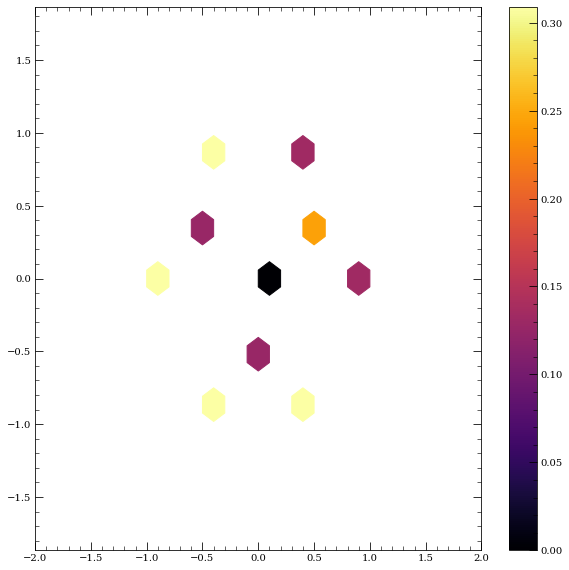

-1.4142135623730951


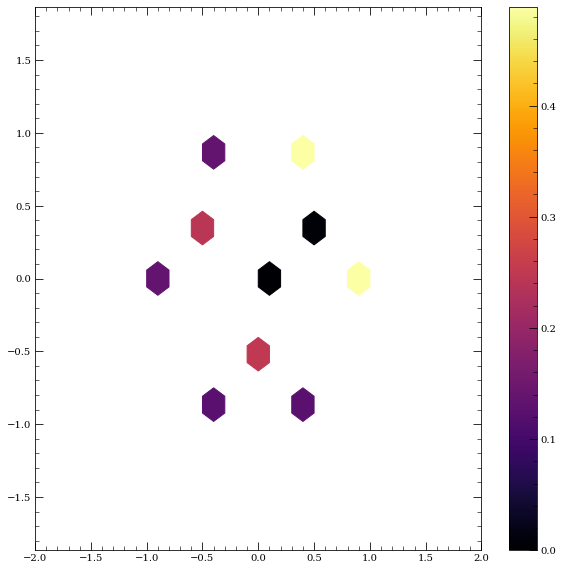

-1.4142135623730887


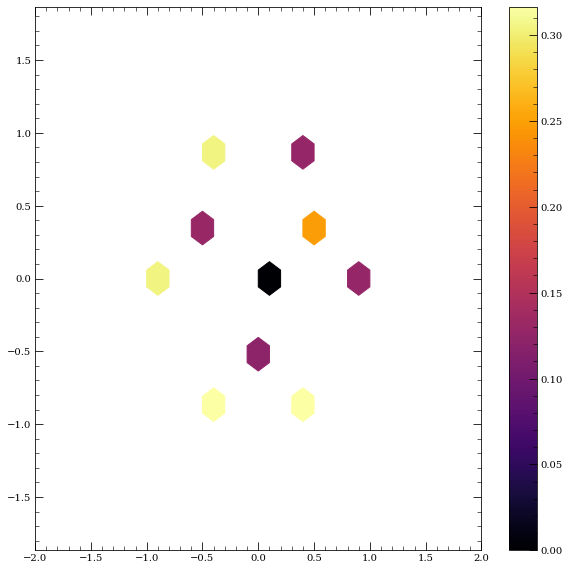

-1.2582009241577228


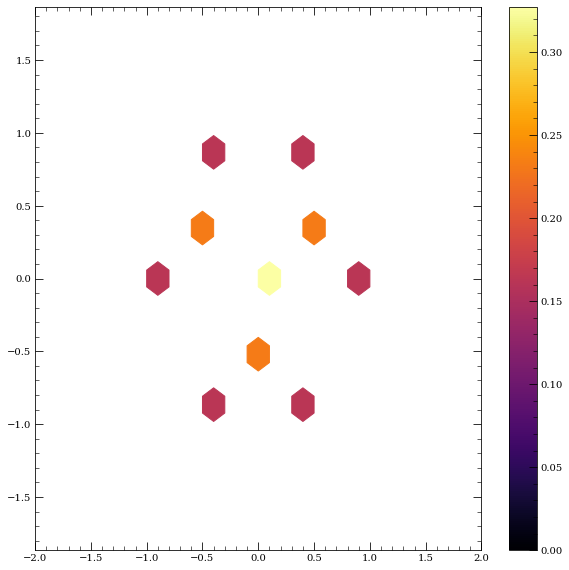

-1.163159258892663


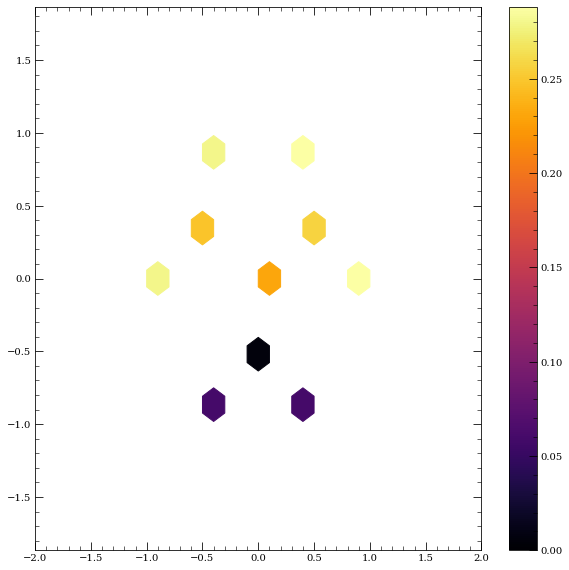

-1.1631592588926563


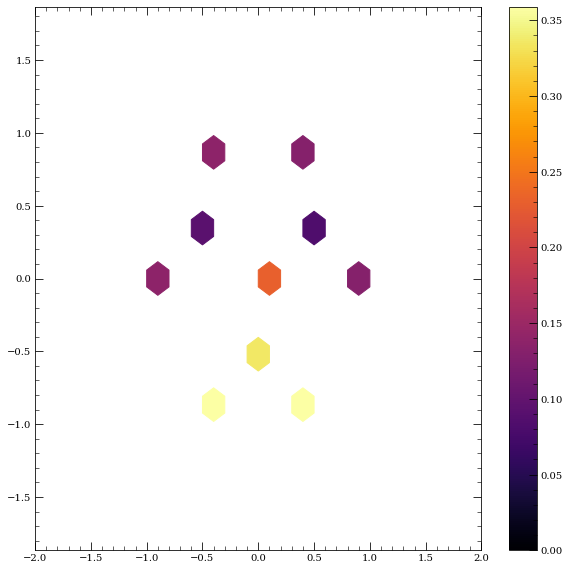

-0.6621534468619567


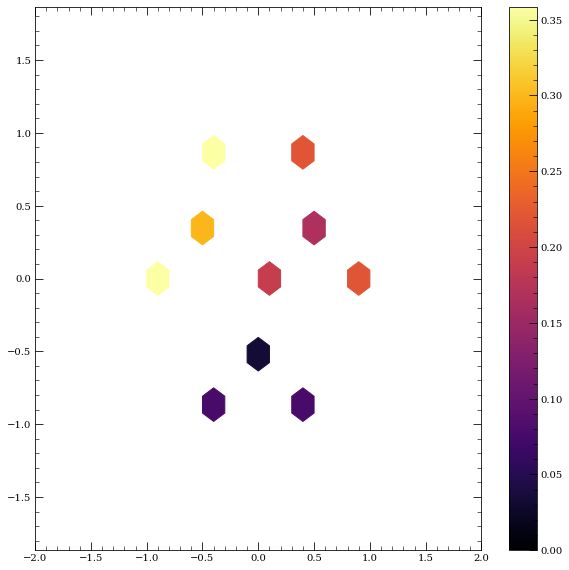

-0.6621534468619534


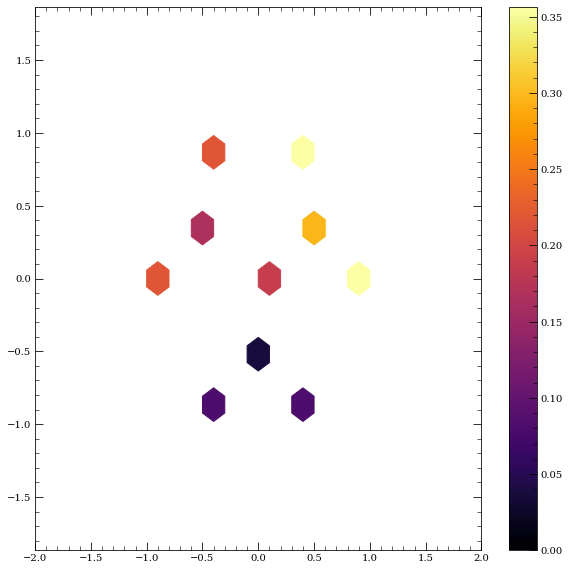

-0.6621534468619525


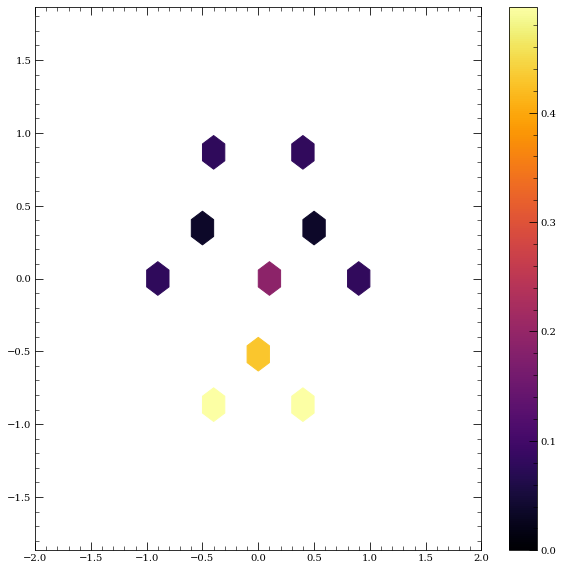

-0.4587514425701806


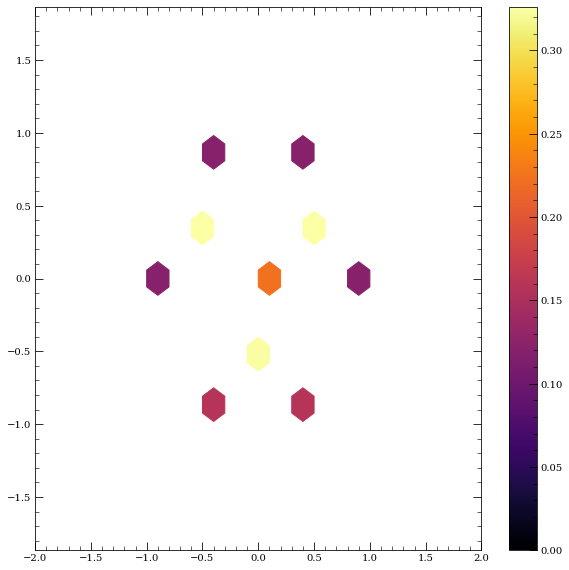

-0.45875144257017725


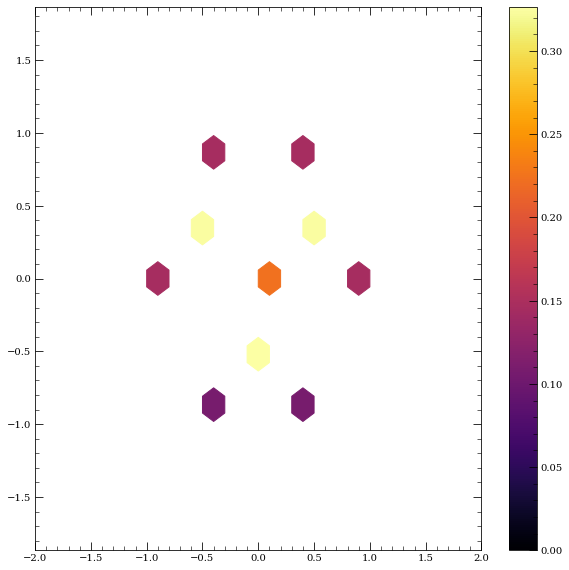

-1.7553332585808065e-16


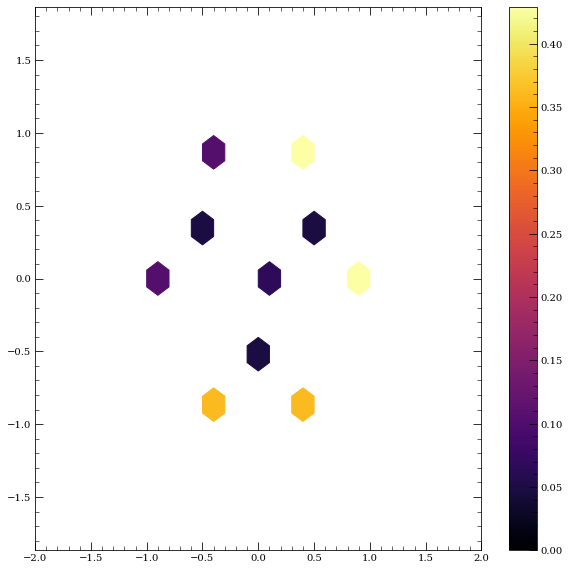

-7.103118882406812e-17


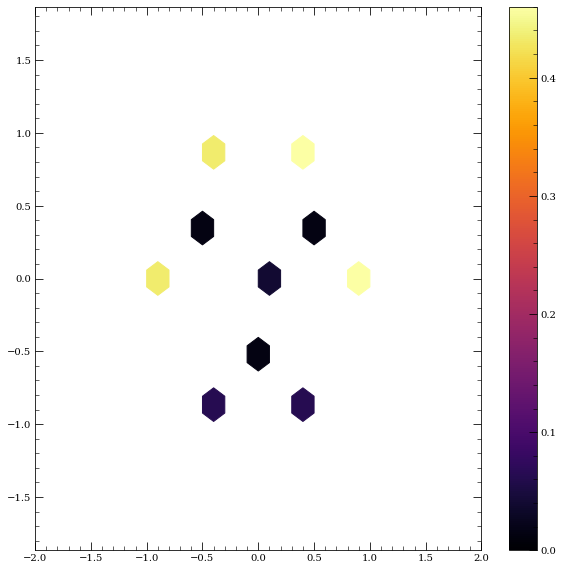

-1.0453036459140484e-17


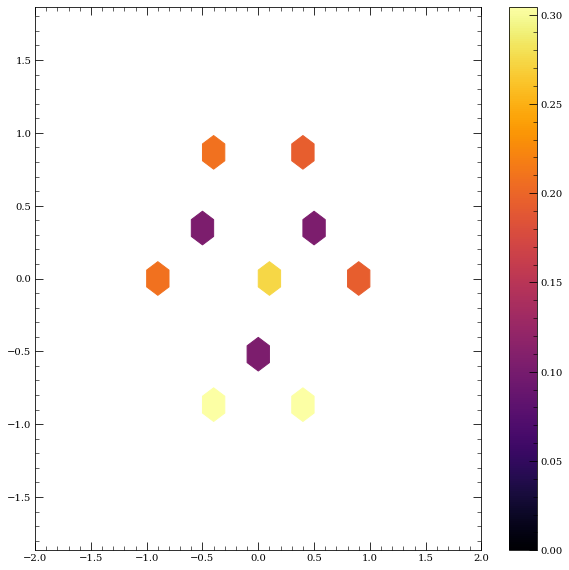

4.0810005826651253e-16


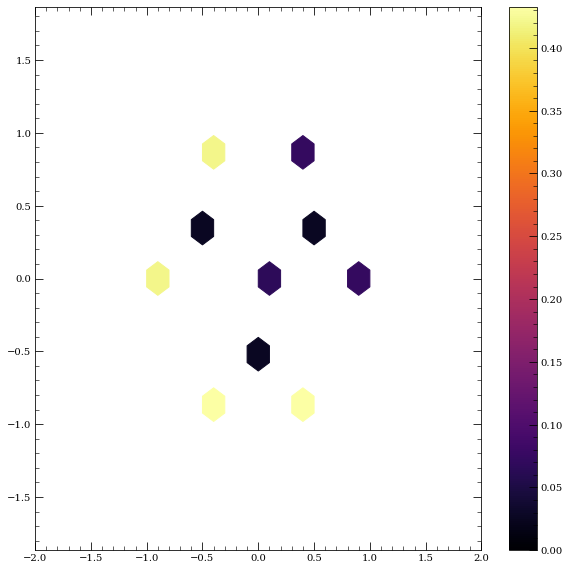

3.516326536847299e-15


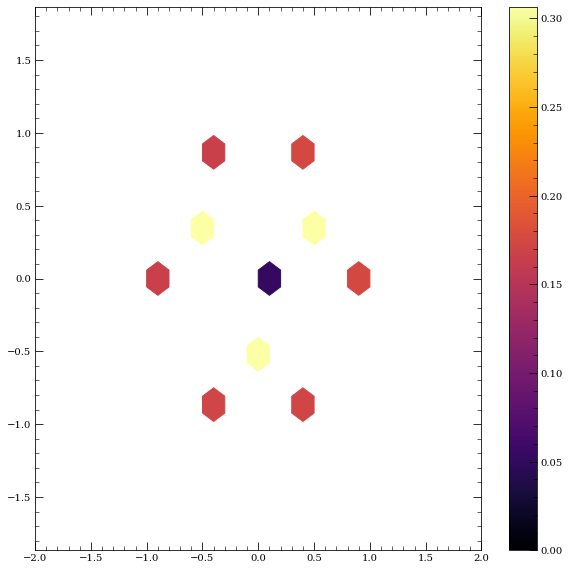

0.4587514425701753


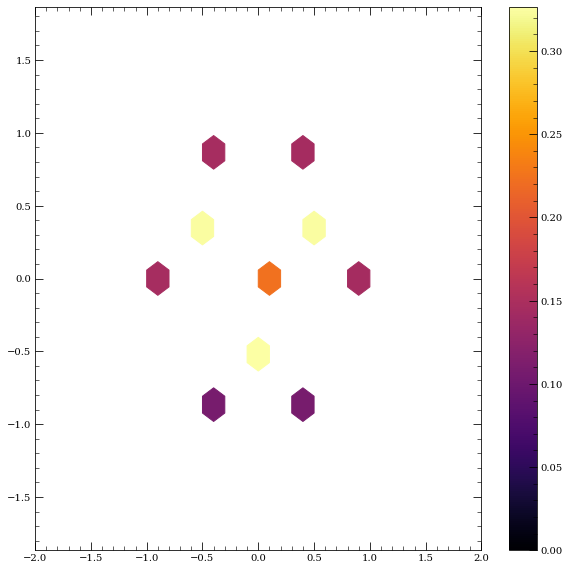

0.4587514425701812


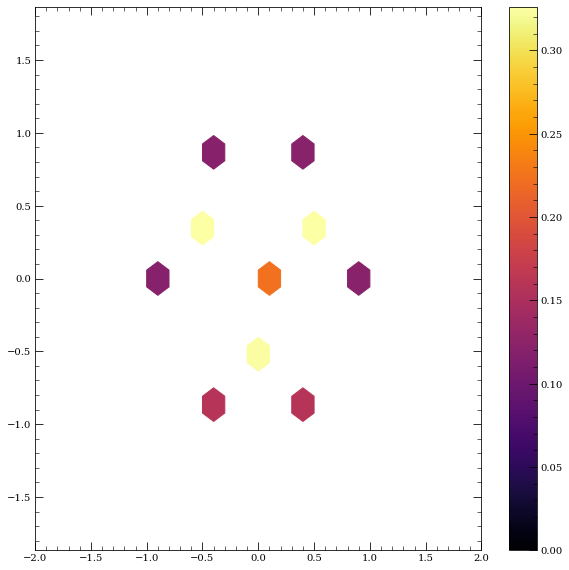

0.6621534468619578


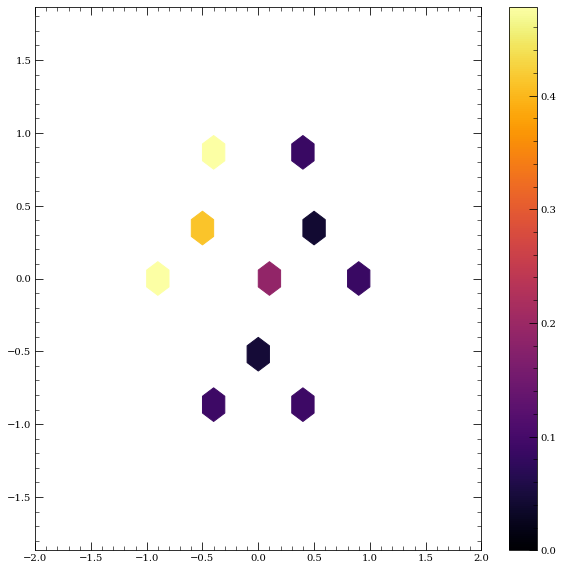

0.6621534468619579


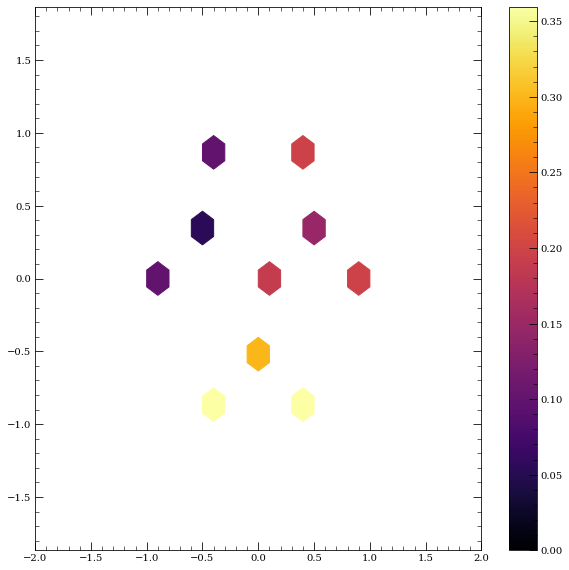

0.662153446861958


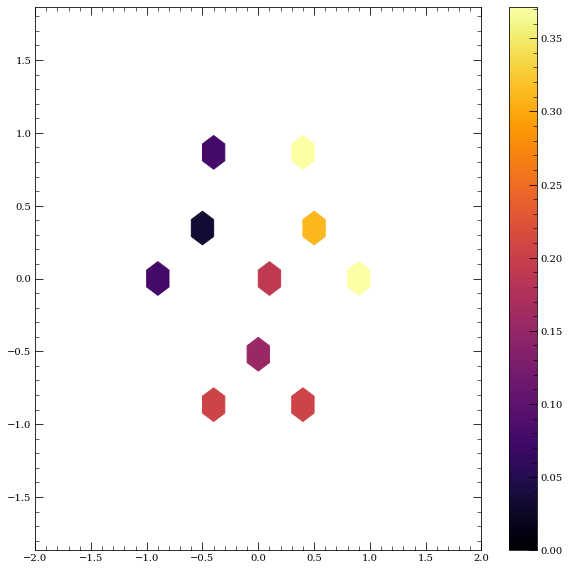

1.163159258892658


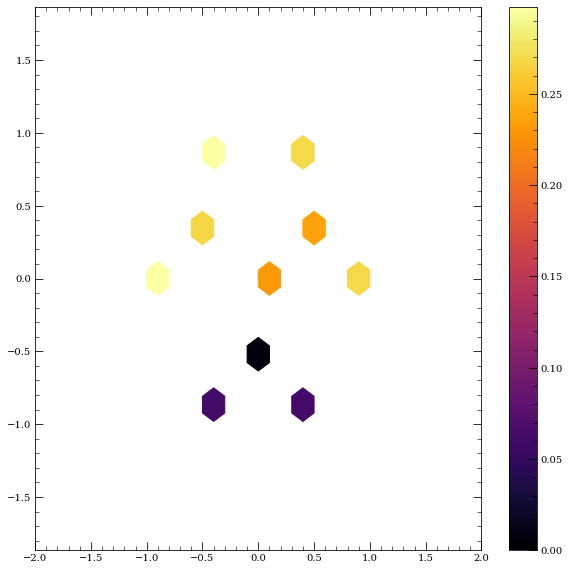

1.1631592588926616


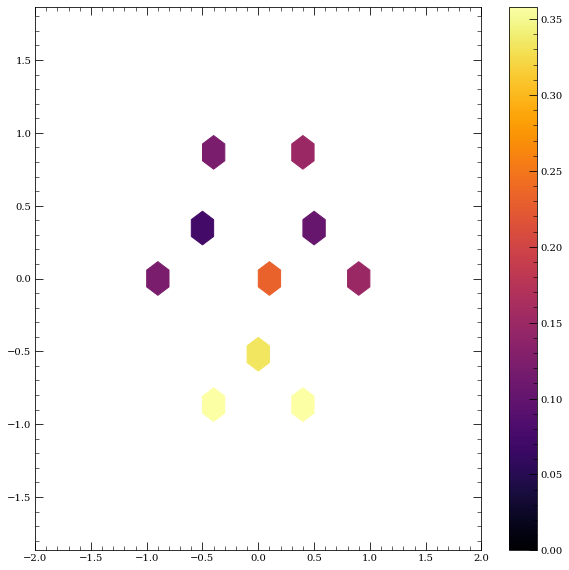

1.2582009241577192


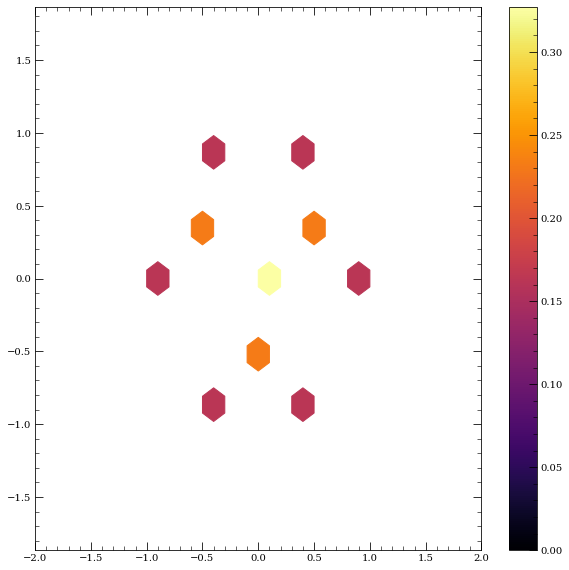

1.414213562373095


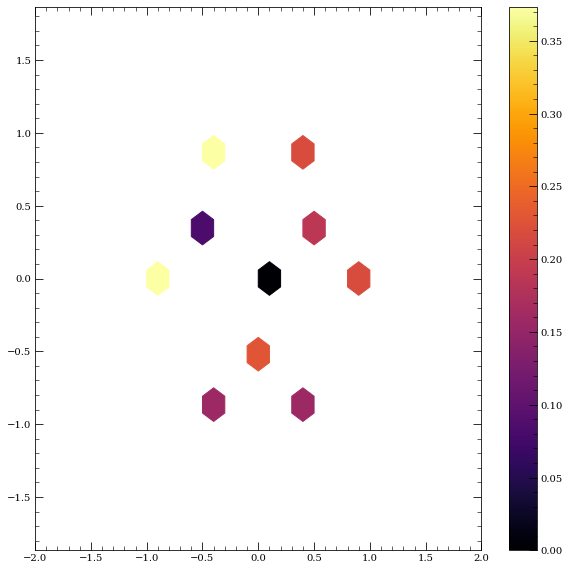

1.4142135623730951


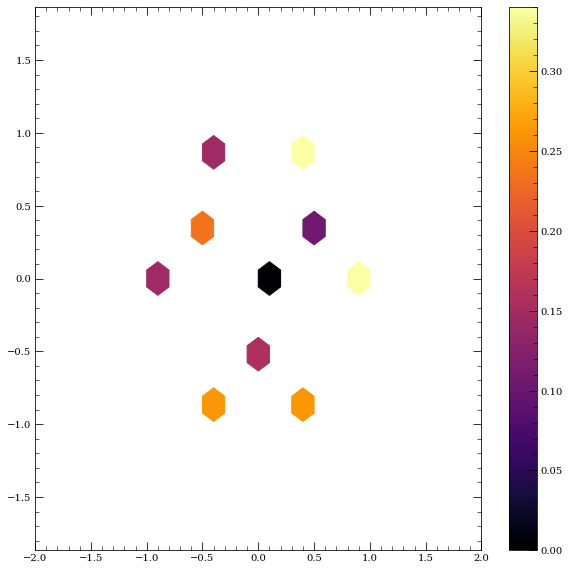

1.414213562373098


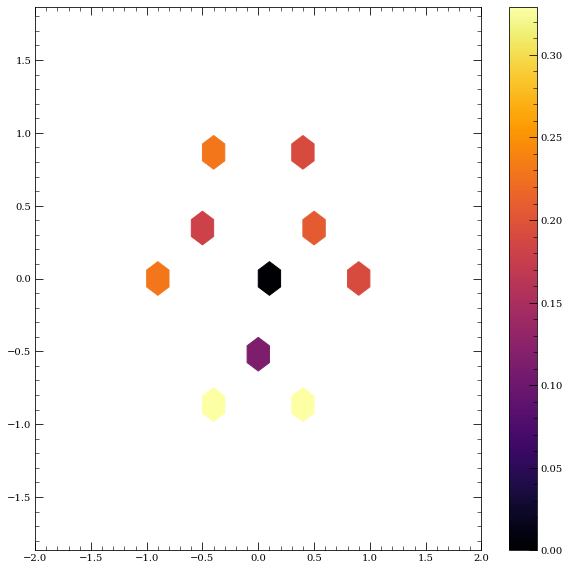

1.6606837081188752


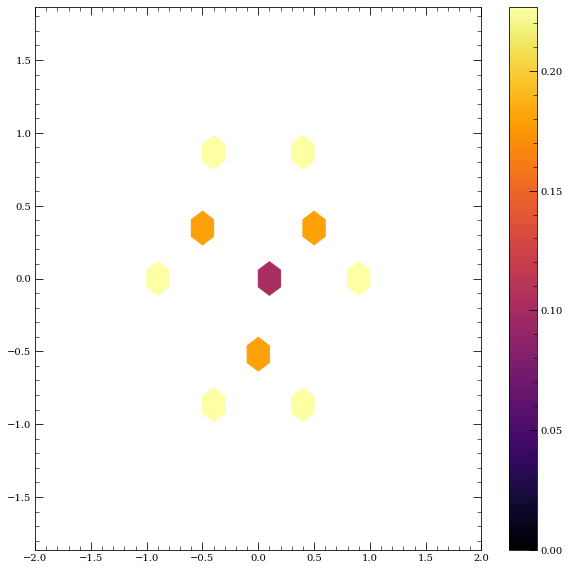

2.01557920428876


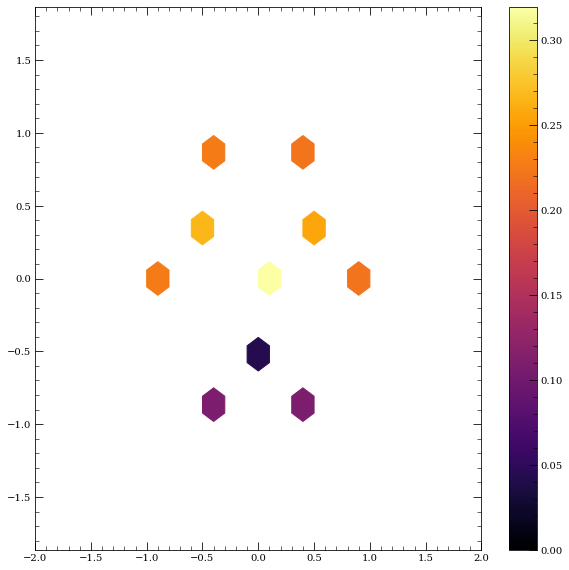

2.0155792042887652


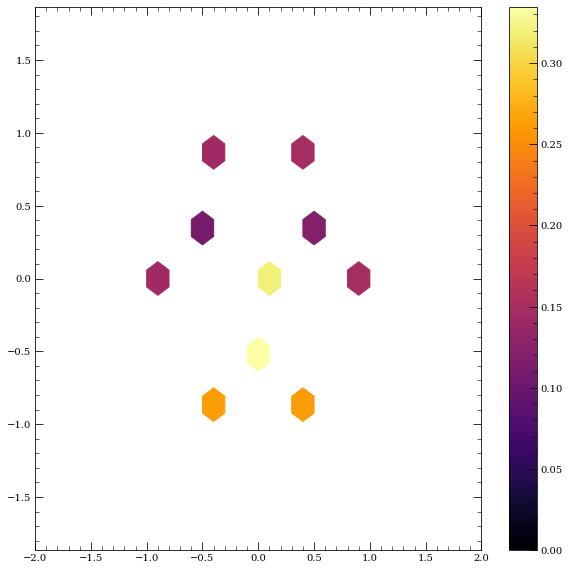

2.135779205069855


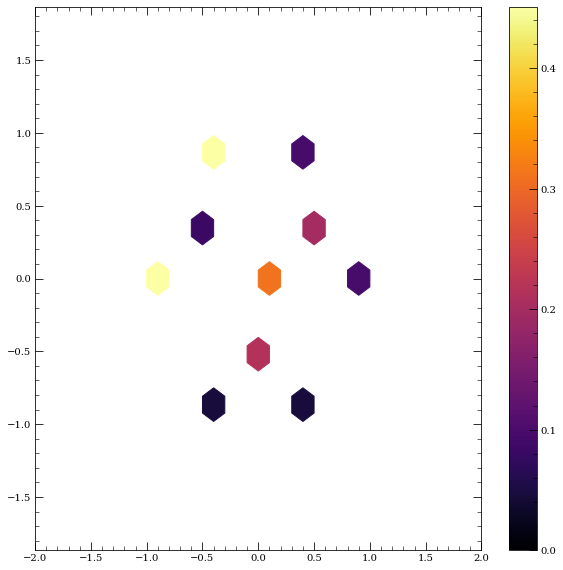

2.1357792050698556


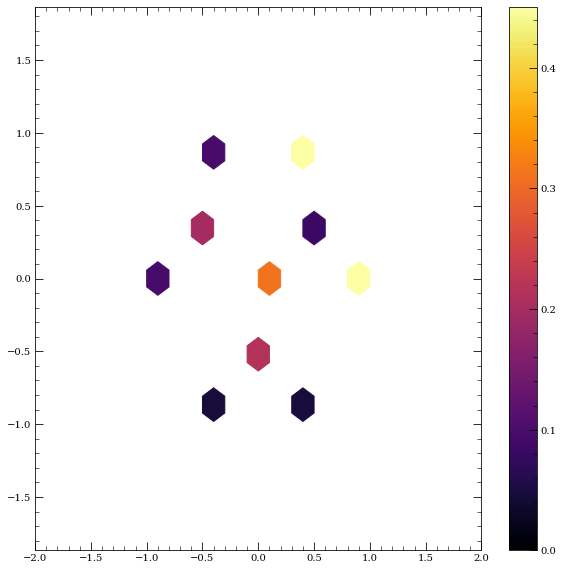

2.1357792050698605


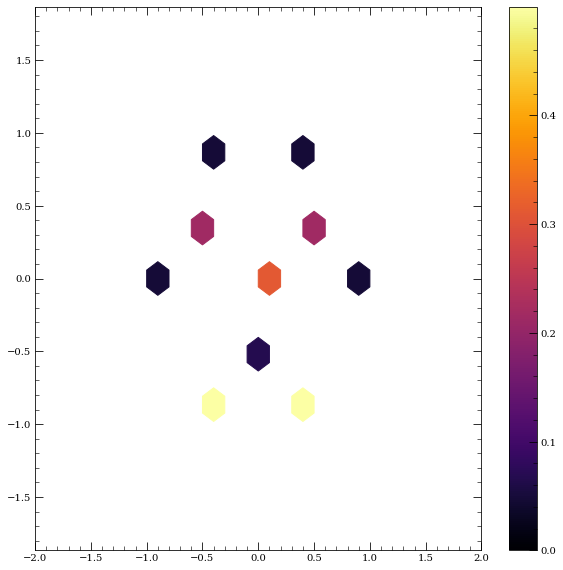

3.2208769184231083


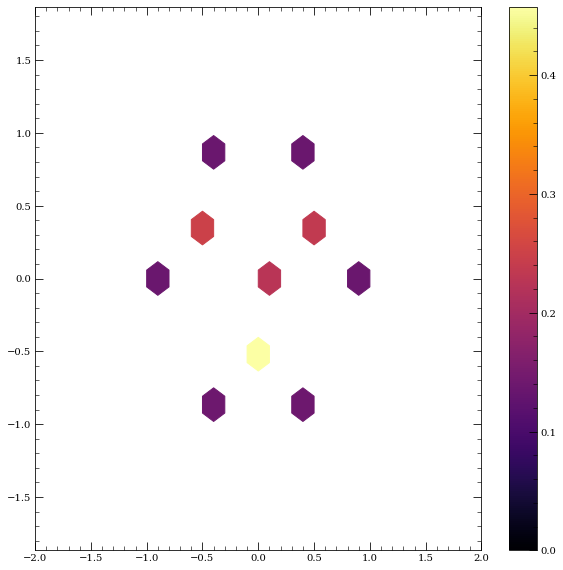

3.22087691842311


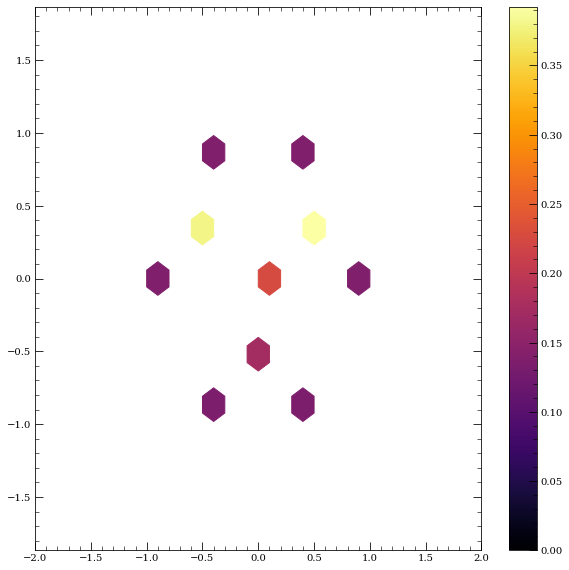

3.8287151965166086


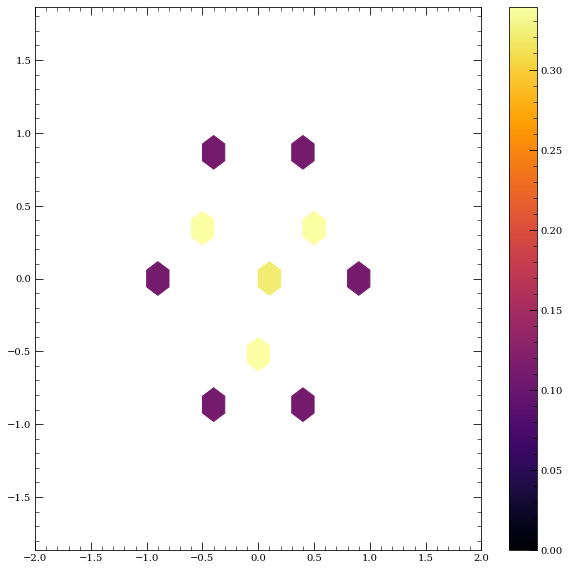

In [14]:
obs_basis=2
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
2 particle basis
3 particle basis
4 particle basis
5 particle basis
6 particle basis
7 particle basis
8 particle basis
9 particle basis


<Figure size 1080x1440 with 0 Axes>

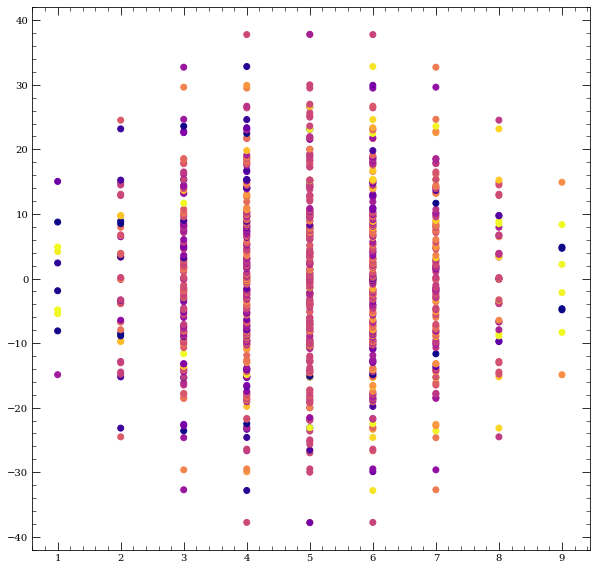

<Figure size 1080x1440 with 0 Axes>

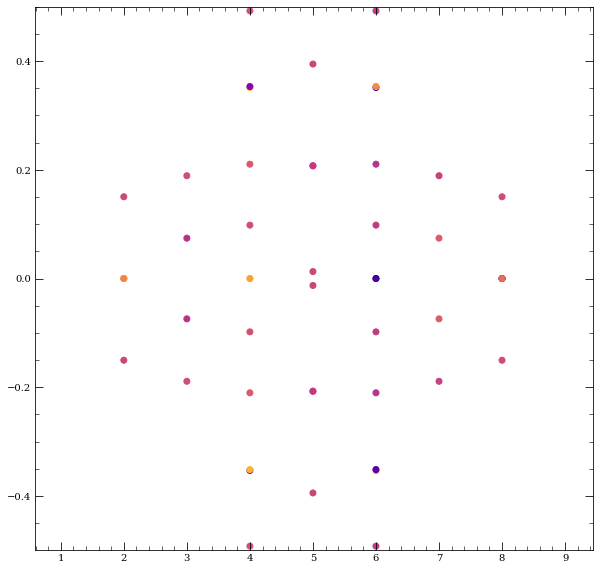

In [31]:
M=1
P=3*np.pi/2*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

-14.897787809801798


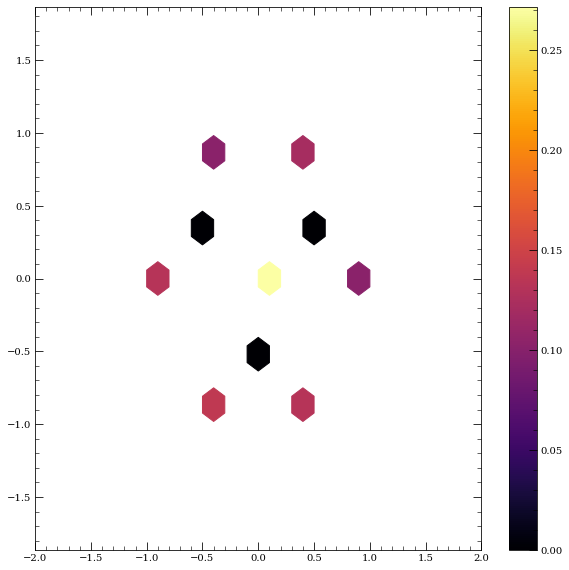

-8.112214713841766


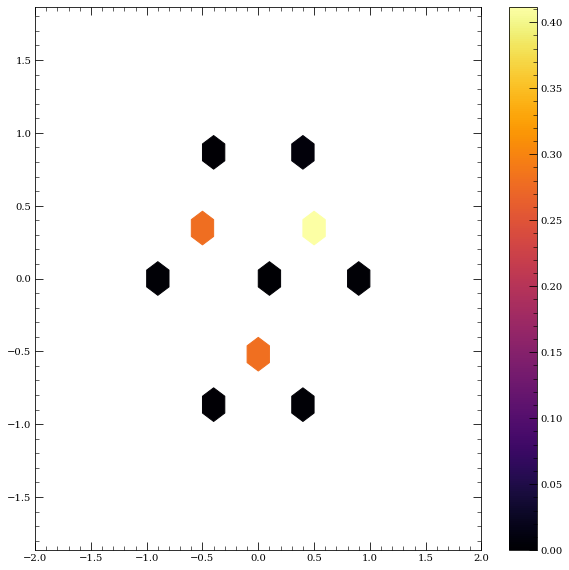

-5.460940332179909


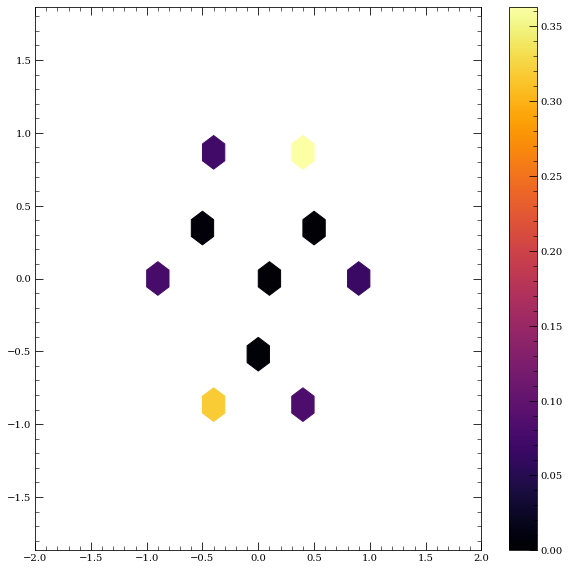

-4.857107330547116


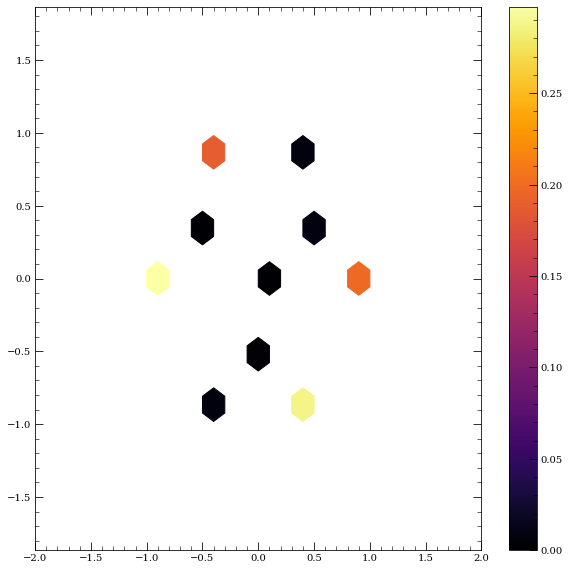

-1.8975416944393046


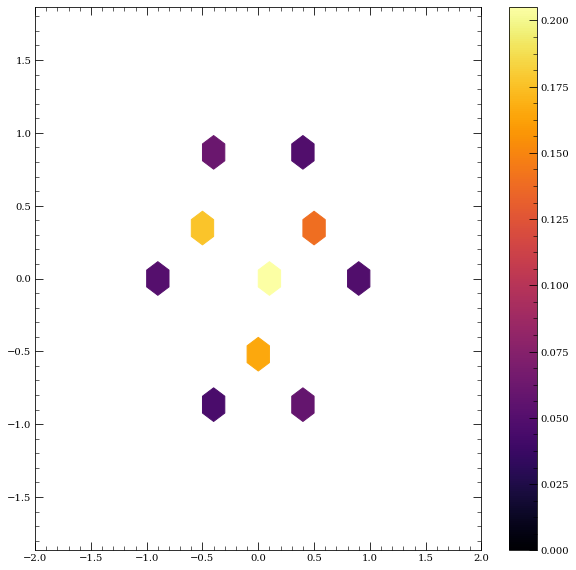

2.4061614922996544


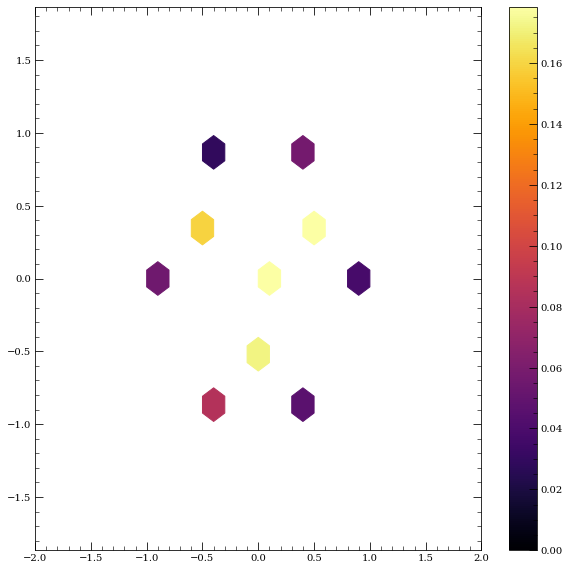

4.160568324023458


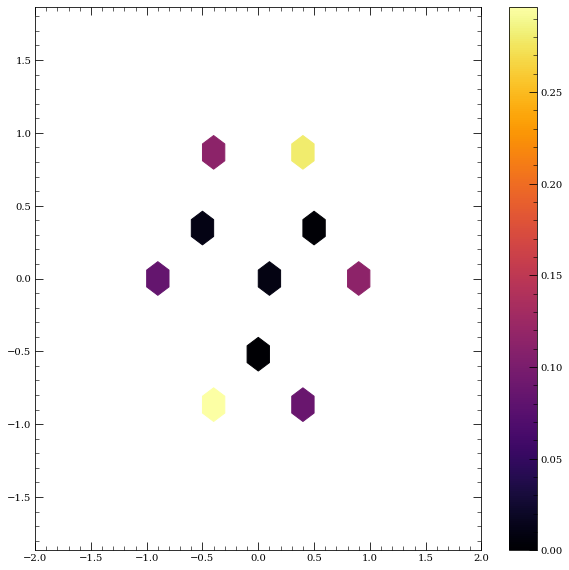

4.880598154461964


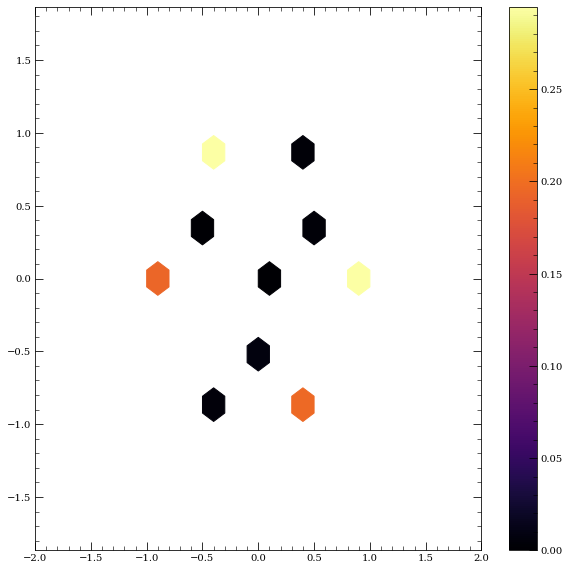

8.741985236845869


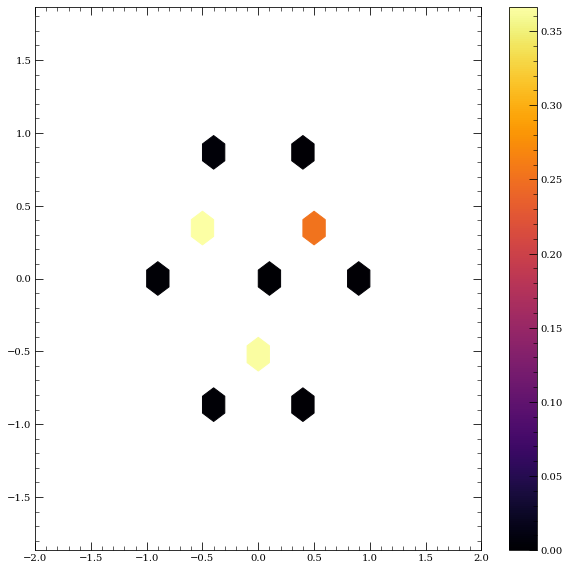

15.036278673179044


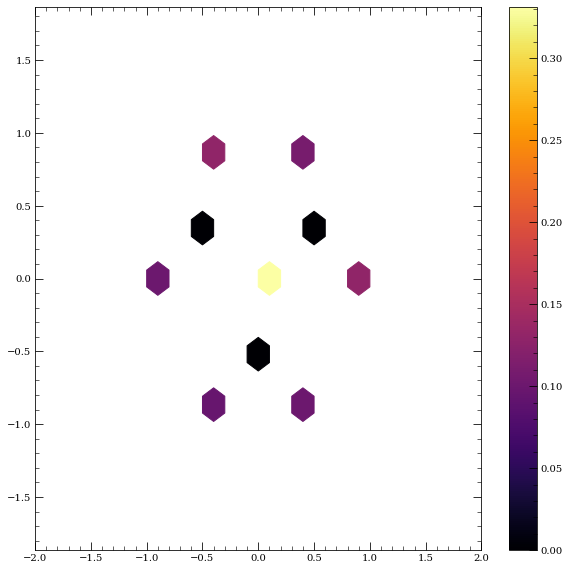

In [32]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

1 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
2 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
3 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
4 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
5 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
6 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
7 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
8 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5 0.289
0.5 0.866
-0.5 0.866
-0.5 -0.866
0.0 -0.577
0.5 -0.866
9 particle basis
0.0 0.0
0.5 0.289
1.0 0.0
-1.0 0.0
-0.5

<Figure size 1080x1440 with 0 Axes>

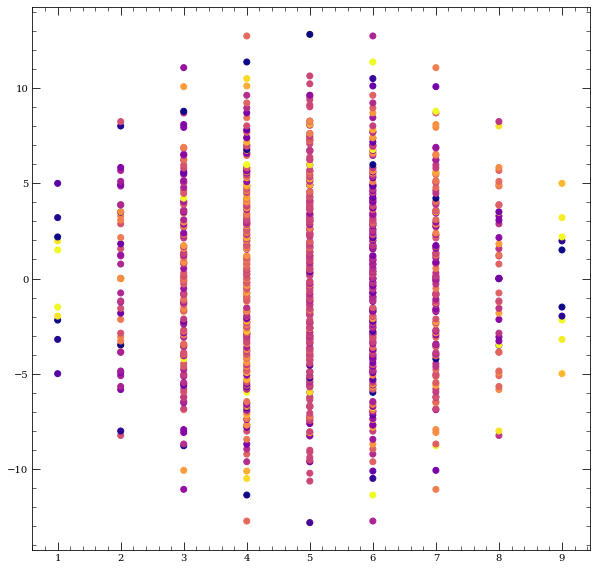

<Figure size 1080x1440 with 0 Axes>

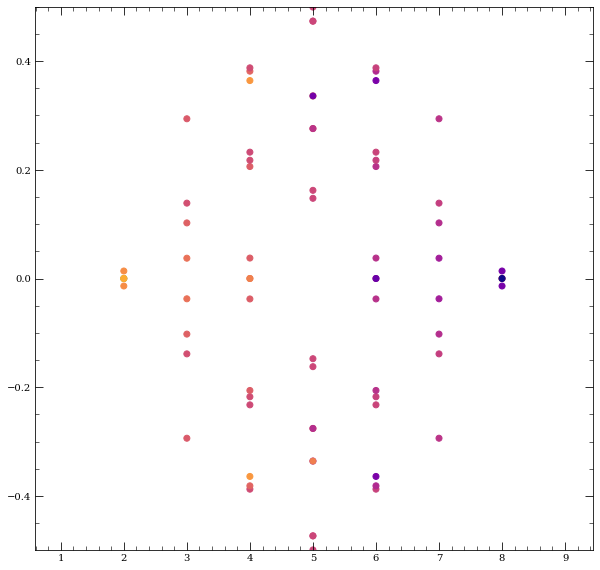

In [529]:
M=0
P=np.pi/2*1j
symm=True
sets=2
printEigenspectrum(M,P,1,1,1,symm,sets)

0.0 0.0
0.289 0.5
0.0 1.0
0.0 -1.0
0.289 -0.5
0.866 0.5
0.866 -0.5
-0.866 -0.5
-0.577 0.0
-0.866 0.5
-4.992165926763765


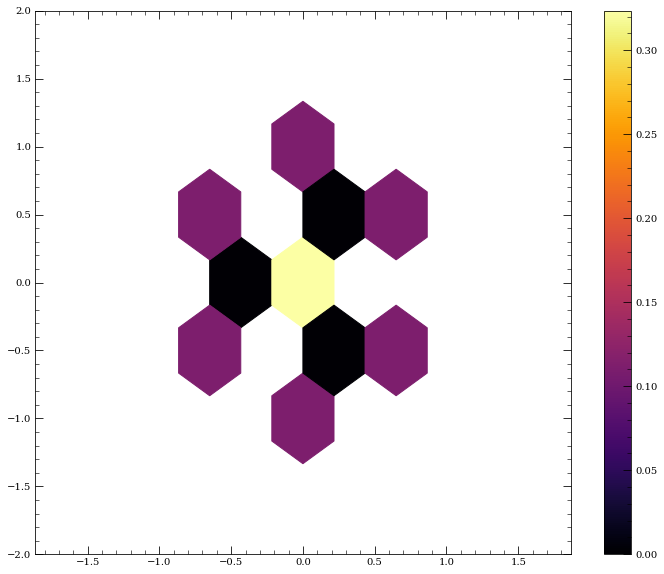

-3.1947623264350247


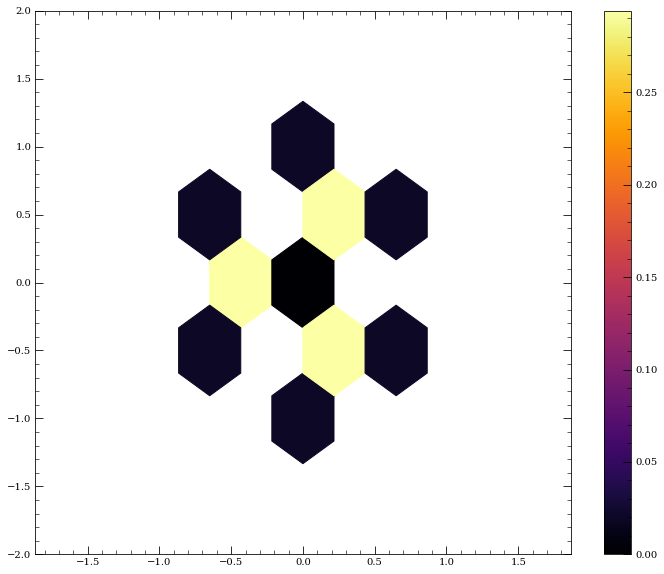

-2.179974853612322


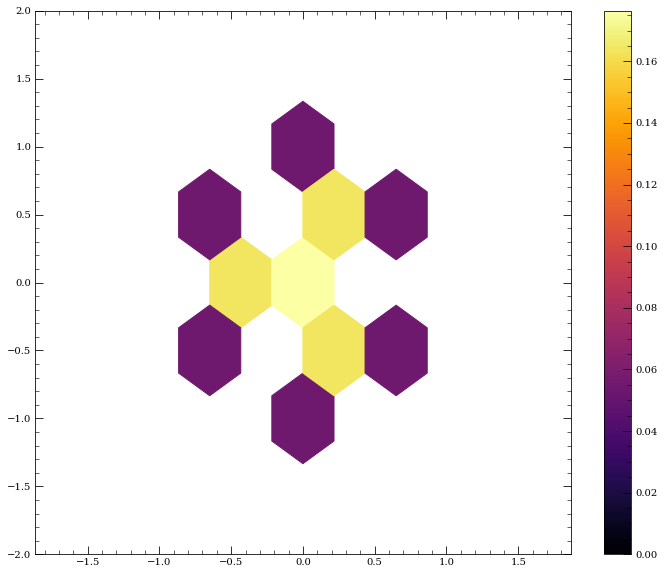

-1.9716974842595905


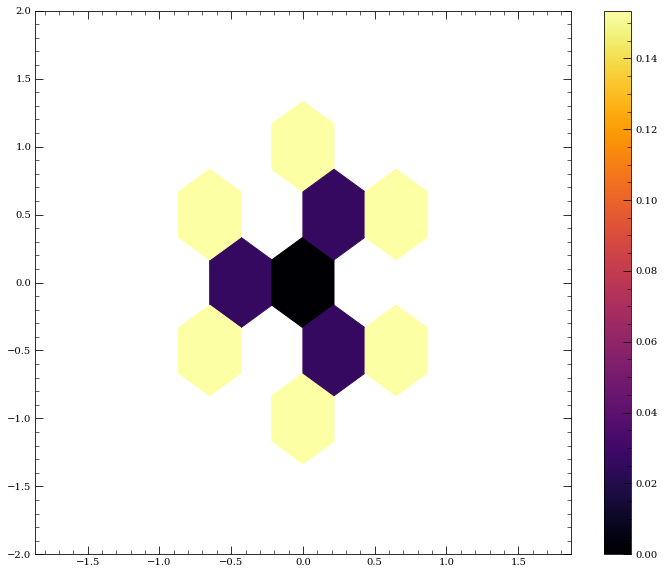

-1.4976342041759025


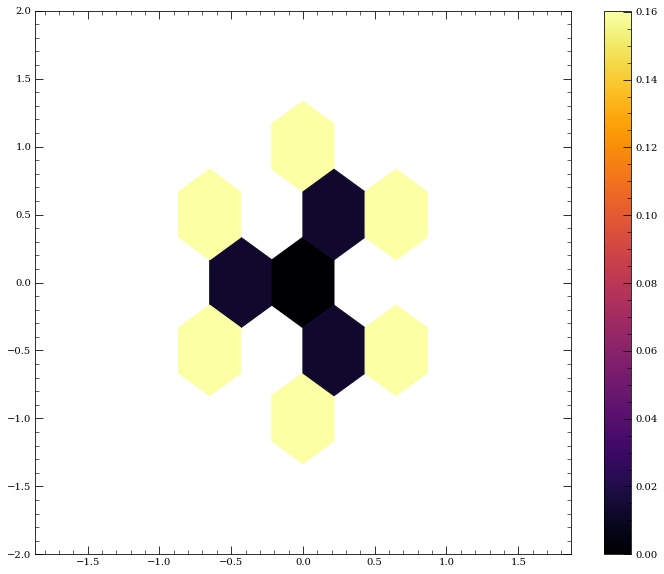

1.4976342041759048


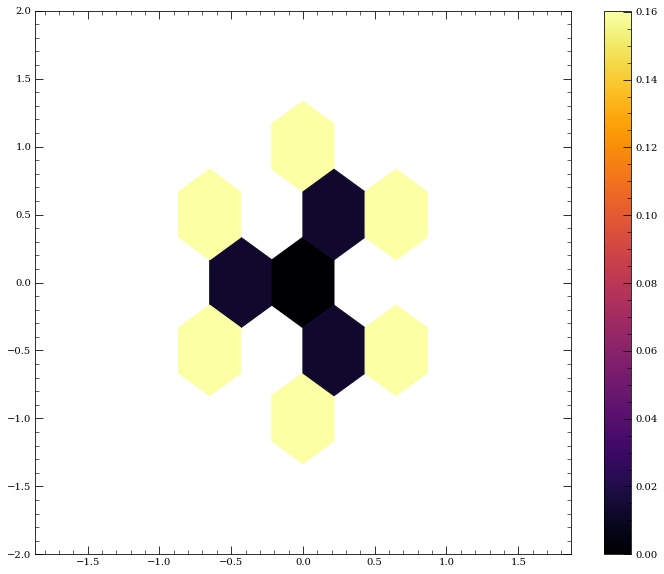

1.971697484259599


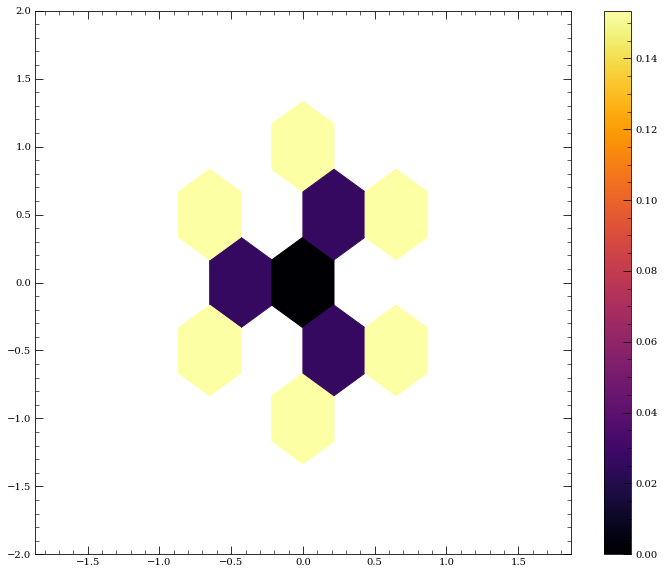

2.179974853612324


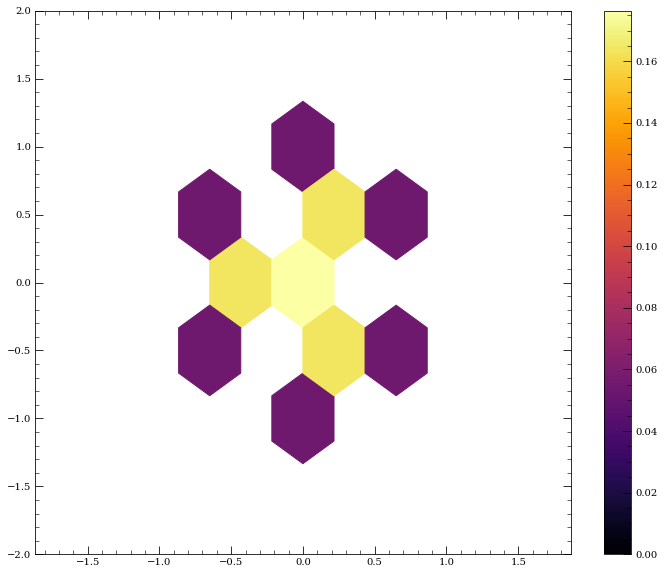

3.1947623264350224


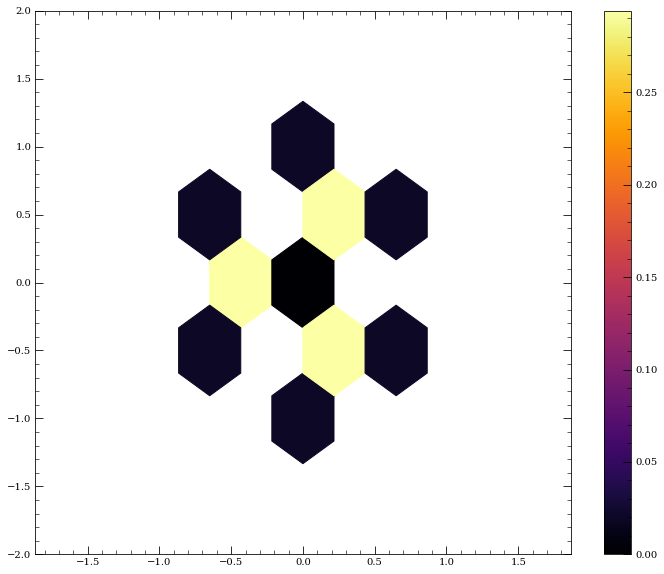

4.992165926763787


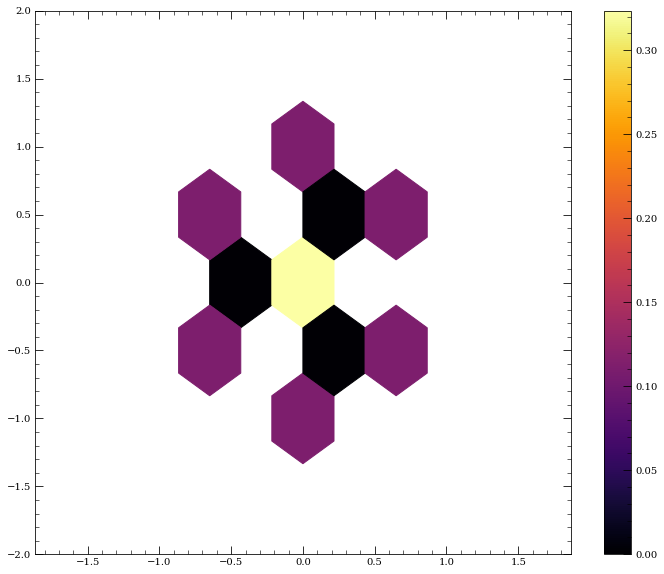

In [455]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

Solving


/Users/jordankemp/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Calcing response function


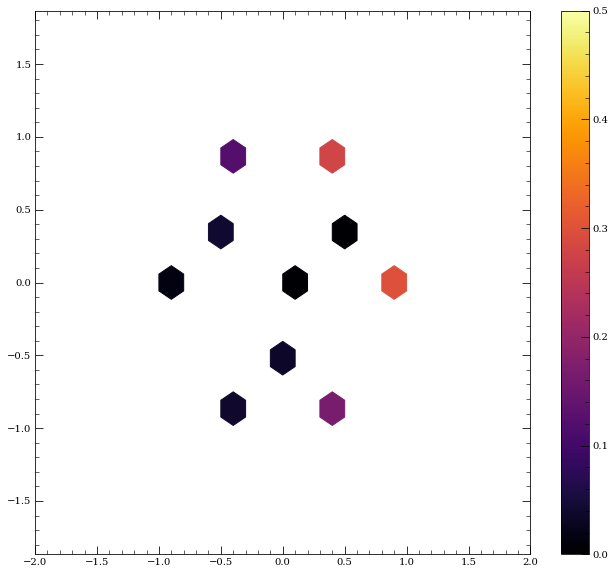

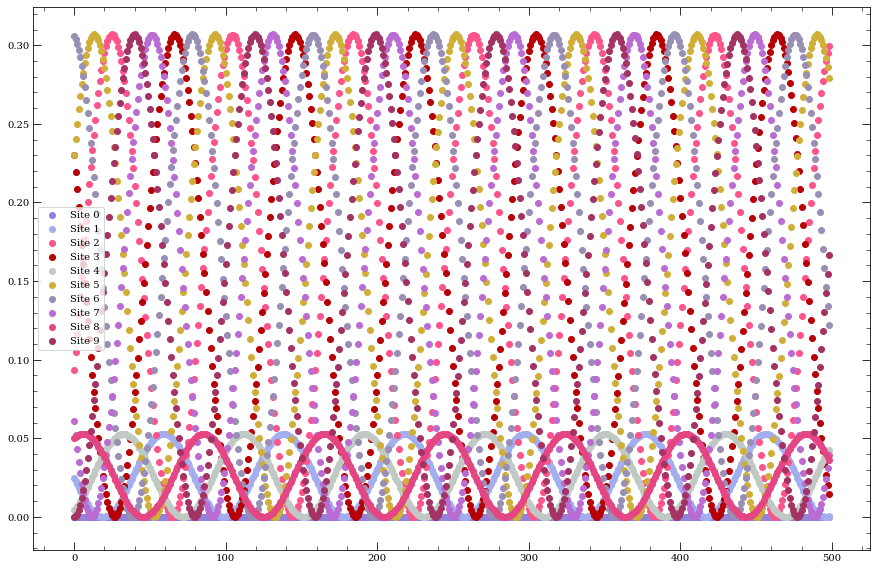

In [122]:
state =eVecs[4]+eVecs[5]
periods =10           #How many time periods
step = 500
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)

(array([3.46612058e-04, 2.00972484e+00]),
 array([1.22959152e-03, 2.00963911e+00]))

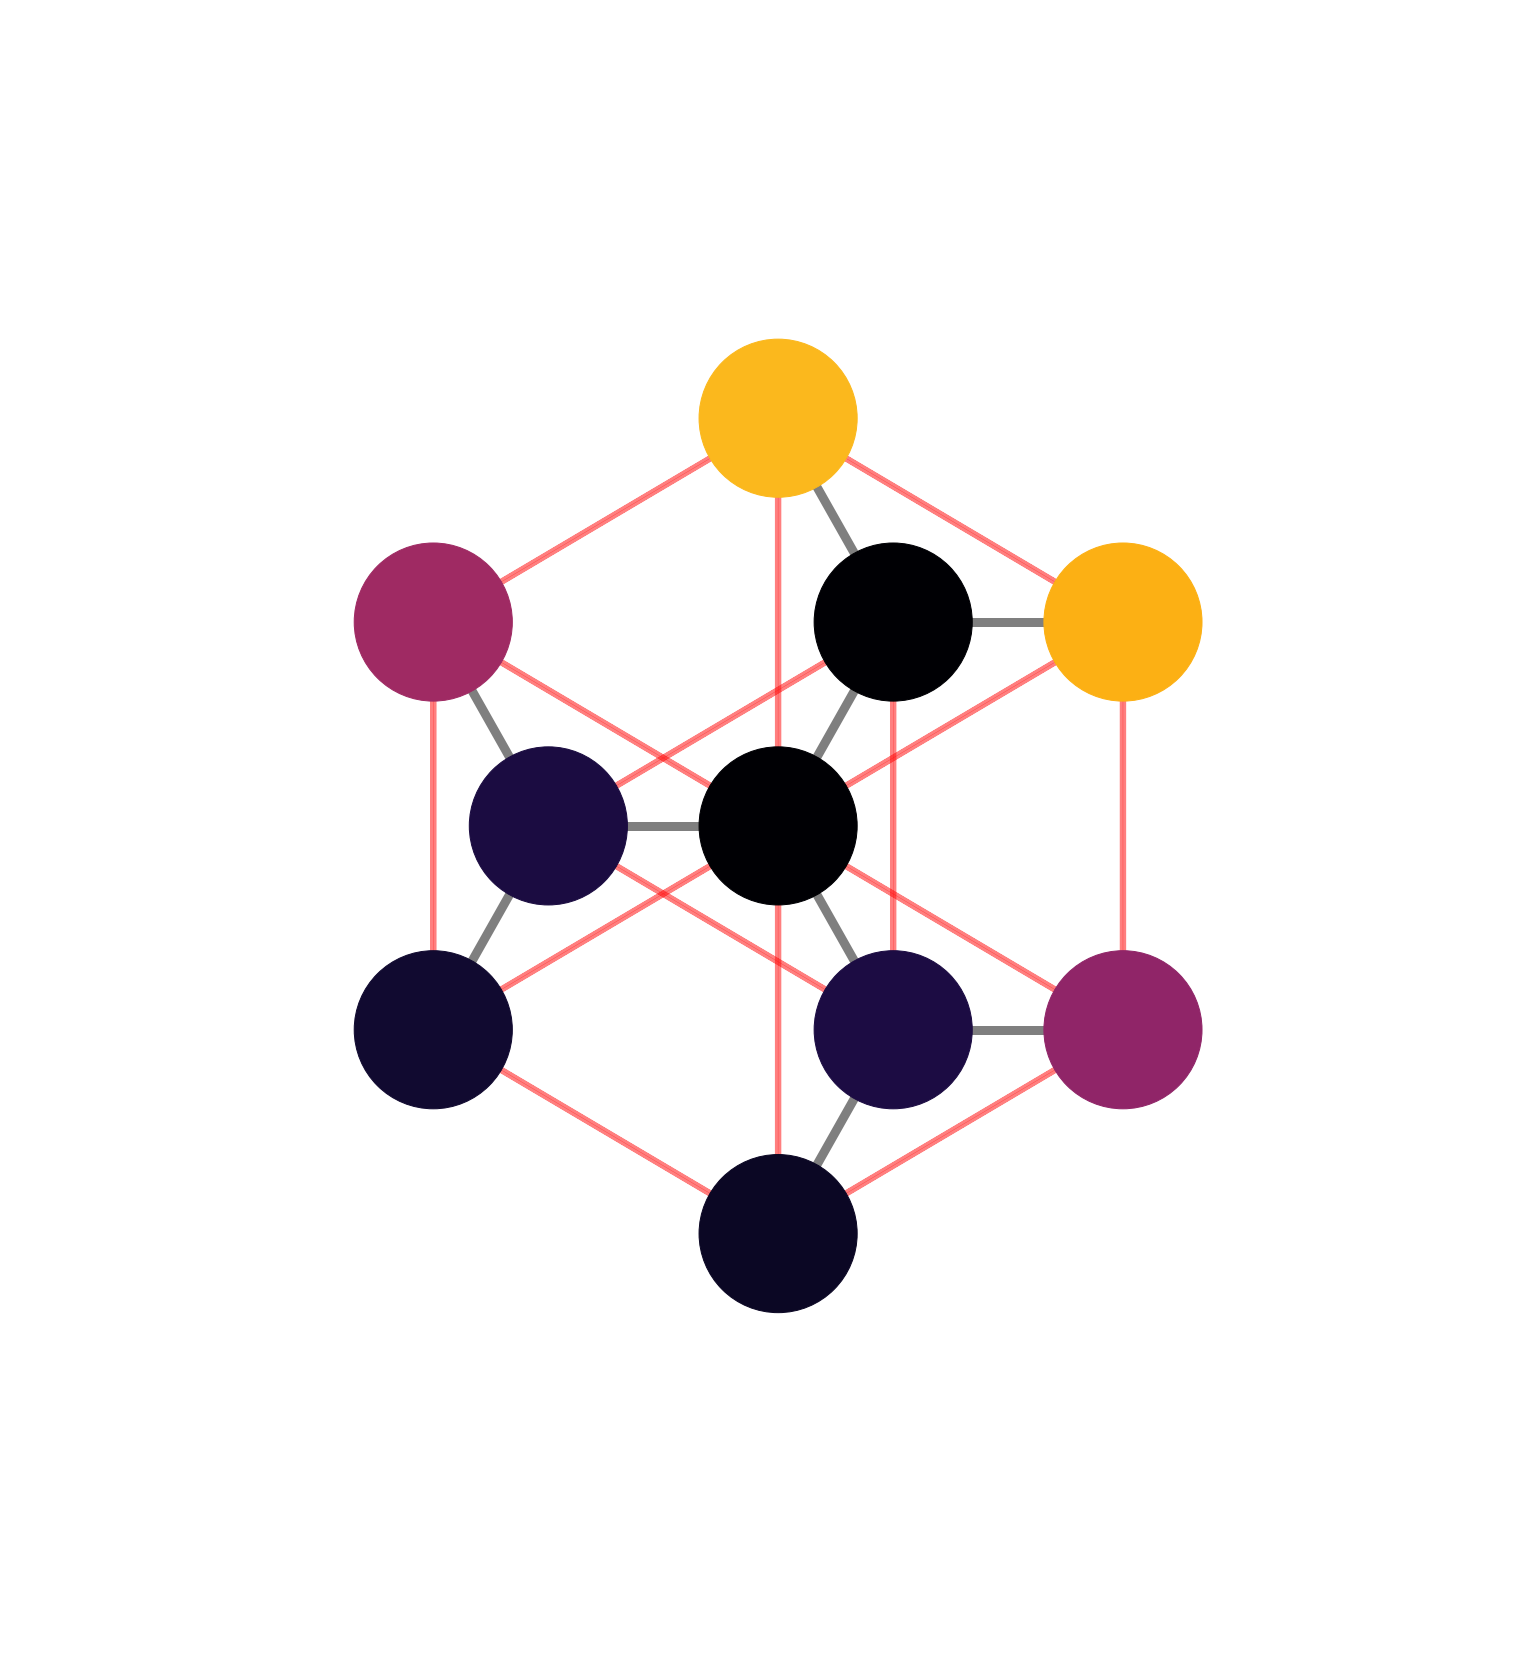

In [556]:
state = eVecs[3]+eVecs[6]
periods =2           #How many time periods
step = 150
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)

Solving


/Users/jordankemp/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Calcing response function


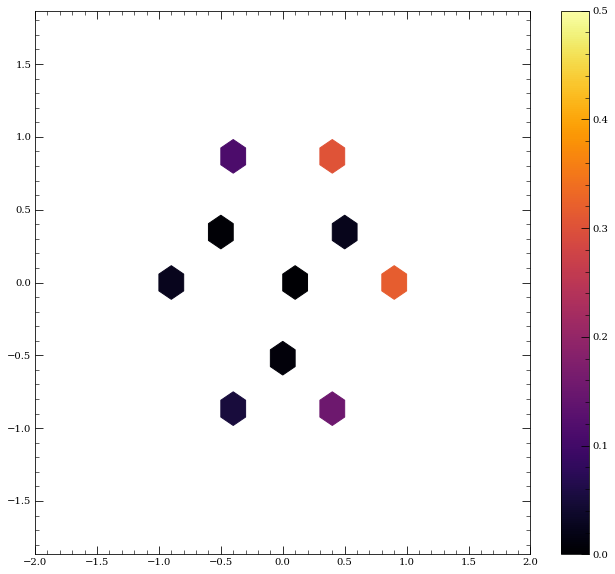

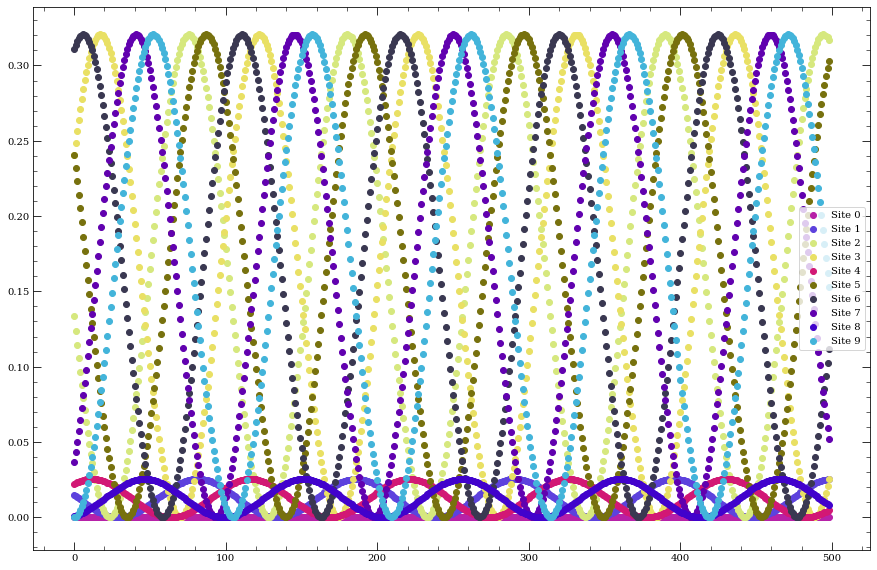

In [124]:
state =eVecs[4]+eVecs[5]
periods =10           #How many time periods
step = 500
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)


<Figure size 1080x1440 with 0 Axes>

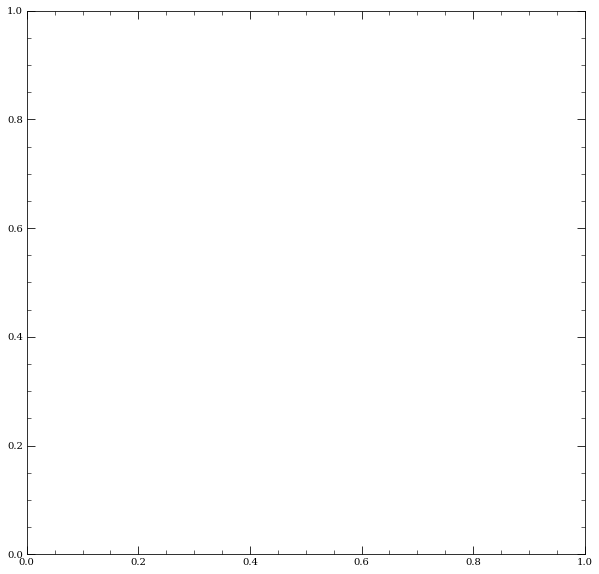

<Figure size 1080x1440 with 0 Axes>

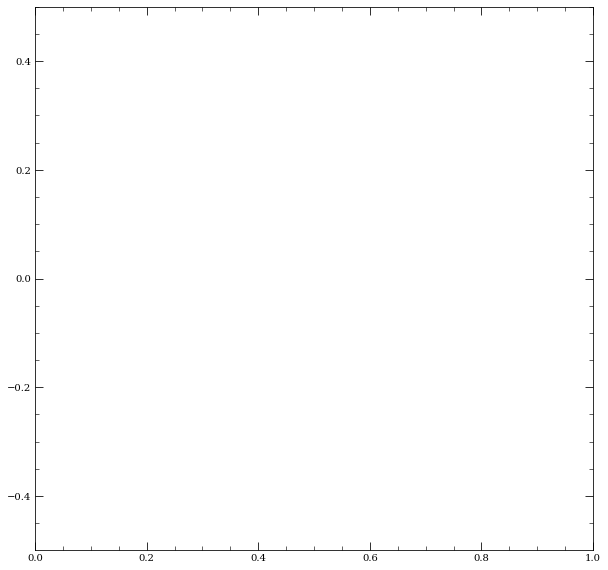

In [570]:
periods =5           #How many time periods
M=0
P=np.pi*1j
symm=True
sets=3
printEigenspectrum(M,P,1,1,1,symm,sets)
    

0.0 0.0
0.289 0.5
0.0 1.0
0.289 1.5
0.0 -1.0
0.289 -0.5
0.289 -1.5
0.866 0.5
1.155 1.0
0.866 -0.5
1.155 0.0
1.155 -1.0
-0.866 -0.5
-0.577 0.0
-0.866 0.5
-0.577 1.0
-0.577 -1.0
-1.443 -0.5
-1.443 0.5
-11.914117872254556


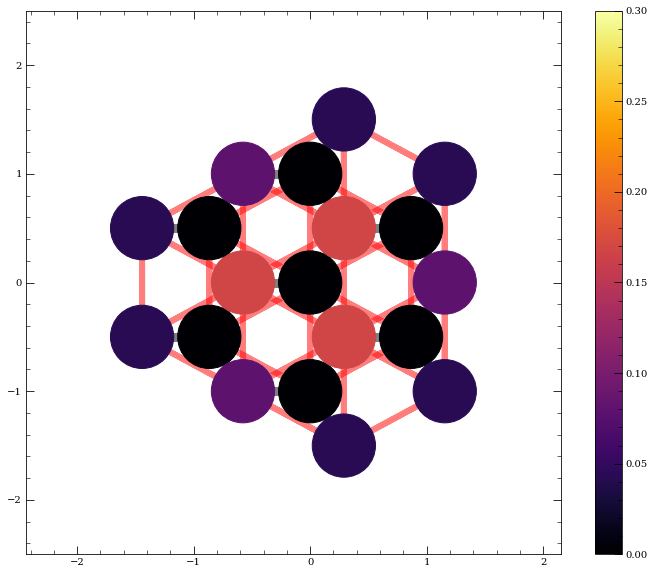

-10.008943732025154


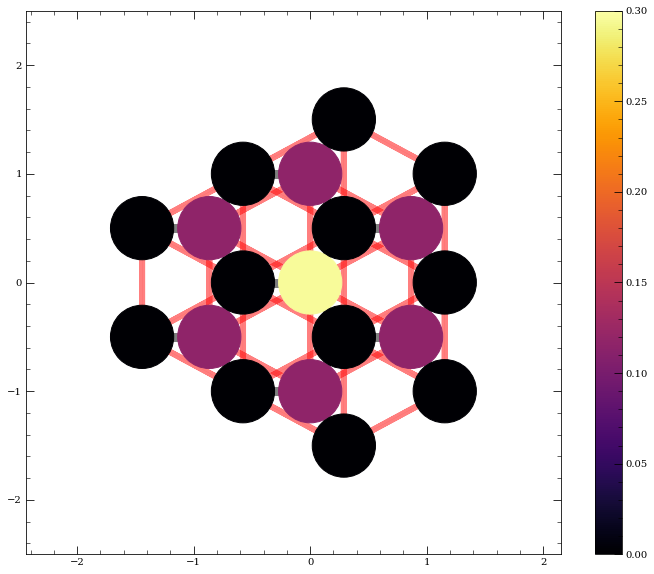

-7.099407899004673


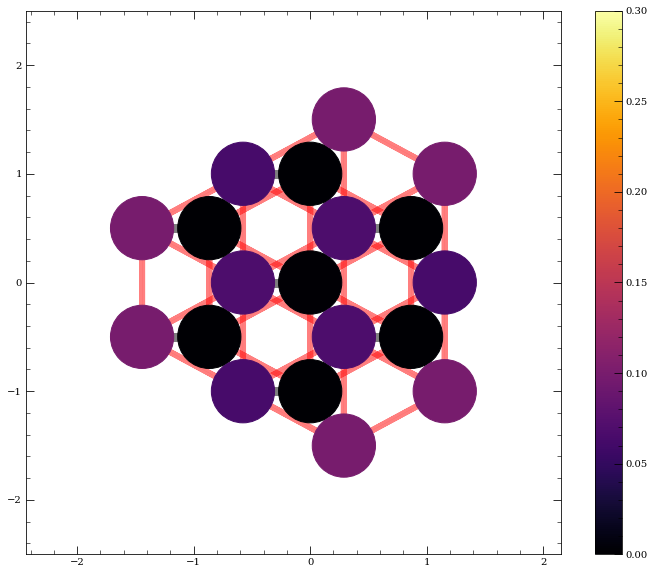

-6.215779009445457


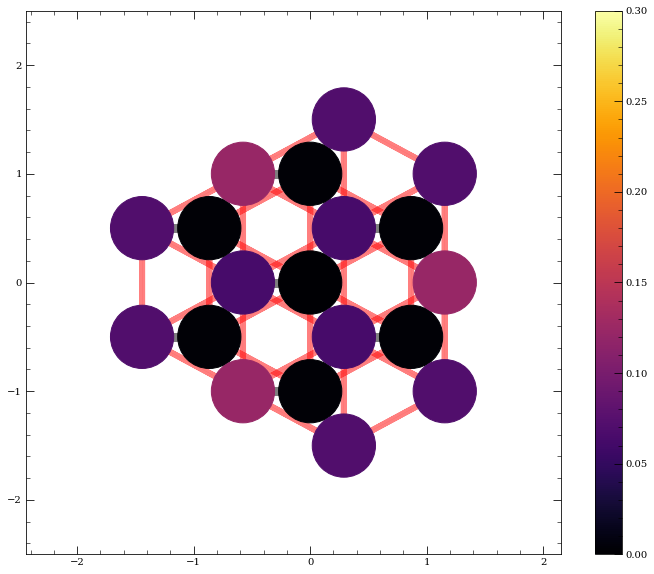

-3.753735201723879


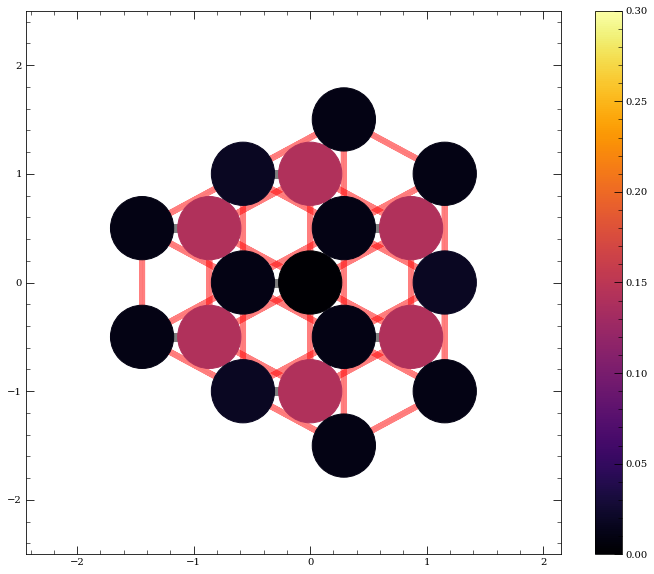

-3.6056748412562456


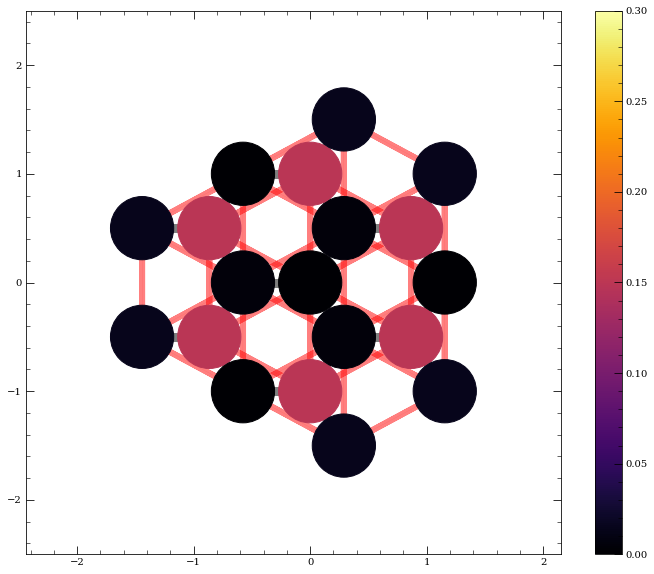

-2.601057117802082


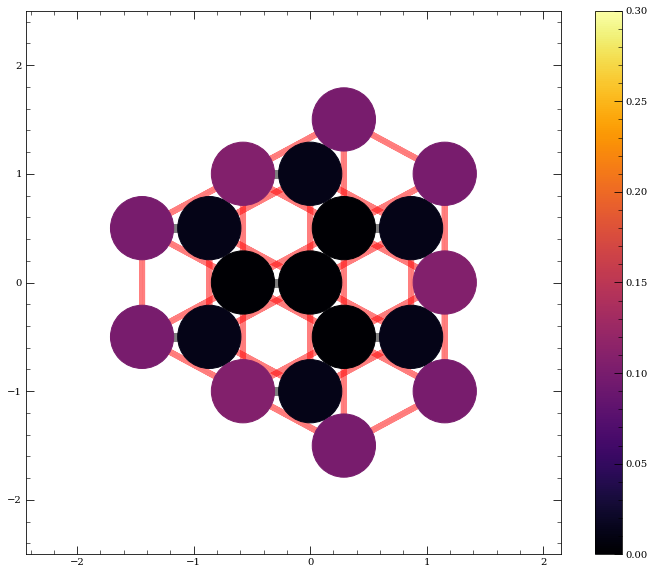

-2.542345151438795


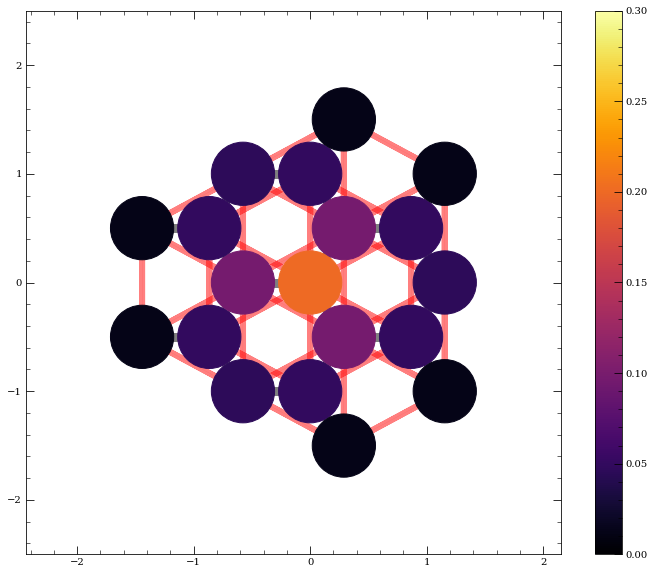

-2.196055987228025


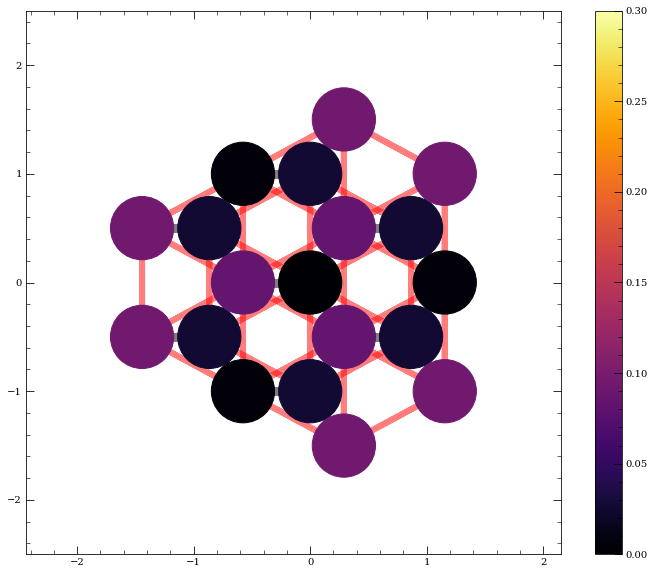

1.4210854715202004e-14


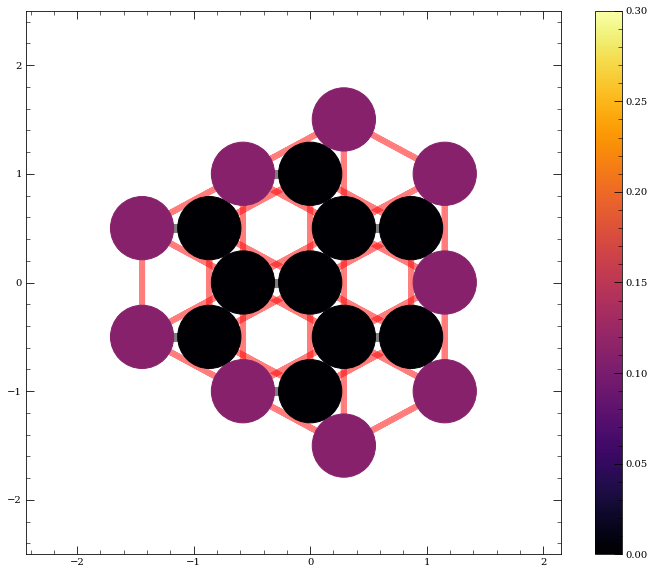

2.196055987228018


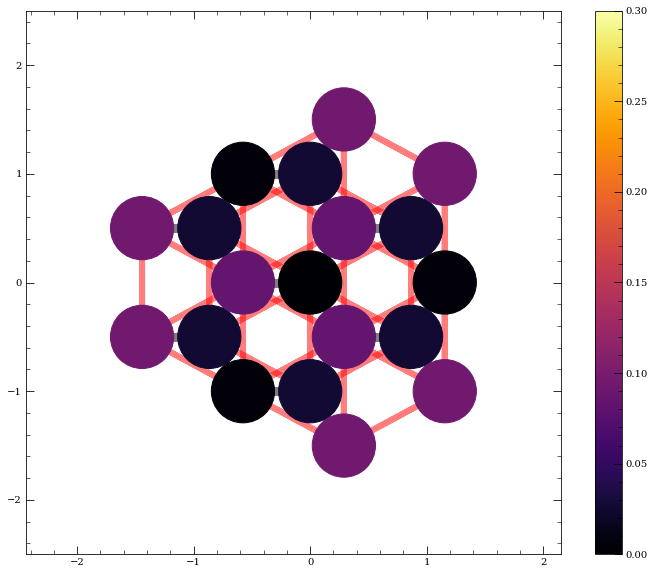

2.542345151438786


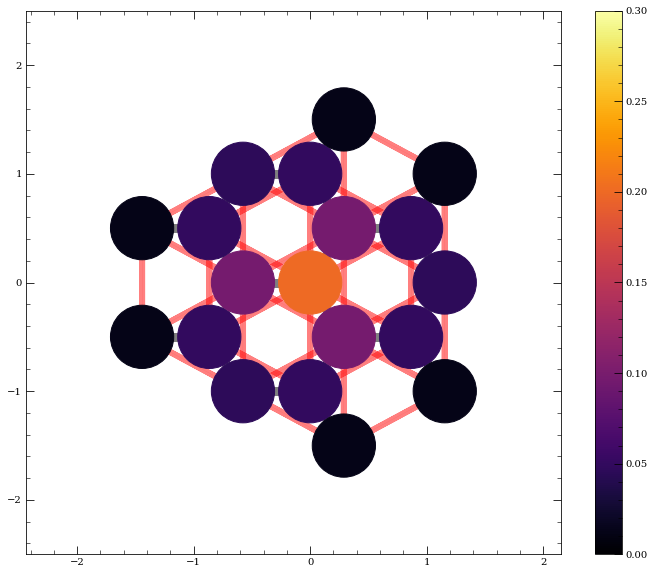

2.6010571178020765


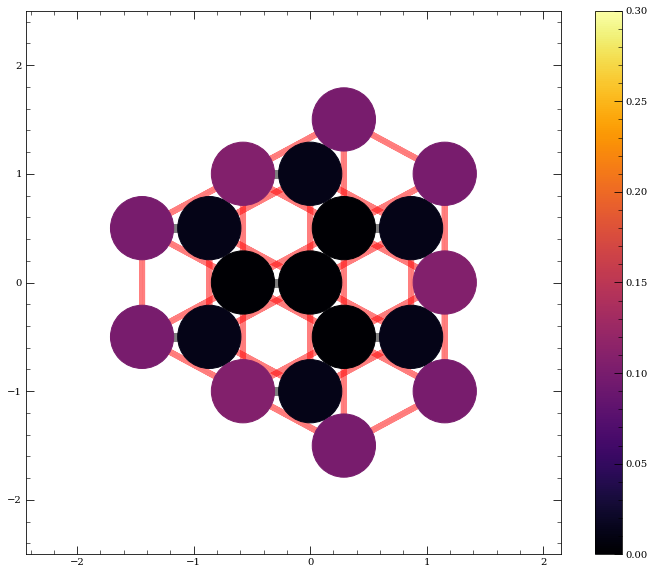

3.6056748412562403


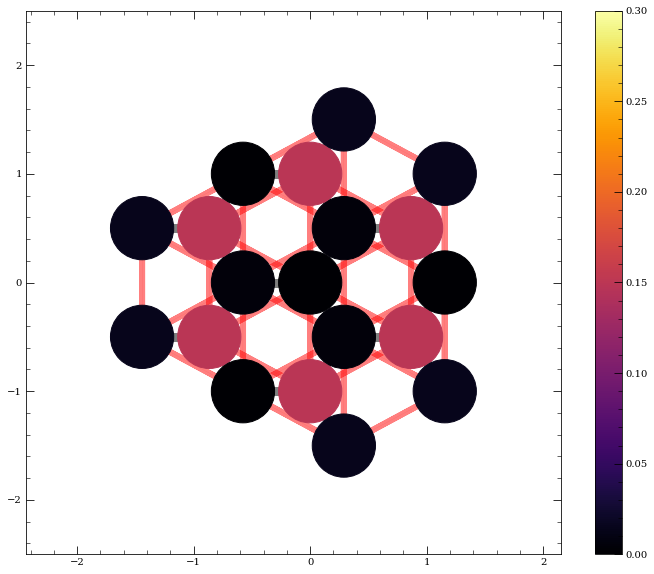

3.7537352017238756


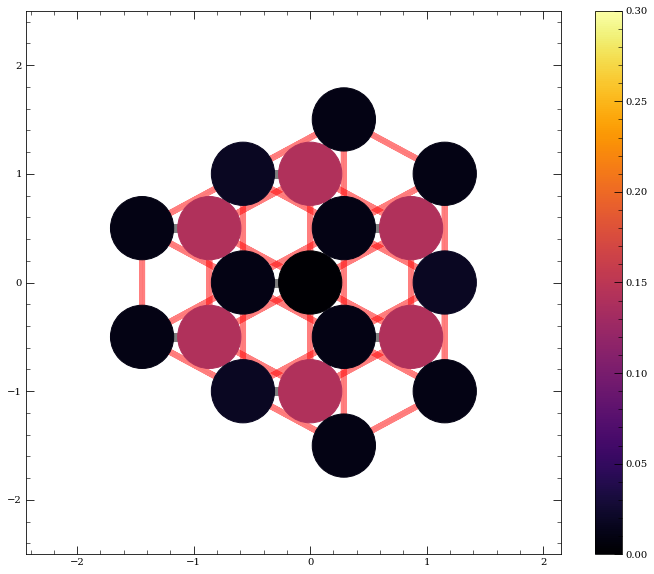

6.215779009445486


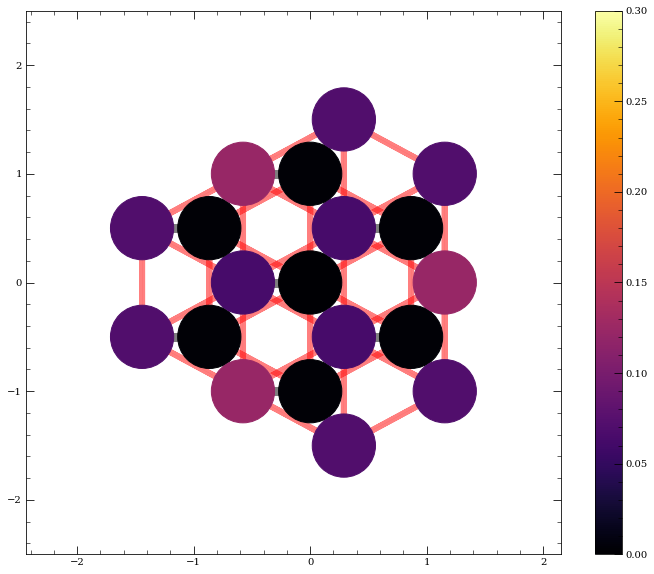

7.099407899004676


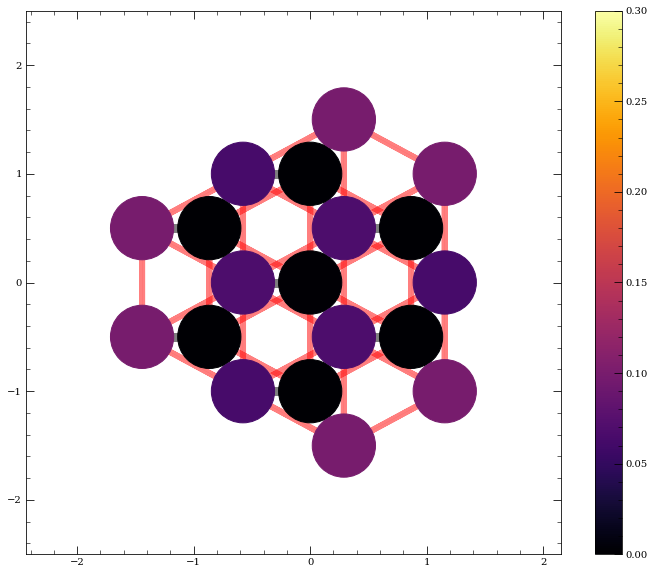

10.008943732025184


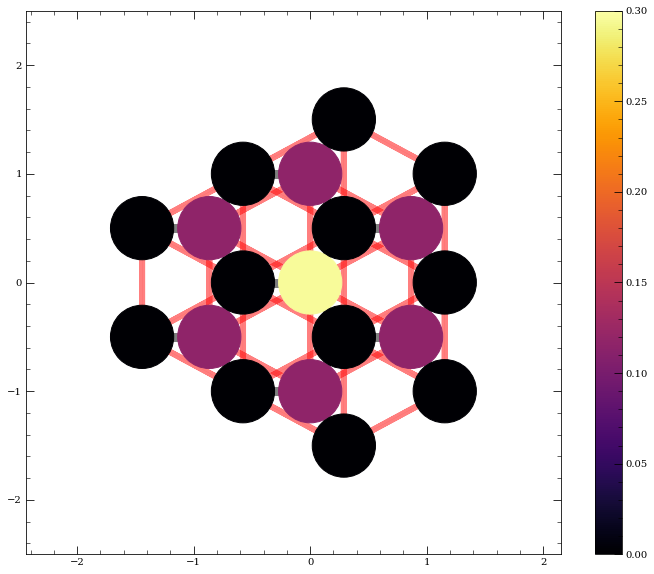

11.914117872254552


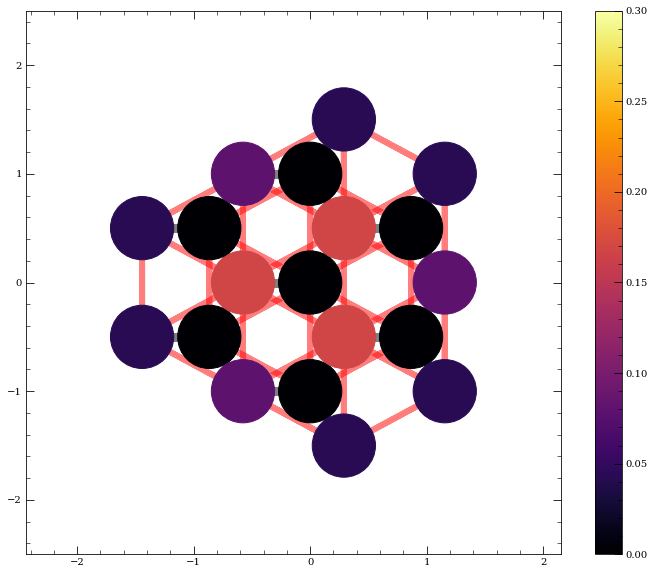

In [571]:
obs_basis=1
nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,1,1,1)
eVals,eVecs,edge=findEigenVectors(eVecs,eVals,proj,nodes,True)

(array([-8.39793226e-05,  1.99588616e+00]),
 array([9.25344571e-05, 2.01023227e+00]))

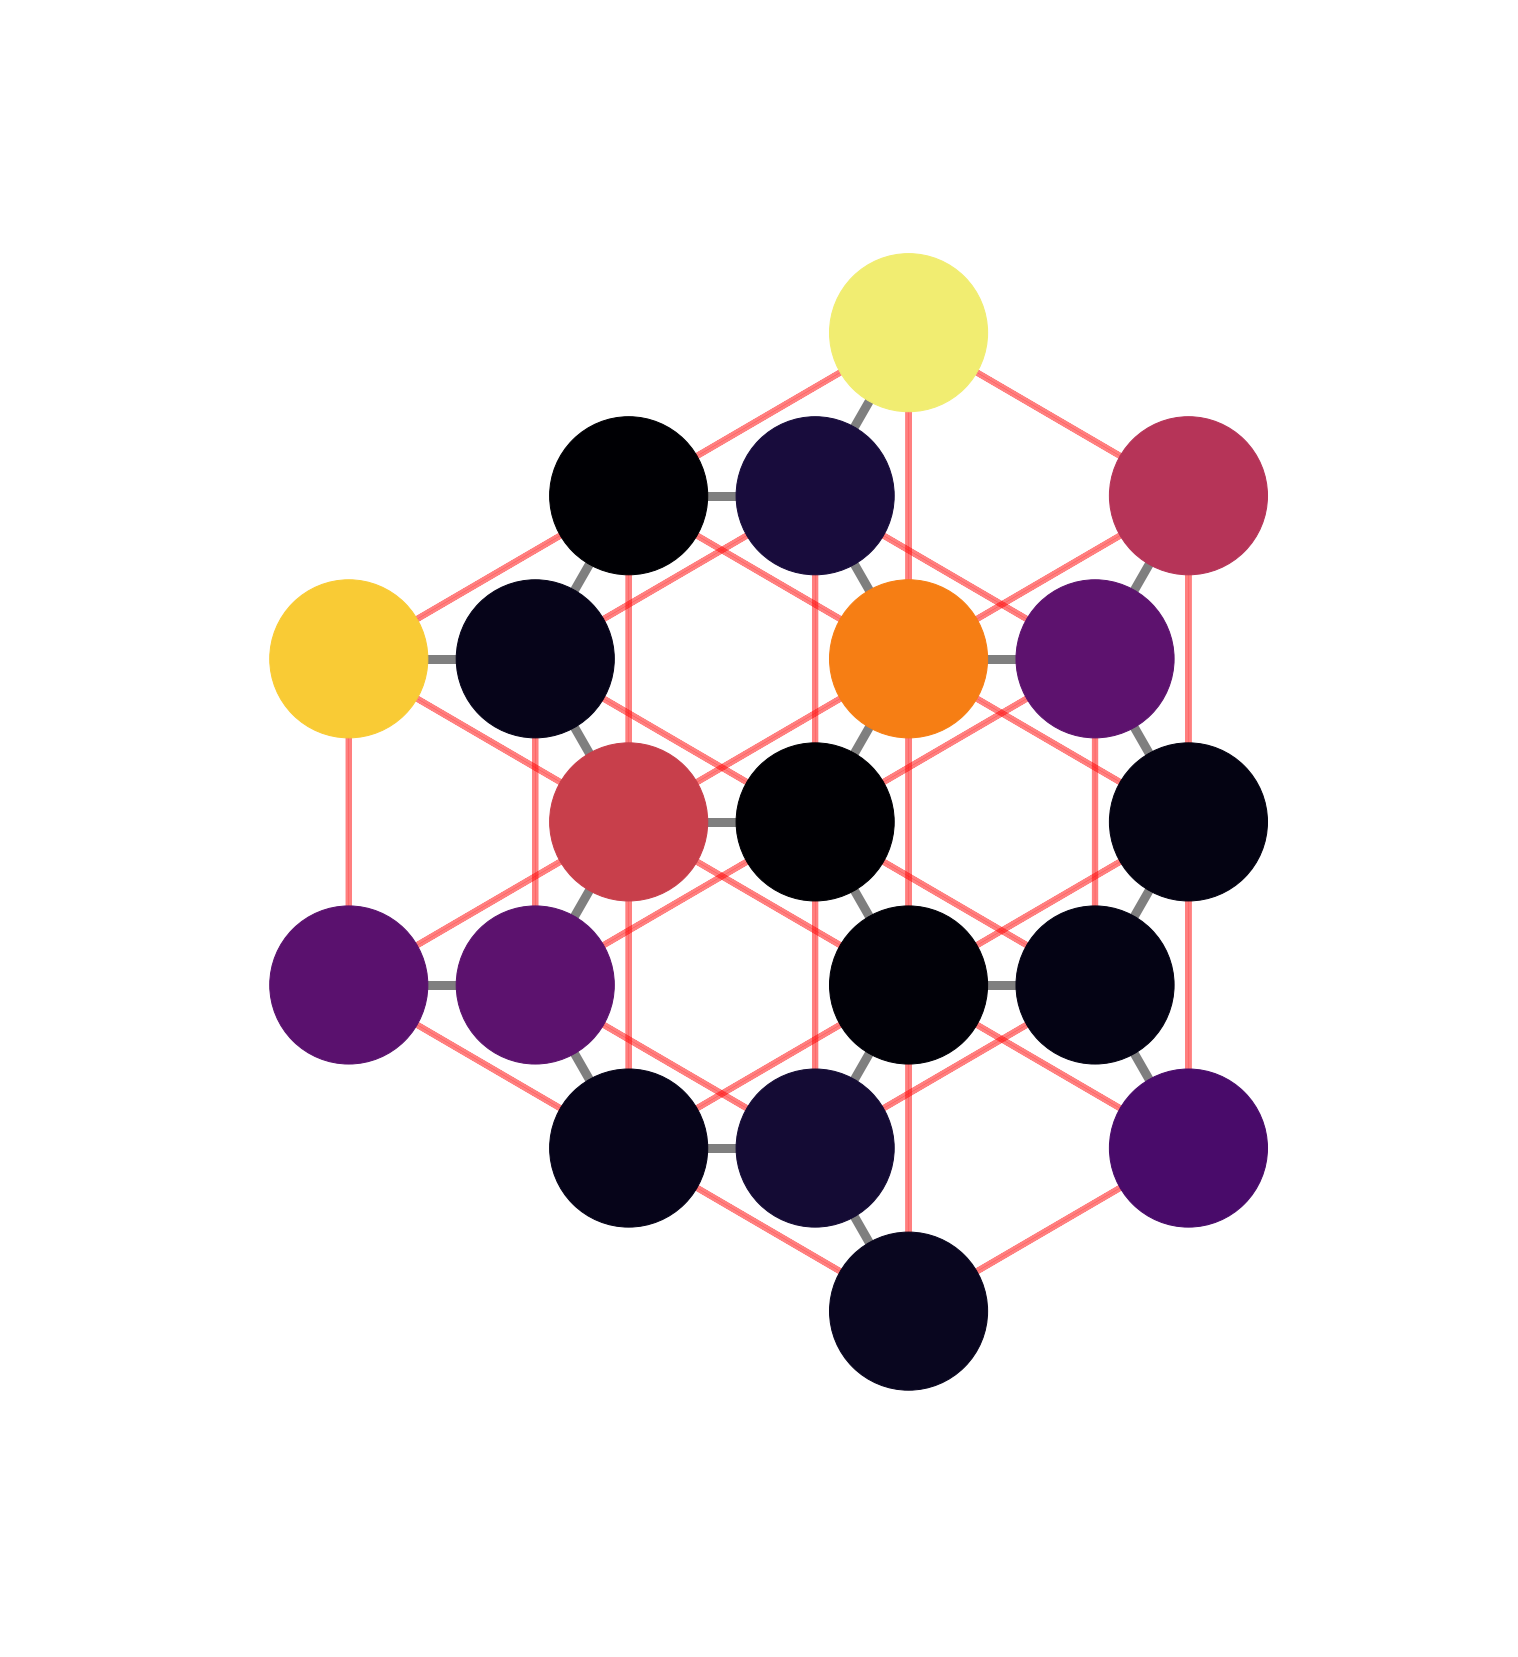

In [575]:
state = eVecs[10]+eVecs[8]
periods =3           #How many time periods
step = 225
runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)

/Users/jordankemp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


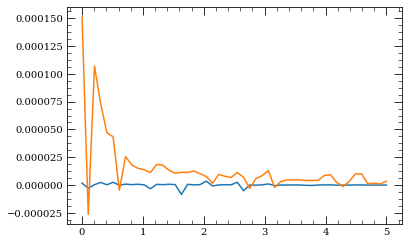

In [346]:
state =eVecs[3]+eVecs[6]
periods =50           #How many time periods
step = 250
hf =[]
lf = []
sets = 2     #How many coupling pairs
ww = np.linspace(0,5,50)
for w in ww:
    periods = 100-w*19.8
    step = 250+ww*1000
    nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,w,w,w)
    high_freq,low_freq = runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)
    hf.append(high_freq[0])
    lf.append(low_freq[0])
plt.plot(ww,hf)
plt.plot(ww,lf)

/Users/jordankemp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


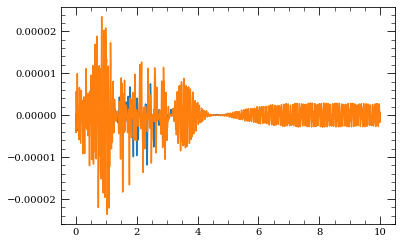

In [209]:
state =eVecs[3]+eVecs[6]
periods =50           #How many time periods
step = 250
hf =[]
lf = []
sets = 2     #How many coupling pairs
ww = np.linspace(0,10,1000)
for w in ww:
    step = 2500+(w*10000)
    nodes,site_num,H,proj,eVals,eVecs=prepHamiltonian(symm,sets,obs_basis,w,w,w)
    high_freq,low_freq = runHamiltonian(site_num,1,H,proj,obs_basis,state,periods,step)
    hf.append(high_freq[0])
    lf.append(low_freq[0])
plt.plot(ww,hf)
plt.plot(ww,lf)

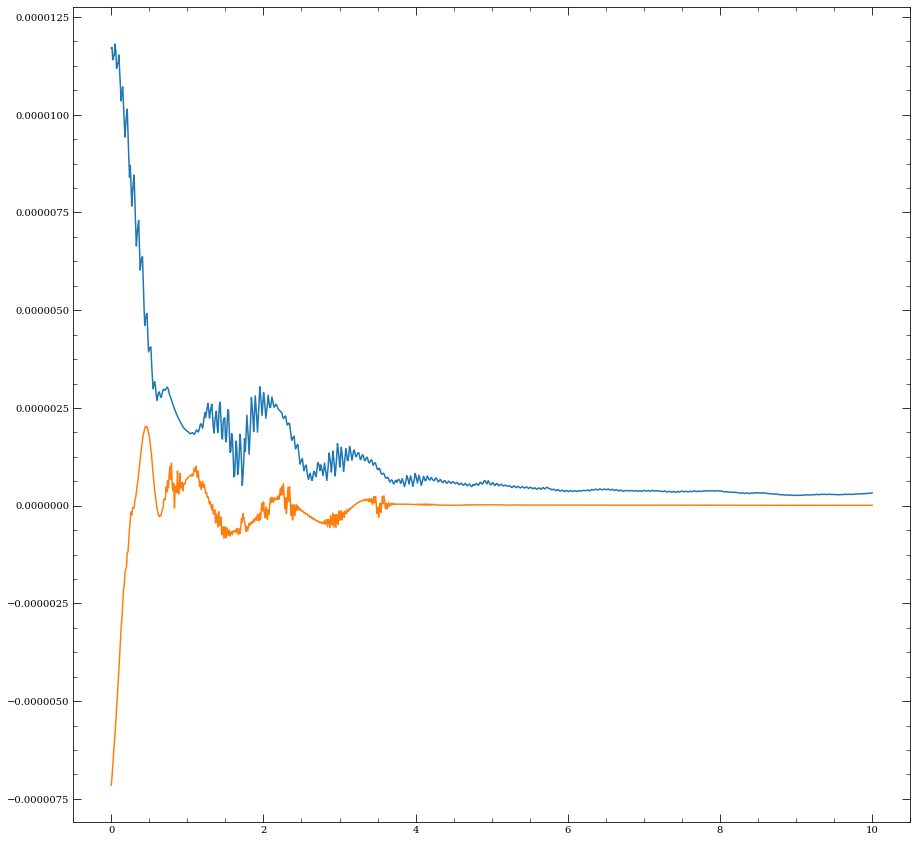

In [206]:
plt.figure(figsize=(15,15))
from scipy import interpolate

# plt.ylim(bottom=-.000075)
# plt.ylim(top=1)
# plt.plot(ww,hf)
plt.plot(ww,savitzky_golay(hf,151,5))
plt.plot(ww,savitzky_golay(hf_deeper,151,5))


# plt.plot(ww,hf,alpha=.5)
plt.show()

In [146]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))

    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


In [395]:
from numpy.random import multivariate_normal

data = np.vstack([
    multivariate_normal([10, 10], [[3, 2], [2, 3]], size=100000),
    multivariate_normal([30, 20], [[2, 3], [1, 3]], size=1000)
])

/Users/jordankemp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  """


In [396]:
data

array([[ 9.77933316,  8.99476552],
       [10.06406309, 12.12763542],
       [ 9.88061556, 12.23151888],
       ...,
       [31.67887863, 22.17552027],
       [30.64171767, 20.91414811],
       [28.39581452, 20.64937179]])

In [397]:

data[:, 0]

array([ 9.77933316, 10.06406309,  9.88061556, ..., 31.67887863, 30.64171767, 28.39581452])

In [420]:
coord = [1,1,1]
x=round(coord[1]*np.sin(theta)+coord[0]+ coord[2]*(1/3)*(1+np.sin(theta)),3)
y=round(coord[1]*np.cos(theta)         + coord[2]*(1/3)*(np.cos(theta)),3)
v= np.rot90([[x,0],[0,y]],1)




In [422]:
v[0][1]

1.155

In [423]:
v[1][0]

2.0